In [1]:
# Some calculation for the LHF coupling and separation across spatial scales.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import glob
import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import geometry as gm
import warnings; warnings.filterwarnings("ignore")

from func_statistics import *

In [2]:
def local_variance(field,sigma):
    bar = gm.nan_gaussian_filter(field**2,sigma)
    return bar

def local_covariance(field_a,field_b,sigma):
    bar = gm.nan_gaussian_filter(field_a*field_b,sigma)
    return bar

In [3]:
from scipy.stats import linregress

def density_scatter(x,y,xlabel,ylabel, minititle):
    fig = plt.figure(figsize=(8,5))
    
    x,y = x[(~np.isnan(x))&(~np.isnan(y))], y[(~np.isnan(x))&(~np.isnan(y))]
    hb = plt.hexbin(x, y, mincnt=1, gridsize=100, bins='log', cmap='inferno')
    cb = plt.colorbar(hb, label='counts')
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.grid()
    
    lr_out = linregress(x,y)
    print(lr_out[1])
    plt.title(f'r={lr_out[2]:.2f}, s={lr_out[0]:.4f} (pval={lr_out[3]:.2}) ' + minititle)
    ics = np.array([np.min(x), np.max(x)])
    plt.plot(ics,ics*lr_out[0]+lr_out[1],'r')
    
def density_scatter_ax(ax,x,y,xlabel,ylabel, minititle, cmap):
    
    x,y = x[(~np.isnan(x))&(~np.isnan(y))], y[(~np.isnan(x))&(~np.isnan(y))]
    hb = ax.hexbin(x, y, mincnt=1, gridsize=100, bins='log', cmap=cmap)
#     cb = ax.colorbar(hb, label='counts')
    fig = ax.get_figure()
    cb = fig.colorbar(hb, ax=ax, label='counts')
    
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel(ylabel,fontsize=12)
    ax.grid()
    
    lr_out = linregress(x,y)
    print(lr_out[1])
    ax.set_title(f'r={lr_out[2]:.2f}, s={lr_out[0]:.4f} ({lr_out[3]:.2})'+minititle)
    ics = np.array([np.min(x), np.max(x)])
    ax.plot(ics,ics*lr_out[0]+lr_out[1],'r')
    ax.plot(ics, ics, '--k')

In [4]:
# Compute the saturation pressure as in Bolton (1980), as implemented in MetPy 
# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.saturation_vapor_pressure.html

B = 17.67 # 1
C = 243.5 # °C
epsilon = 0.622
    
def e_sat(t):
    e_sat0 = 611.2 # Pa
    return e_sat0 * np.exp(B*t/(C+t))

def q_sat(t,p):    
    return epsilon*e_sat(t)/(p-e_sat(t))
    
def dq_sat_dt(t,p):
    return epsilon*e_sat(t)*p*B*C/((p-e_sat(t))**2*(C+t)**2)

def dq2_sat_dt2(t,p):
    return dq_sat_dt(t,p)*(B*C/(C+t)+2*e_sat(t)*B*C/((p-e_sat(t))*(C+t))-2)/(C+t)

## A series of load-and-plot

### band pass

In [6]:
passabanda_files

[]

rh_sst and ta_sst are 0
0.0007425271292675895
q_sst is 0
0.0007075074163647721
rh_sst and ta_sst are 0
-0.004493946039061614
q_sst is 0
-0.00459382006300546


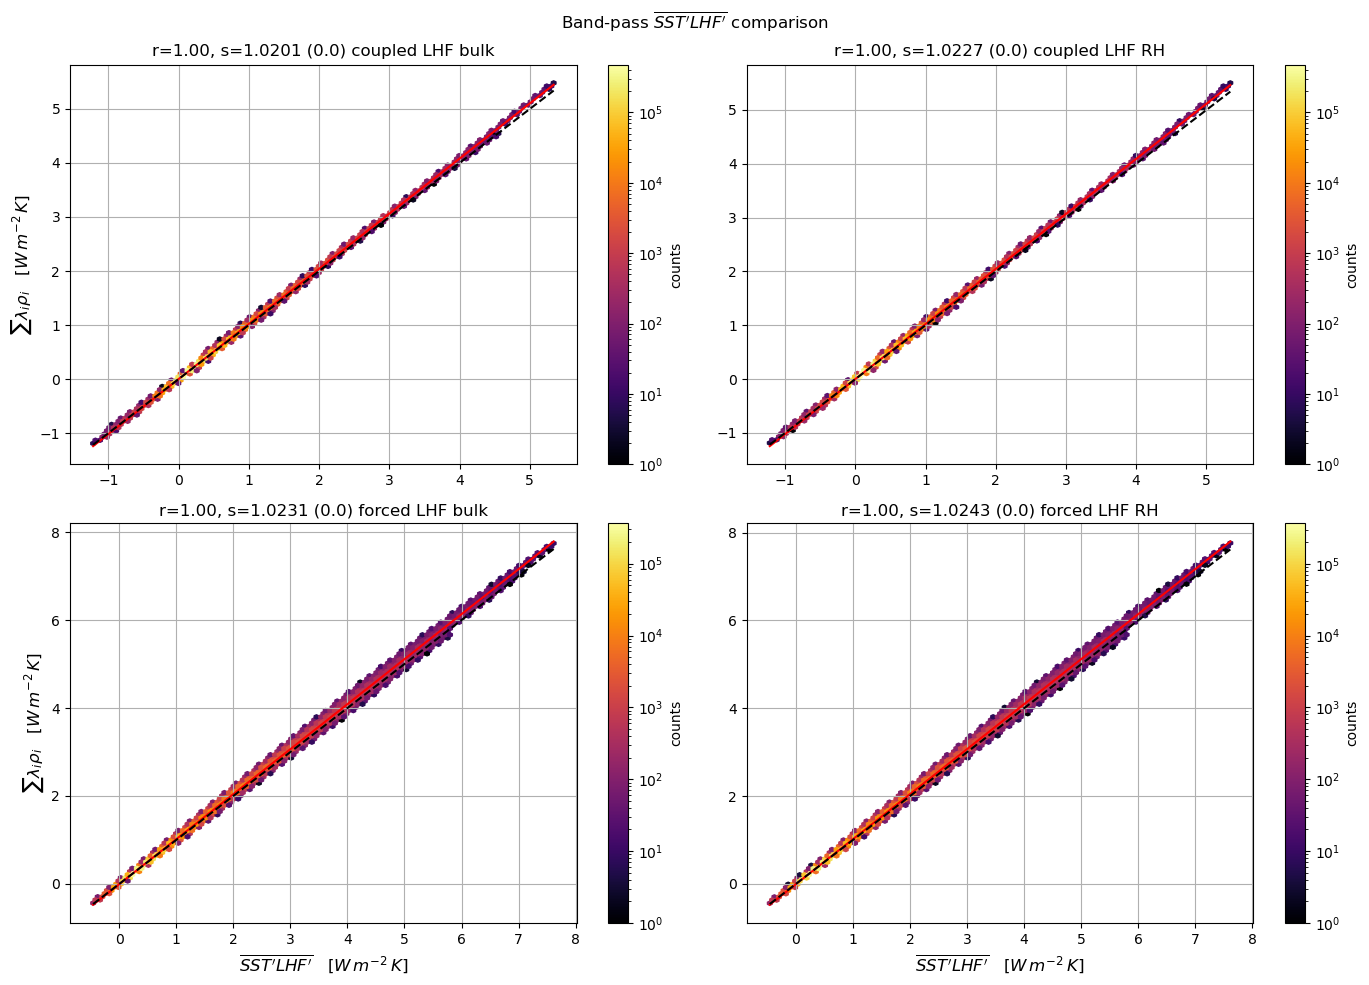

In [12]:
bins = 50

passabanda_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*band-pass*_all.nc')
passabanda_files = sorted(passabanda_files)

fig, ax =  plt.subplots(2,2, figsize=(14,10))
fig.suptitle(r"Band-pass $\overline{SST'LHF'}$ comparison")



for i in range(len(passabanda_files)):
    ds = xr.open_dataset(passabanda_files[i])
    
    u_sst = ds['lambda_U'].values*ds['covar_U_sst'].values
    sst_sst = ds['lambda_sst'].values*ds['var_sst'].values 
    q_sst = ds['lambda_q'].values*ds['covar_q_sst'].values
    ta_sst = ds['lambda_ta'].values*ds['covar_ta_sst'].values 
    rh_sst = ds['lambda_RH'].values*ds['covar_RH_sst'].values
    
    if np.all(rh_sst[~np.isnan(rh_sst)]==0.) and np.all(ta_sst[~np.isnan(ta_sst)]==0.):
        print('rh_sst and ta_sst are 0')
        del rh_sst, ta_sst
        covar_sum = sst_sst + u_sst + q_sst
    elif np.all(q_sst[~np.isnan(q_sst)]==0.):
        print('q_sst is 0')
        del q_sst
        covar_sum = u_sst + sst_sst + ta_sst + rh_sst
        
    
    covar_lhf_sst = ds['covar_lhf_sst'].values
    
    
    j,k = divmod(i,2)
    xlab = r"$\overline{SST' LHF'}$   [$W \, m^{-2} \, K$]" if j==1 else ''
    ylab = '$\\sum \\lambda_i \\rho_i$   [$W \, m^{-2} \, K$]' if k==0 else ''
    
    RH = True if 'lhfRH' in passabanda_files[i].split('/')[-1] else False
    RH = ' LHF RH' if RH else ' LHF bulk'
    
    coupled = True if 'ALE' in passabanda_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    density_scatter_ax(ax=ax[j,k], x=covar_lhf_sst, y=covar_sum, \
                       xlabel=xlab, ylabel=ylab, minititle=coupled+RH, cmap='inferno')

plt.tight_layout()



plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/SSTLHF_covariance_bandpass_daily.png')




######## DIR only
# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/DIR_only/SSTLHF_covariance_bandpass_daily_dir.png')

rh_sst and ta_sst are 0
q_sst is 0
rh_sst and ta_sst are 0
q_sst is 0


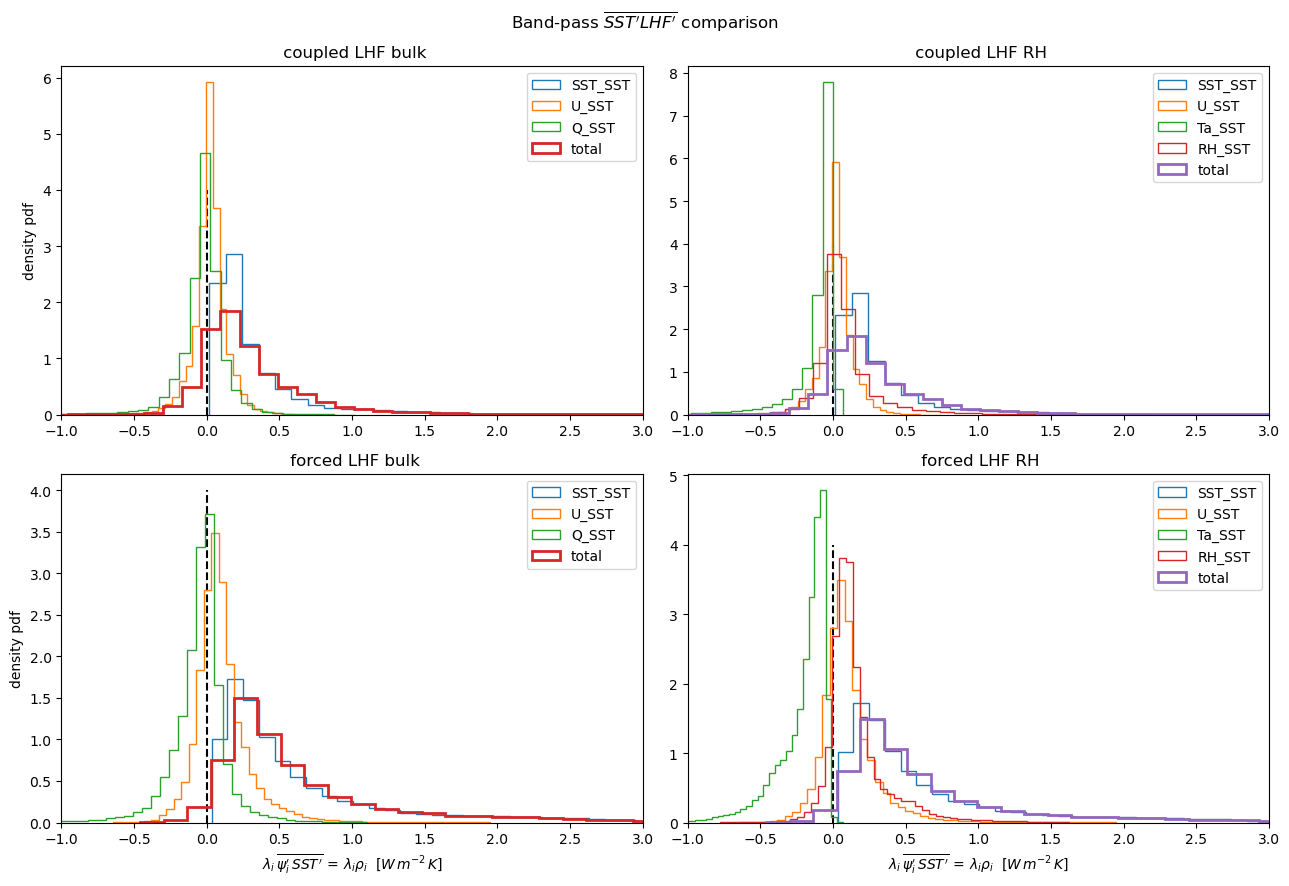

In [43]:
passabanda_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*band-pass*_all.nc')
passabanda_files = sorted(passabanda_files)

fig, ax =  plt.subplots(2,2, figsize=(13,9))
fig.suptitle(r"Band-pass $\overline{SST'LHF'}$ comparison")


def histogram_local(ax,bins, variabs, labels, title, axlabs):
    for i in range(len(variabs)):
        lnwd = 1
        if i+1 == len(variabs):
            lnwd = 2
        ax.hist((variabs[i]).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labs)
        ax.set_xlim(-1,3)
        ax.set_title(title)
        ax.set_xlabel(axlabs[0]); ax.set_ylabel(axlabs[1])


for i in range(len(passabanda_files)):
    ds = xr.open_dataset(passabanda_files[i])
    
    u_sst = ds['lambda_U'].values*ds['covar_U_sst'].values
    sst_sst = ds['lambda_sst'].values*ds['var_sst'].values 
    q_sst = ds['lambda_q'].values*ds['covar_q_sst'].values
    ta_sst = ds['lambda_ta'].values*ds['covar_ta_sst'].values 
    rh_sst = ds['lambda_RH'].values*ds['covar_RH_sst'].values
    covar_lhf_sst = ds['covar_lhf_sst'].values
    
    if np.all(rh_sst[~np.isnan(rh_sst)]==0.) and np.all(ta_sst[~np.isnan(ta_sst)]==0.):
        print('rh_sst and ta_sst are 0')
        del rh_sst, ta_sst
        var_list = [sst_sst, u_sst, q_sst, covar_lhf_sst]
        labs = ['SST_SST', 'U_SST', 'Q_SST', 'total']
        
    elif np.all(q_sst[~np.isnan(q_sst)]==0.):
        print('q_sst is 0')
        del q_sst
        var_list = [sst_sst, u_sst, ta_sst, rh_sst, covar_lhf_sst]        
        labs = ['SST_SST', 'U_SST', 'Ta_SST', 'RH_SST', 'total']
    
    
    
    j,k = divmod(i,2)
    xlab = r"$\lambda_i \, \overline{\psi_i'\,SST'}\,=\,\lambda_i \rho_i$  [$W \, m^{-2} \, K$]" if j==1 else ''
    ylab = 'density pdf' if k==0 else ''
    
    
    RH = True if 'lhfRH' in passabanda_files[i].split('/')[-1] else False
    RH = ' LHF RH' if RH else ' LHF bulk'
    
    coupled = True if 'ALE' in passabanda_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    histogram_local(ax = ax[j,k], bins=50, variabs=var_list, labels=labs, title=coupled+RH, axlabs = [xlab,ylab])
    ax[j,k].vlines(0., ymin=0, ymax=4, color='k', linestyle='--')
    
plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/SSTLHF_SingleTerms_covariance_bandpass_daily.png')



###### DIR only
# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/DIR_only/SSTLHF_SingleTerms_covariance_bandpass_daily_dir.png')

## band pass U' LHF'

rh_u and ta_u are 0
q_U is 0
rh_u and ta_u are 0
q_U is 0


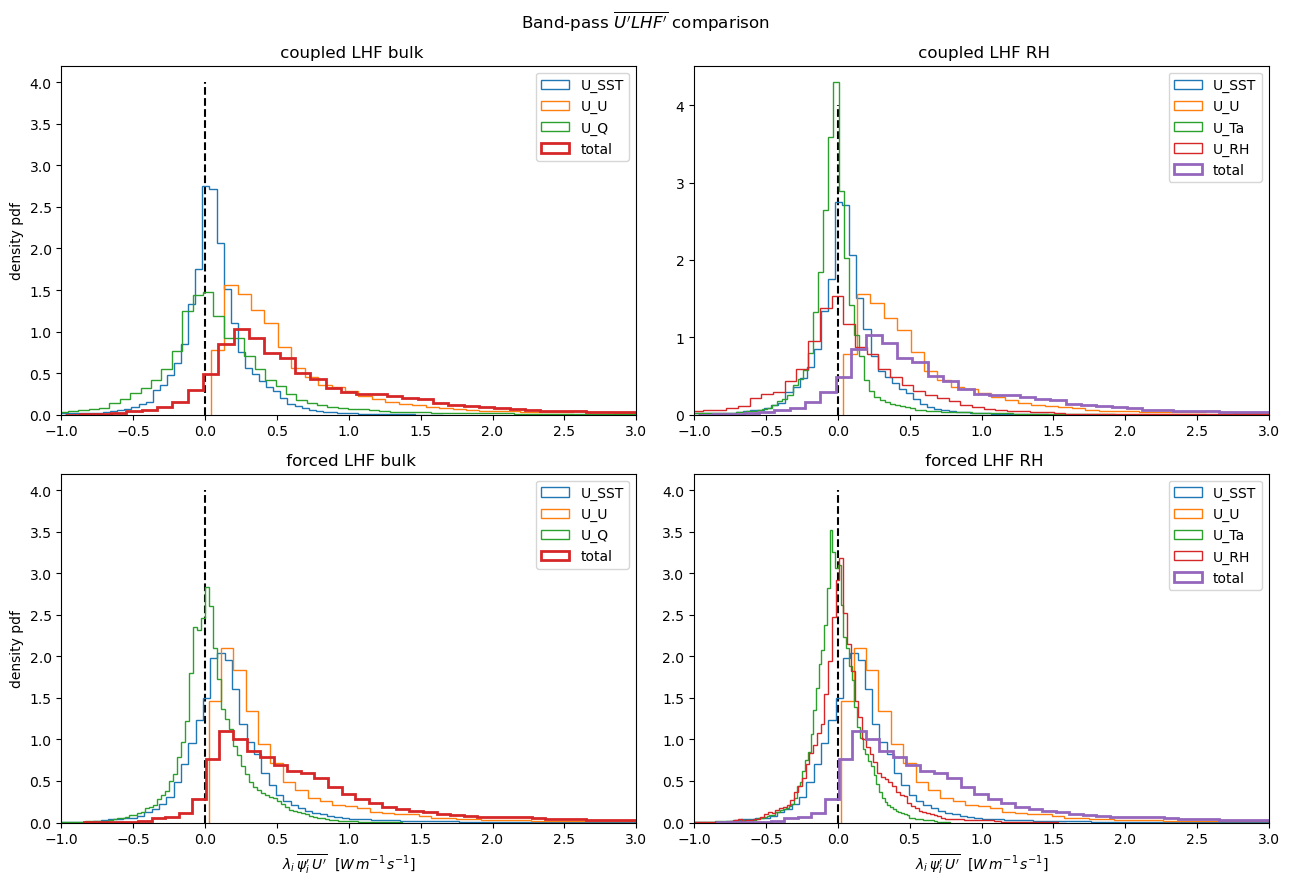

In [21]:
passabanda_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW*band-pass*_all.nc')
passabanda_files = sorted(passabanda_files)

fig, ax =  plt.subplots(2,2, figsize=(13,9))
fig.suptitle(r"Band-pass $\overline{U'LHF'}$ comparison")


def histogram_local(ax,bins, variabs, labels, title, axlabs):
    for i in range(len(variabs)):
        lnwd = 1
        if i+1 == len(variabs):
            lnwd = 2
        ax.hist((variabs[i]).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labs)
        ax.set_xlim(-1,3)
        ax.set_title(title)
        ax.set_xlabel(axlabs[0]); ax.set_ylabel(axlabs[1])


for i in range(len(passabanda_files)):
    ds = xr.open_dataset(passabanda_files[i])
    
    u_sst = ds['lambda_sst'].values*ds['covar_U_sst'].values
    u_u = ds['lambda_U'].values*ds['var_U'].values
    q_u = ds['lambda_q'].values*ds['covar_U_q'].values
    ta_u = ds['lambda_ta'].values*ds['covar_U_ta'].values 
    rh_u = ds['lambda_RH'].values*ds['covar_U_RH'].values
    covar_lhf_u = ds['covar_U_lhf'].values

    if np.all(rh_u[~np.isnan(rh_u)]==0.) and np.all(ta_u[~np.isnan(ta_u)]==0.):
        print('rh_u and ta_u are 0')
        del rh_u, ta_u
        var_list = [u_sst, u_u, q_u, covar_lhf_u]
        labs = ['U_SST', 'U_U', 'U_Q', 'total']
        
    elif np.all(q_u[~np.isnan(q_u)]==0.):
        print('q_U is 0')
        del q_u
        var_list = [u_sst, u_u, ta_u, rh_u, covar_lhf_u]        
        labs = ['U_SST', 'U_U', 'U_Ta', 'U_RH', 'total']
    
    
    
    j,k = divmod(i,2)
    xlab = r"$\lambda_i \, \overline{\psi_i'\,U'}$  [$W \, m^{-1} \, s^{-1} $]" if j==1 else ''
    ylab = 'density pdf' if k==0 else ''
    
    
    RH = True if 'lhfRH' in passabanda_files[i].split('/')[-1] else False
    RH = ' LHF RH' if RH else ' LHF bulk'
    
    coupled = True if 'ALE' in passabanda_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    histogram_local(ax = ax[j,k], bins=100, variabs=var_list, labels=labs, title=coupled+RH, axlabs = [xlab,ylab])
    ax[j,k].vlines(0., ymin=0, ymax=4, color='k', linestyle='--')
    
plt.tight_layout()



# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/ULHF_SingleTerms_covariance_bandpass_daily.png')

### bandpass: U'LHF' vs SST ' LHF' ?

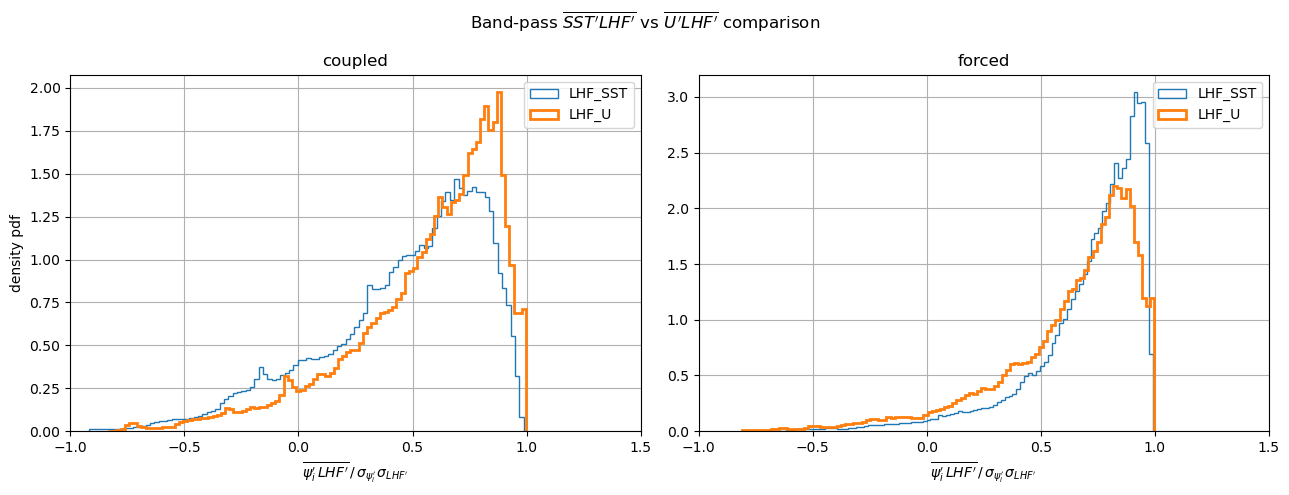

In [28]:

passabanda_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW*band-pass*lhfDIR*_all.nc')
passabanda_files = sorted(passabanda_files)

fig, ax =  plt.subplots(1,2, figsize=(13,5))
fig.suptitle(r"Band-pass $\overline{SST'LHF'}$ vs $\overline{U'LHF'}$ comparison")


def histogram_local(ax,bins, variabs, labels, title, axlabs):
    for i in range(len(variabs)):
        lnwd = 1
        if i+1 == len(variabs):
            lnwd = 2
        ax.hist((variabs[i]).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labs)
        ax.set_xlim(-1,1.5)
        ax.set_title(title)
        ax.set_xlabel(axlabs[0]); ax.set_ylabel(axlabs[1])
        


for i in range(len(passabanda_files)):
    ds = xr.open_dataset(passabanda_files[i])
    
    sst_sst = ds['var_sst'].values
    u_u = ds['var_U'].values
    
    lhf_lhf = ds['var_lhf'].values
    
    norm_covar_lhf_sst = ds['covar_lhf_sst'].values/(np.sqrt(sst_sst*lhf_lhf))
    norm_covar_lhf_u = ds['covar_U_lhf'].values/(np.sqrt(u_u*lhf_lhf))
    
    var_list = [norm_covar_lhf_sst, norm_covar_lhf_u]        
    labs = ['LHF_SST', 'LHF_U']
    
    xlab = r"$ \overline{\psi_i'\,LHF'}\,/\,\sigma_{\psi_i'}\,\sigma_{LHF'}$"
    ylab = 'density pdf' if i==0 else ''
    
    coupled = True if 'ALE' in passabanda_files[i].split('/')[-1] else False
    coupled = 'coupled' if coupled else 'forced'
    
    histogram_local(ax = ax[i], bins=100, variabs=var_list, labels=labs, title=coupled, axlabs = [xlab,ylab])
    ax[i].grid()
    #ax[i].vlines(0., ymin=0, ymax=1, color='k', linestyle='--')
    
plt.tight_layout()



# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/ULHF_vs_SSTLHF_bandpass_daily.png')



# how do different models / formulations explain the LHR var?

rh_sst and ta_sst are 0
0.2824379883253485
q_sst is 0
0.2773458654943539
rh_sst and ta_sst are 0
-0.15710576019396427
q_sst is 0
-0.2410661405630492


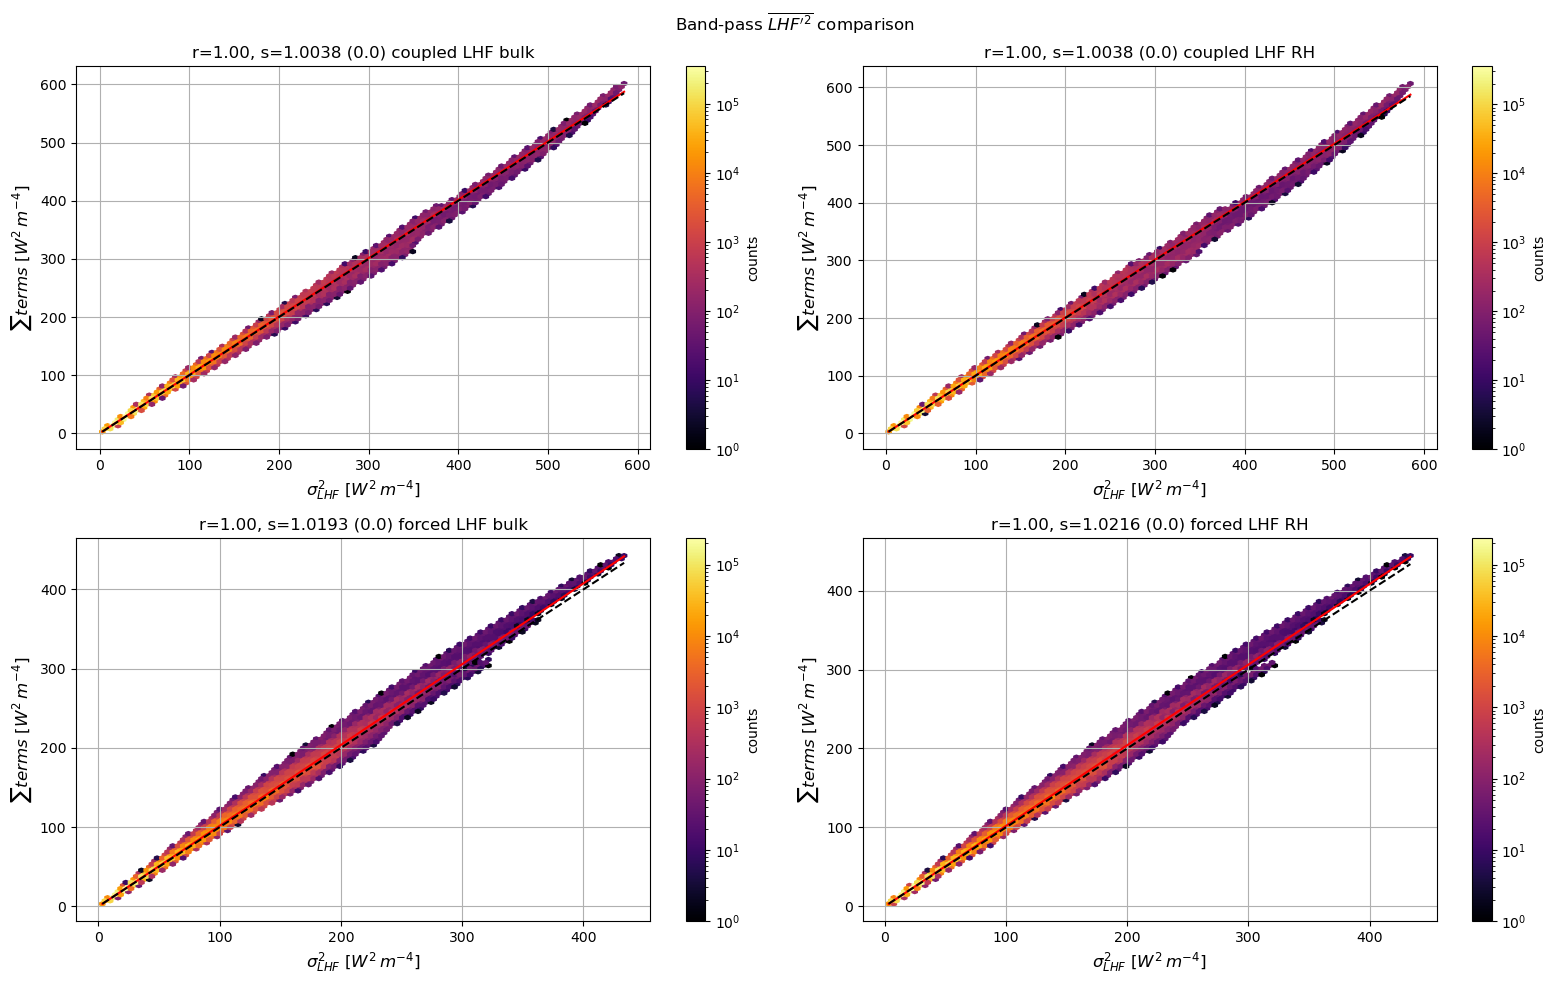

In [22]:
bins = 50

passabanda_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*band-pass*_all.nc')
passabanda_files = sorted(passabanda_files)


fig, ax =  plt.subplots(2,2, figsize=(16,10))
fig.suptitle(r"Band-pass $\overline{LHF'^2}$ comparison")


for i in range(len(passabanda_files)):
    ds = xr.open_dataset(passabanda_files[i])
    
    lambda_U = ds['lambda_U'].values
    lambda_sst = ds['lambda_sst'].values
    lambda_q = ds['lambda_q'].values
    lambda_ta = ds['lambda_ta'].values
    lambda_RH = ds['lambda_RH'].values
    
    var_lhf = ds['var_lhf'].values
    var_qa = ds['var_qa'].values 
    var_U = ds['var_U'].values 
    var_ta = ds['var_ta'].values 
    var_RH = ds['var_RH'].values 
    covar_U_ta = ds['covar_U_ta'].values 
    covar_U_RH = ds['covar_U_RH'].values 
    covar_ta_RH = ds['covar_ta_RH'].values 
    covar_U_q = ds['covar_U_q'].values 
    
    # sst terms
    var_sst = ds['var_sst'].values 
    covar_ta_sst = ds['covar_ta_sst'].values 
    covar_U_sst = ds['covar_U_sst'].values
    covar_RH_sst = ds['covar_RH_sst'].values
    covar_q_sst = ds['covar_q_sst'].values
    
    
    if np.all(lambda_RH[~np.isnan(lambda_RH)]==0.) and np.all(lambda_ta[~np.isnan(lambda_ta)]==0.):
        print('rh_sst and ta_sst are 0')
        del lambda_RH, lambda_ta, var_ta, var_RH, covar_U_ta, covar_U_RH, covar_ta_RH
        
        sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst + lambda_q*covar_q_sst))
        non_sst_terms = (lambda_U**2*var_U + lambda_q**2*var_qa + 2*lambda_q*lambda_U*covar_U_q)
        var_lhf_sum = sst_terms + non_sst_terms
    
    elif np.all(lambda_q[~np.isnan(lambda_q)]==0.):
        print('q_sst is 0')
        del lambda_q, covar_U_q, covar_q_sst, var_qa
        
        sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst))
        non_sst_terms = (lambda_U**2*var_U + lambda_ta**2*var_ta + lambda_RH**2*var_RH + 2*lambda_U*lambda_ta*covar_U_ta + 2*lambda_U*lambda_RH*covar_U_RH + 2*lambda_ta*lambda_RH*covar_ta_RH)
        var_lhf_sum = sst_terms + non_sst_terms
        
    
    
    
    j,k = divmod(i,2)
    RH = True if 'lhfRH' in passabanda_files[i].split('/')[-1] else False
    RH = ' LHF RH' if RH else ' LHF bulk'
    
    coupled = True if 'ALE' in passabanda_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    
    density_scatter_ax(ax=ax[j,k], x=var_lhf, y=var_lhf_sum, \
                       xlabel='$\\sigma_{LHF}^2$ [$W^2\,m^{-4}$]', ylabel='$\\sum terms$ [$W^2\,m^{-4}$]',\
                       minititle=coupled+RH, cmap='inferno')
#     ics = [np.nanpercentile(var_lhf,5),np.nanpercentile(var_lhf,99.9)]
#     ax[j,k].plot(ics, ics, '--k')

plt.tight_layout()




# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/VarLHF_bandpass_daily.png')



######## coupled only
# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/coupled_only/VarLHF_bandpass_daily_coupled.png')


# comparing each single term (forced/coupled) in explaining the variance

# THIS IS FOR THE RH FORMULATION

In [77]:
ds_cou = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/ALE_band-pass_lhfRH_dailyMeans_all.nc')
ds_for = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_band-pass_lhfRH_dailyMeans_all.nc')


lambda_U_for = ds_for['lambda_U'].values
lambda_sst_for = ds_for['lambda_sst'].values
lambda_q_for = ds_for['lambda_q'].values
lambda_ta_for = ds_for['lambda_ta'].values
lambda_RH_for = ds_for['lambda_RH'].values

var_lhf_for = ds_for['var_lhf'].values
var_qa_for = ds_for['var_qa'].values
var_U_for = ds_for['var_U'].values
var_ta_for = ds_for['var_ta'].values
var_RH_for = ds_for['var_RH'].values
covar_U_ta_for = ds_for['covar_U_ta'].values
covar_U_RH_for = ds_for['covar_U_RH'].values
covar_ta_RH_for = ds_for['covar_ta_RH'].values
covar_U_q_for = ds_for['covar_U_q'].values

# sst terms
var_sst_for = ds_for['var_sst'].values
covar_ta_sst_for = ds_for['covar_ta_sst'].values
covar_U_sst_for = ds_for['covar_U_sst'].values
covar_RH_sst_for = ds_for['covar_RH_sst'].values
covar_q_sst_for = ds_for['covar_q_sst'].values


sst_terms_for = (lambda_sst_for**2*var_sst_for + 2*lambda_sst_for*(lambda_U_for*covar_U_sst_for + \
                                                                   lambda_ta_for*covar_ta_sst_for + \
                                                                   lambda_RH_for*covar_RH_sst_for ))

non_sst_terms_for = (lambda_U_for**2*var_U_for + lambda_ta_for**2*var_ta_for + lambda_RH_for**2*var_RH_for + \
                     2*lambda_U_for*lambda_ta_for*covar_U_ta_for + 2*lambda_U_for*lambda_RH_for*covar_U_RH_for + \
                     2*lambda_ta_for*lambda_RH_for*covar_ta_RH_for)

var_lhf_sum_for = sst_terms_for + non_sst_terms_for





# Variables for ds_cou
lambda_U_cou = ds_cou['lambda_U'].values
lambda_sst_cou = ds_cou['lambda_sst'].values
lambda_q_cou = ds_cou['lambda_q'].values
lambda_ta_cou = ds_cou['lambda_ta'].values
lambda_RH_cou = ds_cou['lambda_RH'].values

var_lhf_cou = ds_cou['var_lhf'].values
var_qa_cou = ds_cou['var_qa'].values
var_U_cou = ds_cou['var_U'].values
var_ta_cou = ds_cou['var_ta'].values
var_RH_cou = ds_cou['var_RH'].values
covar_U_ta_cou = ds_cou['covar_U_ta'].values
covar_U_RH_cou = ds_cou['covar_U_RH'].values
covar_ta_RH_cou = ds_cou['covar_ta_RH'].values
covar_U_q_cou = ds_cou['covar_U_q'].values

# sst terms
var_sst_cou = ds_cou['var_sst'].values
covar_ta_sst_cou = ds_cou['covar_ta_sst'].values
covar_U_sst_cou = ds_cou['covar_U_sst'].values
covar_RH_sst_cou = ds_cou['covar_RH_sst'].values
covar_q_sst_cou = ds_cou['covar_q_sst'].values


# sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou +\
#                                                                    lambda_q_cou*covar_q_sst_cou ))
# non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_q_cou**2*var_qa_cou + 2*lambda_q_cou*lambda_U_cou*covar_U_q_cou)
# var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou




sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou + \
                                                                   lambda_ta_cou*covar_ta_sst_cou + \
                                                                   lambda_RH_cou*covar_RH_sst_cou ))

non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_ta_cou**2*var_ta_cou + lambda_RH_cou**2*var_RH_cou + 
                     2*lambda_U_cou*lambda_ta_cou*covar_U_ta_cou + 2*lambda_U_cou*lambda_RH_cou*covar_U_RH_cou + \
                     2*lambda_ta_cou*lambda_RH_cou*covar_ta_RH_cou)

var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou






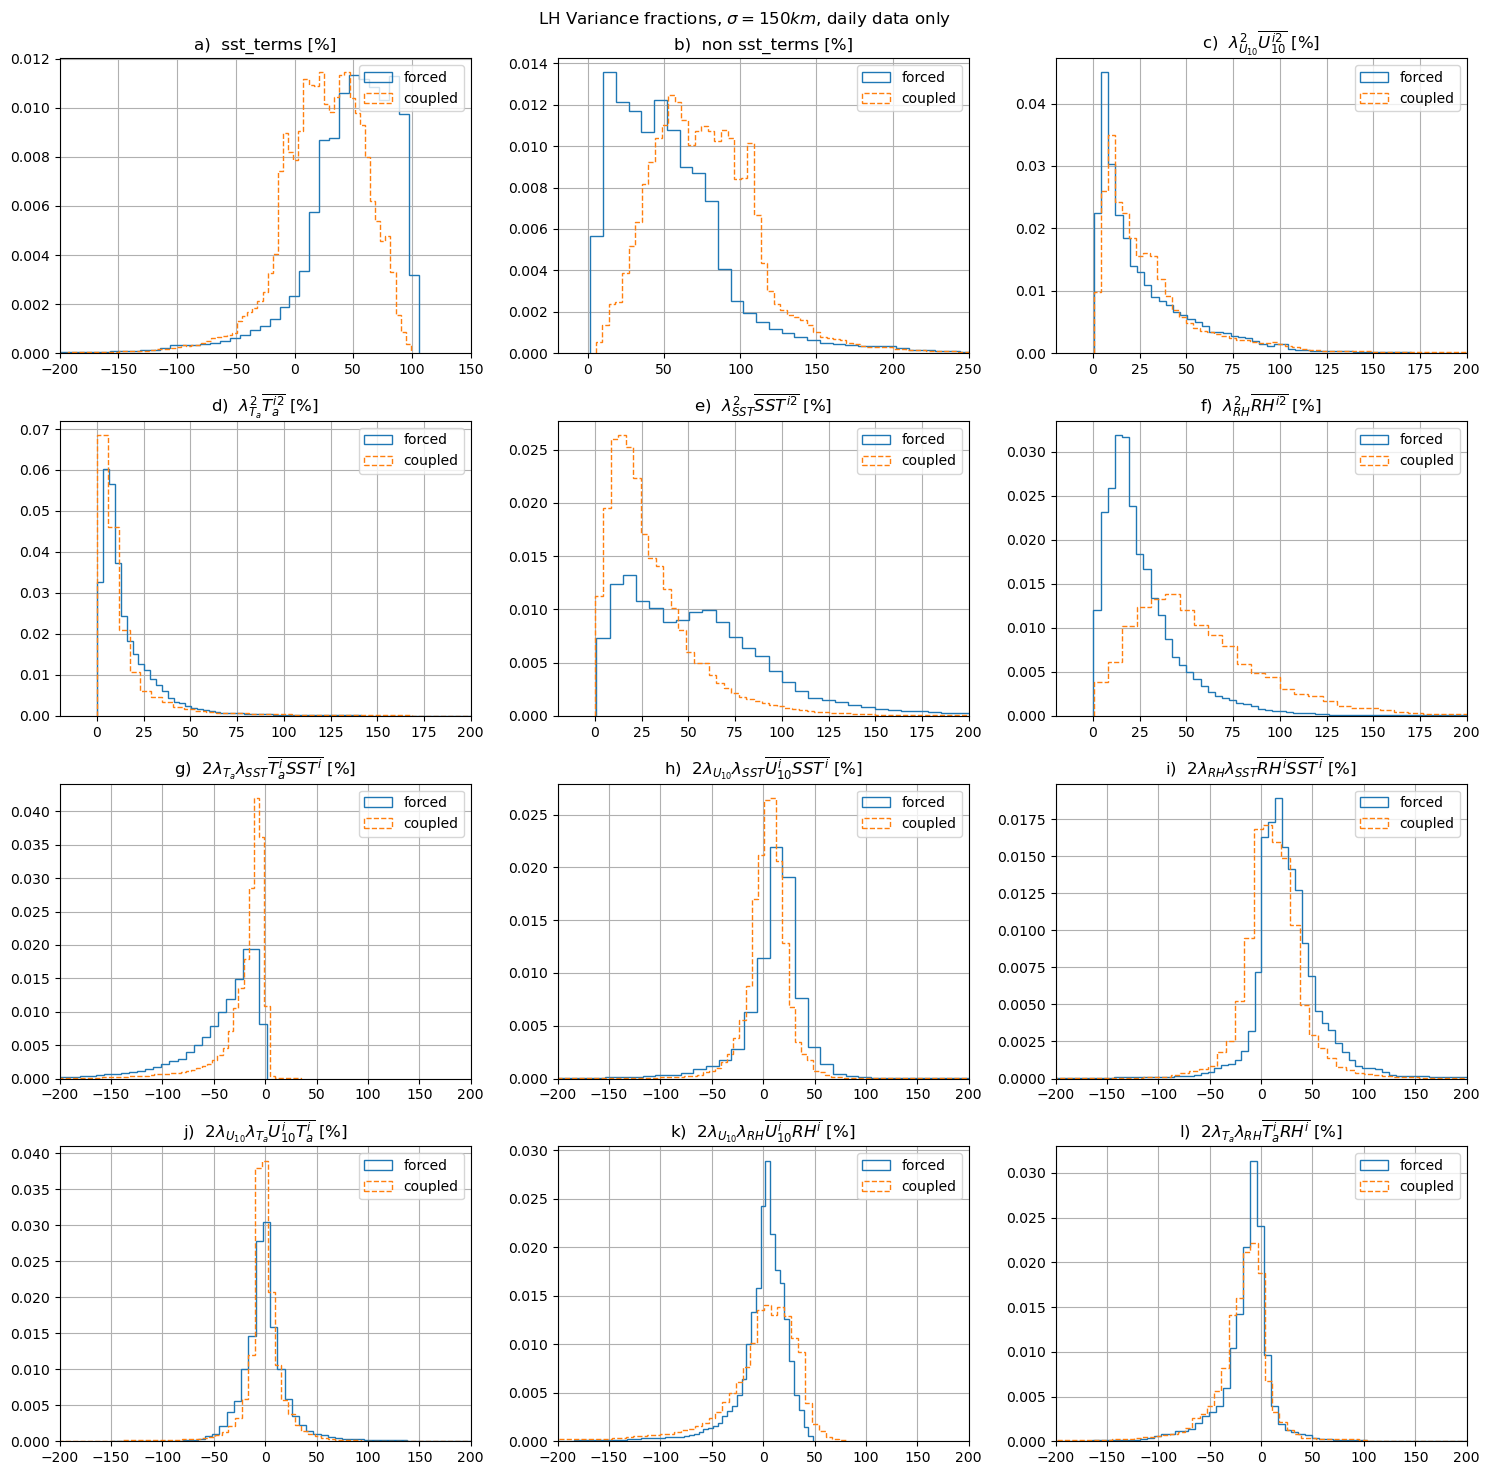

In [78]:

    
import matplotlib.pyplot as plt
import xarray as xr

xperc = 200
bins = 50*2
factor = 2


leg = ['forced', 'coupled']

fig, axs = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle(r'LH Variance fractions, $ \sigma = 150km $, daily data only')
axs = axs.flatten()

ax = axs[0]
ax.hist((sst_terms_for*100. / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((sst_terms_cou*100. / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-200, 150)
ax.set_title('a)  sst_terms [%]')
ax.legend(leg)

ax = axs[1]
ax.hist((non_sst_terms_for*100. / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((non_sst_terms_cou*100. / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-20, 250)
ax.set_title('b)  non sst_terms [%]')
ax.legend(leg)

ax = axs[2]
ax.hist((lambda_U_for**2 * var_U_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou**2 * var_U_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('c)  $\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')
ax.legend(leg)

ax = axs[3]
ax.hist((lambda_ta_for**2 * var_ta_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou**2 * var_ta_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('d)  $\\lambda_{T_a}^2 \\overline{T_{a}^{i2}}$ [%]')
ax.legend(leg)

ax = axs[4]
ax.hist((lambda_sst_for**2 *var_sst_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_sst_cou**2 * var_sst_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('e)  $\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')
ax.legend(leg)

ax = axs[5]
ax.hist((lambda_RH_for**2 * var_RH_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_RH_cou**2 * var_RH_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('f)  $\\lambda_{RH}^2 \\overline{RH^{i2}}$ [%]')
ax.legend(leg)

ax = axs[6]
ax.hist((lambda_ta_for * lambda_sst_for * covar_ta_sst_for*100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou * lambda_sst_cou * covar_ta_sst_cou*100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
title = r"g)  $\\lambda_{T_a}\\lambda_{SST} \\overline{T_{a}^{i}SST^i}$ [%]" if (factor==1) else r"g)  $2 \lambda_{T_a} \lambda_{SST} \overline{T_{a}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[7]
ax.hist((lambda_U_for * lambda_sst_for * covar_U_sst_for*100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_sst_cou * covar_U_sst_cou*100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
title = r"h)  $\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]" if (factor==1) else r"h)  $2 \lambda_{U_{10}} \lambda_{SST} \overline{U_{10}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[8]
ax.hist((lambda_RH_for * lambda_sst_for * covar_RH_sst_for*100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_RH_cou * lambda_sst_cou * covar_RH_sst_cou*100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
title = r"i)  $\\lambda_{RH}\\lambda_{SST} \\overline{RH^{i}SST^i}$ [%]" if (factor==1) else  r"i)  $2 \lambda_{RH} \lambda_{SST} \overline{RH^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[9]
ax.hist((lambda_U_for * lambda_ta_for * covar_U_ta_for *100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_ta_cou * covar_U_ta_cou *100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
title = r"j)  $\\lambda_{U_{10}}\\lambda_{T_a} \\overline{U_{10}^{i}T_a^i}$ [%]" if (factor==1) else r"j)  $2 \lambda_{U_{10}} \lambda_{T_a} \overline{U_{10}^{i}T_a^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[10]
ax.hist((lambda_U_for * lambda_RH_for * covar_U_RH_for *100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_RH_cou * covar_U_RH_cou *100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
title = r"k)  $\\lambda_{U_{10}}\\lambda_{RH} \\overline{U_{10}^{i}RH^i}$ [%]" if (factor==1) else r"k)  $2 \lambda_{U_{10}} \lambda_{RH} \overline{U_{10}^{i}RH^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[11]
ax.hist((lambda_ta_for * lambda_RH_for * covar_ta_RH_for *100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou * lambda_RH_cou * covar_ta_RH_cou *100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
title = r"l)  $\\lambda_{T_a}\\lambda_{RH} \\overline{T_a^{i}RH^i}$ [%]" if (factor==1) else r"l)  $2 \lambda_{T_a} \lambda_{RH} \overline{T_a^{i}RH^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    

plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/VarLHF_SingleTerms_lhfRH_bandpass_daily.png')


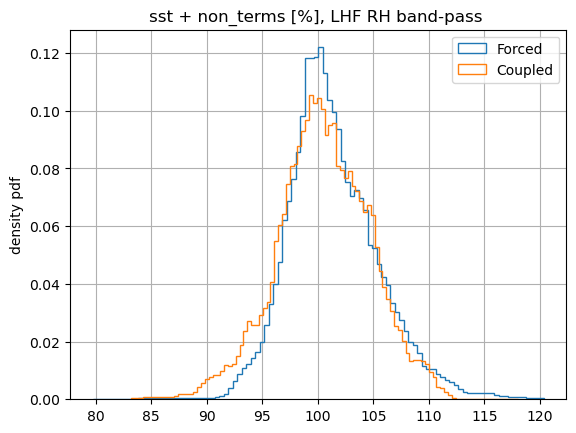

In [80]:
### missing plot among these above

plt.hist( (var_lhf_sum_for*100/var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='Forced')
plt.hist( (var_lhf_sum_cou*100/var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Coupled')
plt.title(r"sst + non_terms [%], LHF RH band-pass ")
plt.legend(); plt.grid()
plt.ylabel('density pdf')

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/VarLHF_TOT_lhfRH_bandpass_daily.png')

plt.show()

# THIS IS FOR THE DIRECT FORMULATION

In [8]:
ds_cou = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/ALE_band-pass_lhfDIR_dailyMeans_all.nc')
ds_for = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_band-pass_lhfDIR_dailyMeans_all.nc')


lambda_U_for = ds_for['lambda_U'].values
lambda_sst_for = ds_for['lambda_sst'].values
lambda_q_for = ds_for['lambda_q'].values
lambda_ta_for = ds_for['lambda_ta'].values
lambda_RH_for = ds_for['lambda_RH'].values

var_lhf_for = ds_for['var_lhf'].values
var_qa_for = ds_for['var_qa'].values
var_U_for = ds_for['var_U'].values
var_ta_for = ds_for['var_ta'].values
var_RH_for = ds_for['var_RH'].values
covar_U_ta_for = ds_for['covar_U_ta'].values
covar_U_RH_for = ds_for['covar_U_RH'].values
covar_ta_RH_for = ds_for['covar_ta_RH'].values
covar_U_q_for = ds_for['covar_U_q'].values

# sst terms
var_sst_for = ds_for['var_sst'].values
covar_ta_sst_for = ds_for['covar_ta_sst'].values
covar_U_sst_for = ds_for['covar_U_sst'].values
covar_RH_sst_for = ds_for['covar_RH_sst'].values
covar_q_sst_for = ds_for['covar_q_sst'].values



sst_terms_for = (lambda_sst_for**2*var_sst_for + 2*lambda_sst_for*(lambda_U_for*covar_U_sst_for + lambda_q_for*covar_q_sst_for ))
non_sst_terms_for = (lambda_U_for**2*var_U_for + lambda_q_for**2*var_qa_for + 2*lambda_q_for*lambda_U_for*covar_U_q_for)
var_lhf_sum_for = sst_terms_for + non_sst_terms_for




# Variables for ds_cou
lambda_U_cou = ds_cou['lambda_U'].values
lambda_sst_cou = ds_cou['lambda_sst'].values
lambda_q_cou = ds_cou['lambda_q'].values
lambda_ta_cou = ds_cou['lambda_ta'].values
lambda_RH_cou = ds_cou['lambda_RH'].values

var_lhf_cou = ds_cou['var_lhf'].values
var_qa_cou = ds_cou['var_qa'].values
var_U_cou = ds_cou['var_U'].values
var_ta_cou = ds_cou['var_ta'].values
var_RH_cou = ds_cou['var_RH'].values
covar_U_ta_cou = ds_cou['covar_U_ta'].values
covar_U_RH_cou = ds_cou['covar_U_RH'].values
covar_ta_RH_cou = ds_cou['covar_ta_RH'].values
covar_U_q_cou = ds_cou['covar_U_q'].values

# sst terms
var_sst_cou = ds_cou['var_sst'].values
covar_ta_sst_cou = ds_cou['covar_ta_sst'].values
covar_U_sst_cou = ds_cou['covar_U_sst'].values
covar_RH_sst_cou = ds_cou['covar_RH_sst'].values
covar_q_sst_cou = ds_cou['covar_q_sst'].values


sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou + lambda_q_cou*covar_q_sst_cou ))
non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_q_cou**2*var_qa_cou + 2*lambda_q_cou*lambda_U_cou*covar_U_q_cou)
var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou


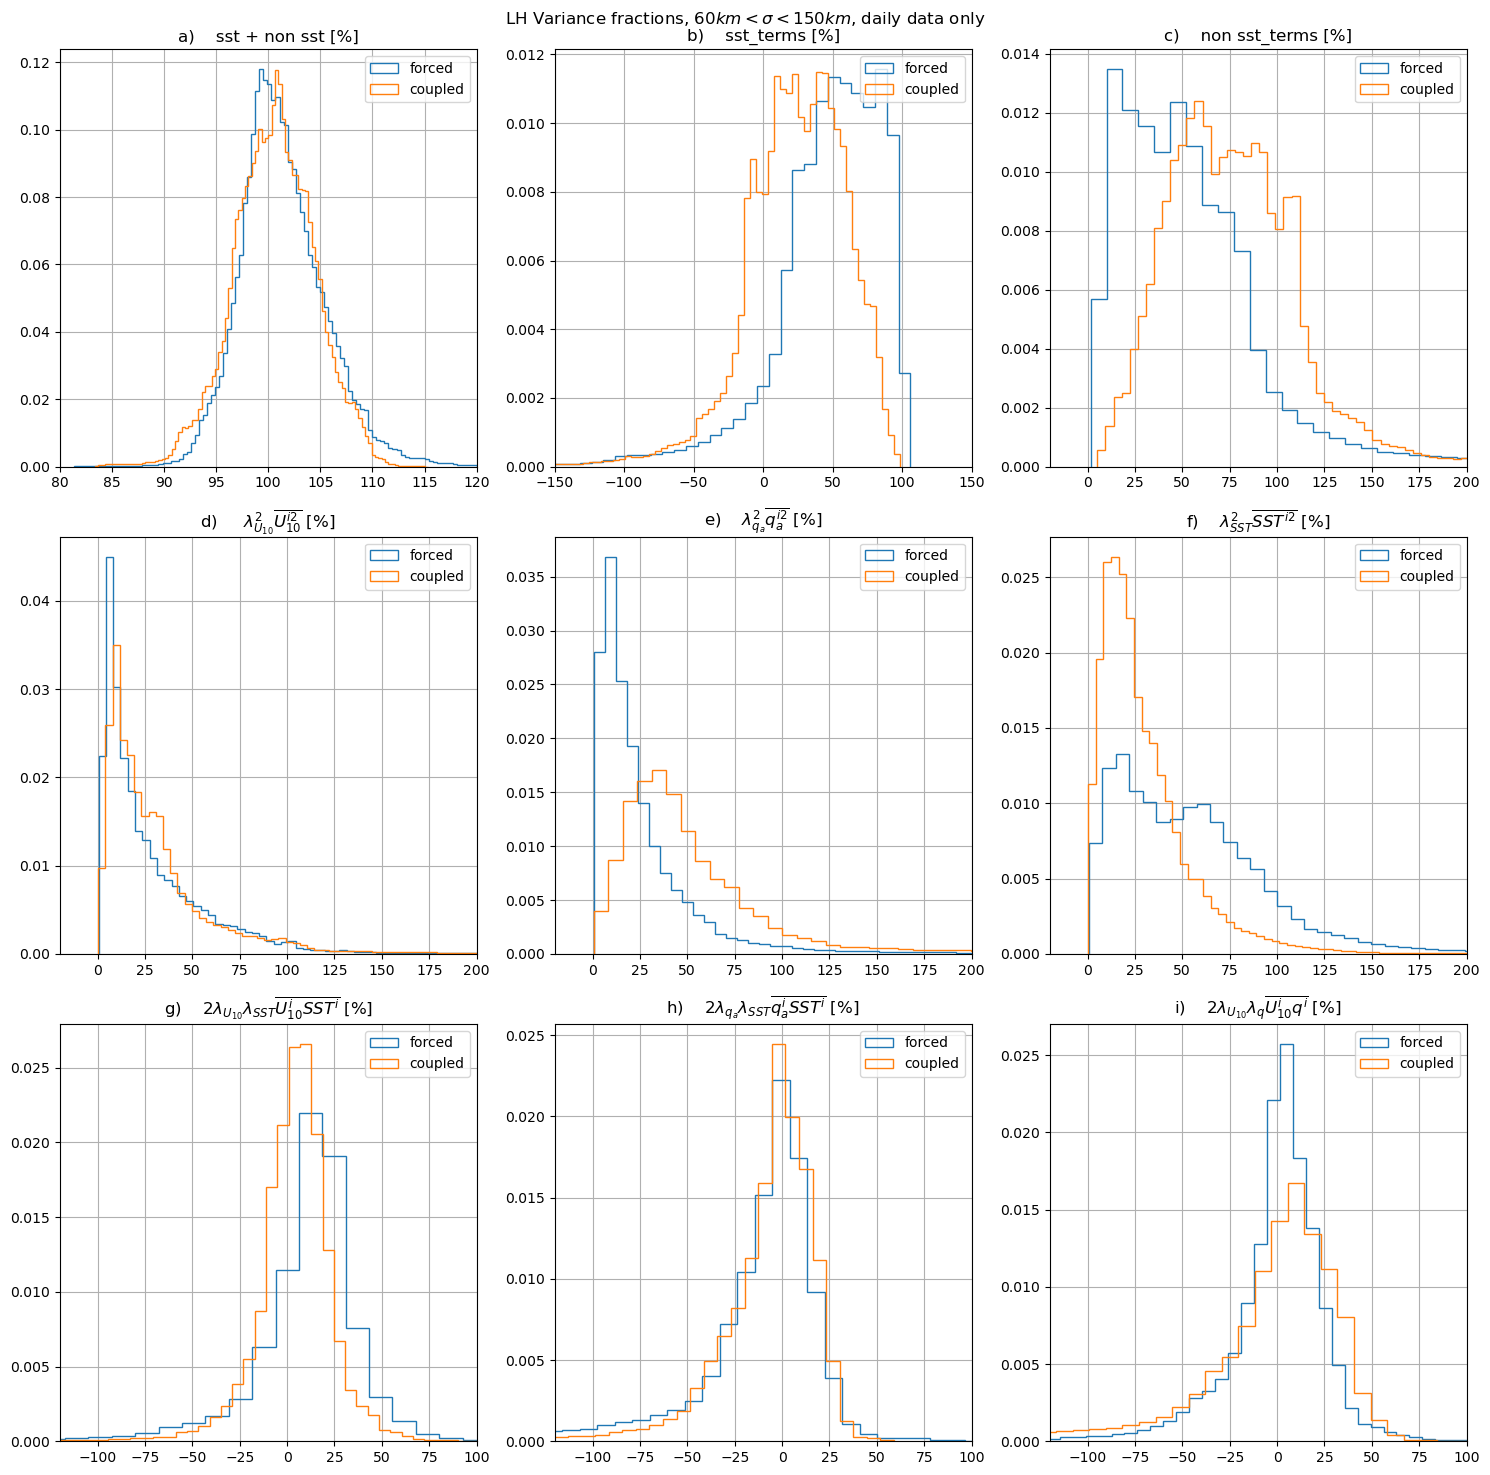

In [66]:


xperc=150
bins=100
factor = 2

leg = ['forced', 'coupled']

fig, axs = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(r'LH Variance fractions, $60km < \sigma < 150km $, daily data only')
axs = axs.flatten()

ax=axs[0]
ax.hist((var_lhf_sum_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((var_lhf_sum_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(80,120)
ax.set_title('a)    sst + non sst [%]')
ax.legend(leg)

ax=axs[1]
ax.hist((sst_terms_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((sst_terms_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-150,150)
ax.set_title('b)    sst_terms [%]')
ax.legend(leg)

ax=axs[2]
ax.hist((non_sst_terms_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((non_sst_terms_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-20,200)
ax.set_title('c)    non sst_terms [%]')
ax.legend(leg)

ax=axs[3]
ax.hist((lambda_U_for**2*var_U_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou**2*var_U_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-20,200)
ax.set_title('d)     $\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')
ax.legend(leg)

ax=axs[4]
ax.hist((lambda_q_for**2*var_qa_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_q_cou**2*var_qa_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-20,200)
ax.set_title('e)    $\\lambda_{q_a}^2 \\overline{q_{a}^{i2}}$ [%]')
ax.legend(leg)

ax=axs[5]
ax.hist((lambda_sst_for**2*var_sst_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_sst_cou**2*var_sst_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-20,200)
ax.set_title('f)    $\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')
ax.legend(leg)

ax=axs[6]
ax.hist((lambda_U_for*lambda_sst_for*covar_U_sst_for*100*factor/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou*lambda_sst_cou*covar_U_sst_cou*100*factor/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-120,100)
title = r"g)    $\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]" if (factor==1) else r"g)    $2 \lambda_{U_{10}} \lambda_{SST} \overline{U_{10}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax=axs[7]
ax.hist((lambda_q_for*lambda_sst_for*covar_q_sst_for*100*factor/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_q_cou*lambda_sst_cou*covar_q_sst_cou*100*factor/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-120,100)
title = r"h)    $\\lambda_{q_{a}}\\lambda_{SST} \\overline{q_{a}^{i}SST^i}$ [%]" if (factor==1) else r"h)    $2 \lambda_{q_{a}} \lambda_{SST} \overline{q_{a}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax=axs[8]
ax.hist((lambda_U_for*lambda_q_for*covar_U_q_for*100*factor/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou*lambda_q_cou*covar_U_q_cou*100*factor/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-120,100)
title=r"i)    $\\lambda_{U_{10}}\\lambda_{q} \\overline{U_{10}^{i}q^i}$ [%]" if (factor==1) else r"i)    $2 \lambda_{U_{10}} \lambda_{q} \overline{U_{10}^{i}q^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

plt.tight_layout()

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/band-pass/VarLHF_SingleTerms_lhfDIR_bandpass_daily.png')



# Plots for high-pass

rh_sst and ta_sst are 0
-0.01040504150300503
q_sst is 0
-0.012023994271624927
rh_sst and ta_sst are 0
-0.0354517501888818
q_sst is 0
-0.03574823814768724


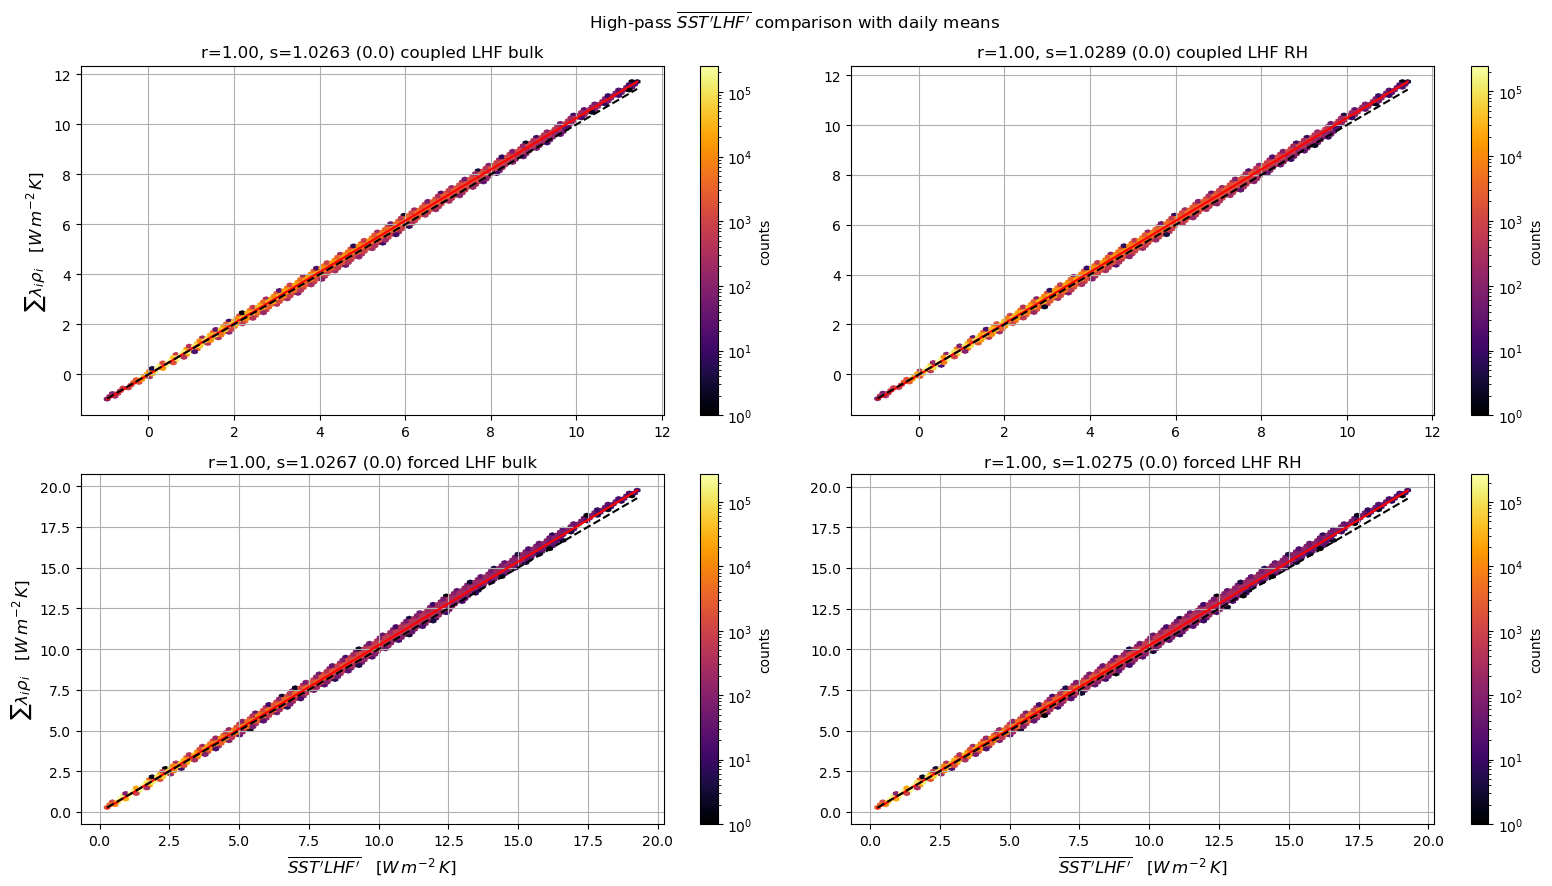

In [36]:
bins = 50

passalto_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*passalto*')
passalto_files = sorted(passalto_files)

fig, ax =  plt.subplots(2,2, figsize=(16,9))
fig.suptitle(r"High-pass $\overline{SST'LHF'}$ comparison with daily means")



for i in range(len(passalto_files)):
    ds = xr.open_dataset(passalto_files[i])
    
    u_sst = ds['lambda_U'].values*ds['covar_U_sst'].values
    sst_sst = ds['lambda_sst'].values*ds['var_sst'].values 
    q_sst = ds['lambda_q'].values*ds['covar_q_sst'].values
    ta_sst = ds['lambda_ta'].values*ds['covar_ta_sst'].values 
    rh_sst = ds['lambda_RH'].values*ds['covar_RH_sst'].values
    
    if np.all(rh_sst[~np.isnan(rh_sst)]==0.) and np.all(ta_sst[~np.isnan(ta_sst)]==0.):
        print('rh_sst and ta_sst are 0')
        del rh_sst, ta_sst
        covar_sum = sst_sst + u_sst + q_sst
    elif np.all(q_sst[~np.isnan(q_sst)]==0.):
        print('q_sst is 0')
        del q_sst
        covar_sum = u_sst + sst_sst + ta_sst + rh_sst
        
    
    covar_lhf_sst = ds['covar_lhf_sst'].values
    
    
    j,k = divmod(i,2)
    xlab = r"$\overline{SST' LHF'}$   [$W \, m^{-2} \, K$]" if j==1 else ''
    ylab = '$\\sum \\lambda_i \\rho_i$   [$W \, m^{-2} \, K$]' if k==0 else ''
    
    RH = True if 'lhfRH' in passalto_files[i].split('/')[-1] else False
    RH = ' LHF RH' if RH else ' LHF bulk'
    
    coupled = True if 'ALE' in passalto_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    density_scatter_ax(ax=ax[j,k], x=covar_lhf_sst, y=covar_sum, \
                       xlabel=xlab, ylabel=ylab, minititle=coupled+RH, cmap='inferno')

plt.tight_layout()



# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/SSTLHF_covariance_passalto_daily.png')

rh_sst and ta_sst are 0
q_sst is 0
rh_sst and ta_sst are 0
q_sst is 0


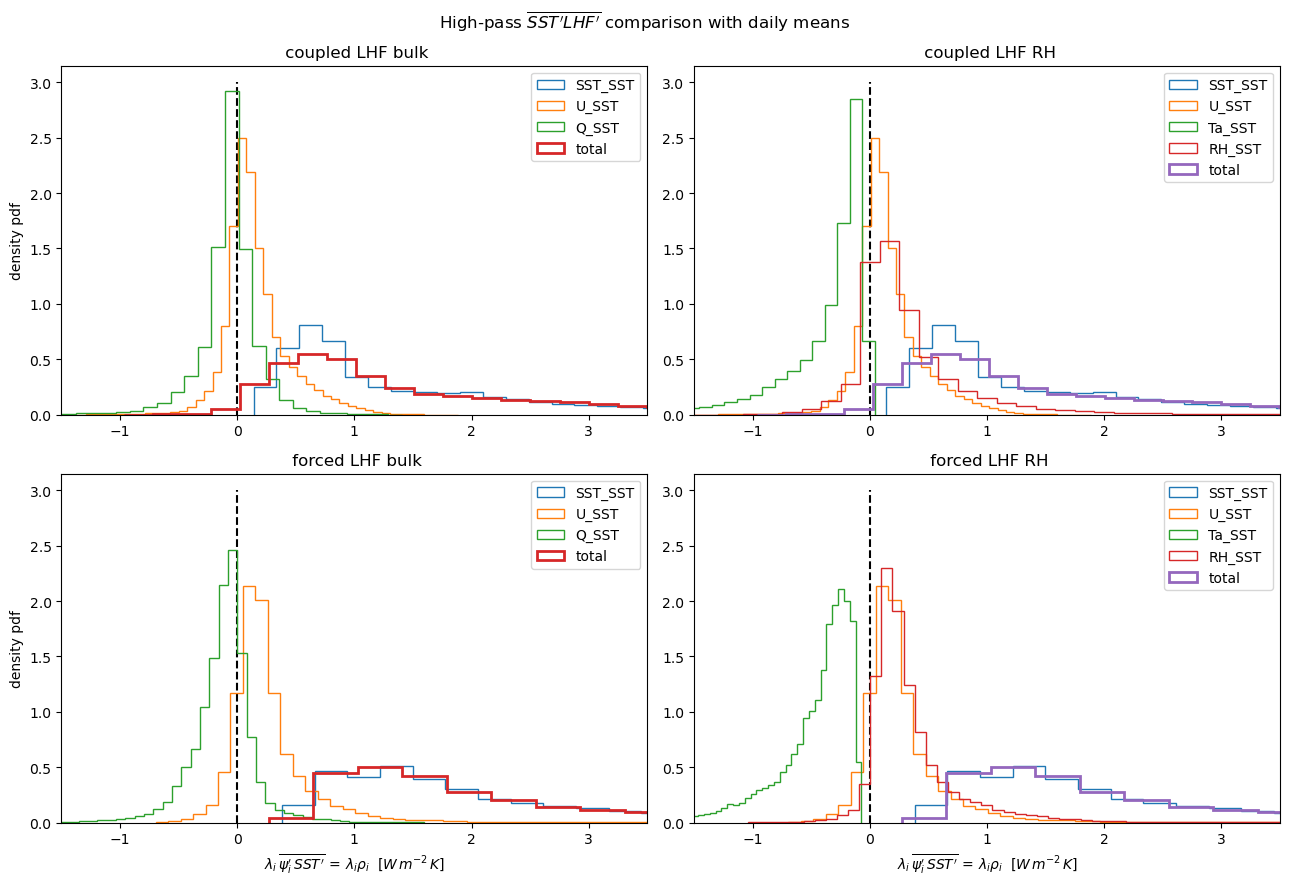

In [44]:
passalto_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*passalto*')
passalto_files = sorted(passalto_files)

fig, ax =  plt.subplots(2,2, figsize=(13,9))
fig.suptitle(r"High-pass $\overline{SST'LHF'}$ comparison with daily means")


def histogram_local(ax,bins, variabs, labels, title, axlabs):
    for i in range(len(variabs)):
        lnwd = 1
        if i+1 == len(variabs):
            lnwd = 2
        ax.hist((variabs[i]).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labs)
        ax.set_xlim(-1.5,3.5)
        ax.set_title(title)
        ax.set_xlabel(axlabs[0]); ax.set_ylabel(axlabs[1])


for i in range(len(passalto_files)):
    ds = xr.open_dataset(passalto_files[i])
    
    u_sst = ds['lambda_U'].values*ds['covar_U_sst'].values
    sst_sst = ds['lambda_sst'].values*ds['var_sst'].values 
    q_sst = ds['lambda_q'].values*ds['covar_q_sst'].values
    ta_sst = ds['lambda_ta'].values*ds['covar_ta_sst'].values 
    rh_sst = ds['lambda_RH'].values*ds['covar_RH_sst'].values
    covar_lhf_sst = ds['covar_lhf_sst'].values
    
    if np.all(rh_sst[~np.isnan(rh_sst)]==0.) and np.all(ta_sst[~np.isnan(ta_sst)]==0.):
        print('rh_sst and ta_sst are 0')
        del rh_sst, ta_sst
        var_list = [sst_sst, u_sst, q_sst, covar_lhf_sst]
        labs = ['SST_SST', 'U_SST', 'Q_SST', 'total']
        
    elif np.all(q_sst[~np.isnan(q_sst)]==0.):
        print('q_sst is 0')
        del q_sst
        var_list = [sst_sst, u_sst, ta_sst, rh_sst, covar_lhf_sst]        
        labs = ['SST_SST', 'U_SST', 'Ta_SST', 'RH_SST', 'total']
    
    
    
    j,k = divmod(i,2)
    xlab = r"$\lambda_i \, \overline{\psi_i' \, SST'}\,=\,\lambda_i \rho_i$  [$W \, m^{-2} \, K$]" if j==1 else ''
    ylab = 'density pdf' if k==0 else ''
    
    
    RH = True if 'lhfRH' in passalto_files[i].split('/')[-1] else False
    RH = ' LHF RH' if RH else ' LHF bulk'
    
    coupled = True if 'ALE' in passalto_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    histogram_local(ax = ax[j,k], bins=50, variabs=var_list, labels=labs, title=coupled+RH, axlabs = [xlab,ylab])
    ax[j,k].vlines(0., ymin=0, ymax=3, color='k', linestyle='--')
    
    
plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/SSTLHF_SingleTerms_covariance_passalto_daily.png')

## U'LHF' highpass

In [20]:
passalto_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW*passalto*_all*')
passalto_files = sorted(passalto_files)
passalto_files

['/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_ALE_passalto_lhfDIR_dailyMeans_all.nc',
 '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_ALE_passalto_lhfRH_dailyMeans_all.nc',
 '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_MATTE_passalto_lhfDIR_dailyMeans_all.nc',
 '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_MATTE_passalto_lhfRH_dailyMeans_all.nc']

rh_u and ta_u are 0
q_U is 0
rh_u and ta_u are 0
q_U is 0


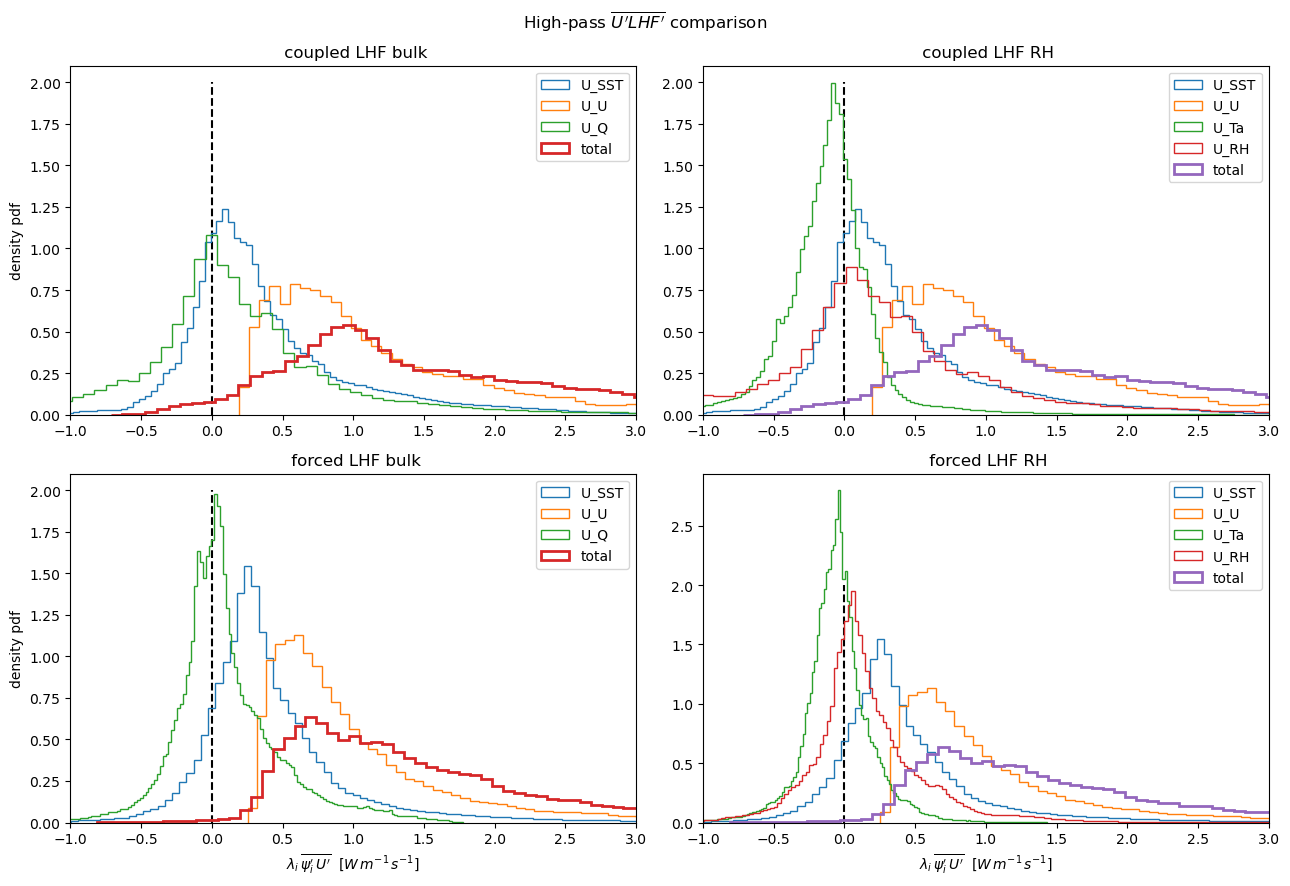

In [12]:
passalto_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW*passalto*_all*')
passalto_files = sorted(passalto_files)

fig, ax =  plt.subplots(2,2, figsize=(13,9))
fig.suptitle(r"High-pass $\overline{U'LHF'}$ comparison")


def histogram_local(ax,bins, variabs, labels, title, axlabs):
    for i in range(len(variabs)):
        lnwd = 1
        if i+1 == len(variabs):
            lnwd = 2
        ax.hist((variabs[i]).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labs)
        ax.set_xlim(-1,3)
        ax.set_title(title)
        ax.set_xlabel(axlabs[0]); ax.set_ylabel(axlabs[1])


for i in range(len(passalto_files)):
    ds = xr.open_dataset(passalto_files[i])
    
    u_sst = ds['lambda_sst'].values*ds['covar_U_sst'].values
    u_u = ds['lambda_U'].values*ds['var_U'].values
    q_u = ds['lambda_q'].values*ds['covar_U_q'].values
    ta_u = ds['lambda_ta'].values*ds['covar_U_ta'].values 
    rh_u = ds['lambda_RH'].values*ds['covar_U_RH'].values
    covar_lhf_u = ds['covar_U_lhf'].values

    if np.all(rh_u[~np.isnan(rh_u)]==0.) and np.all(ta_u[~np.isnan(ta_u)]==0.):
        print('rh_u and ta_u are 0')
        del rh_u, ta_u
        var_list = [u_sst, u_u, q_u, covar_lhf_u]
        labs = ['U_SST', 'U_U', 'U_Q', 'total']
        
    elif np.all(q_u[~np.isnan(q_u)]==0.):
        print('q_U is 0')
        del q_u
        var_list = [u_sst, u_u, ta_u, rh_u, covar_lhf_u]        
        labs = ['U_SST', 'U_U', 'U_Ta', 'U_RH', 'total']
    
    
    
    j,k = divmod(i,2)
    xlab = r"$\lambda_i \, \overline{\psi_i'\,U'}$  [$W \, m^{-1} \, s^{-1} $]" if j==1 else ''
    ylab = 'density pdf' if k==0 else ''
    
    
    RH = True if 'lhfRH' in passalto_files[i].split('/')[-1] else False
    RH = ' LHF RH' if RH else ' LHF bulk'
    
    coupled = True if 'ALE' in passalto_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    histogram_local(ax = ax[j,k], bins=200, variabs=var_list, labels=labs, title=coupled+RH, axlabs = [xlab,ylab])
    ax[j,k].vlines(0., ymin=0, ymax=2, color='k', linestyle='--')
#     print(coupled+RH+f' median of total variance = {np.percentile(covar_lhf_u[~np.isnan(covar_lhf_u)], 50)}')
    
    
plt.tight_layout()



# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/ULHF_SingleTerms_covariance_passalto_daily.png')



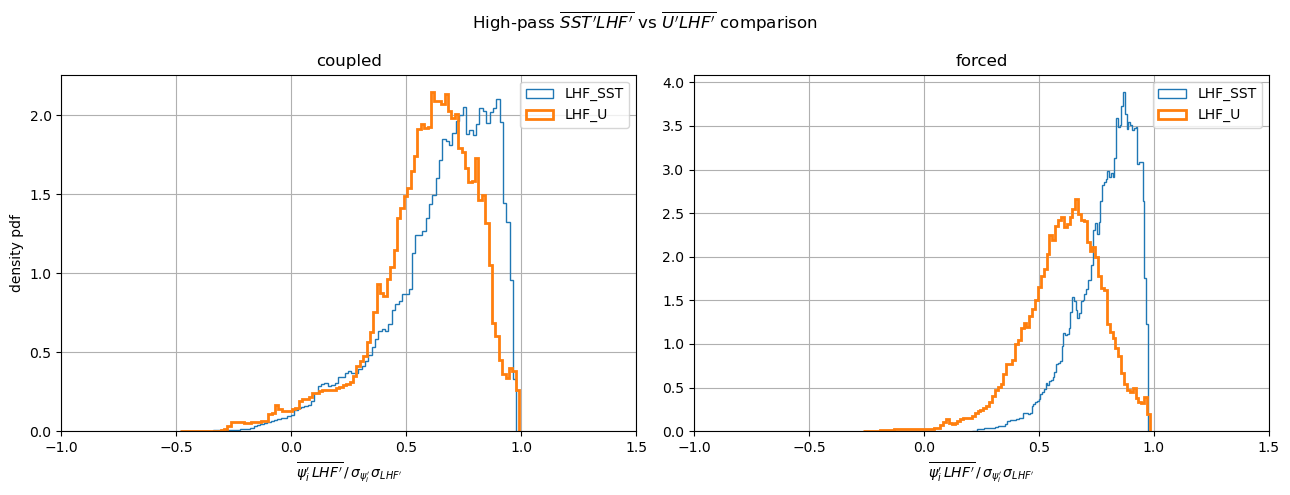

In [29]:
passaaaalto_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW*passalto*lhfDIR*_all.nc')
passaaaalto_files = sorted(passaaaalto_files)

fig, ax =  plt.subplots(1,2, figsize=(13,5))
fig.suptitle(r"High-pass $\overline{SST'LHF'}$ vs $\overline{U'LHF'}$ comparison")


def histogram_local(ax,bins, variabs, labels, title, axlabs):
    for i in range(len(variabs)):
        lnwd = 1
        if i+1 == len(variabs):
            lnwd = 2
        ax.hist((variabs[i]).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labs)
        ax.set_xlim(-1,1.5)
        ax.set_title(title)
        ax.set_xlabel(axlabs[0]); ax.set_ylabel(axlabs[1])
        


for i in range(len(passaaaalto_files)):
    ds = xr.open_dataset(passaaaalto_files[i])
    
    sst_sst = ds['var_sst'].values
    u_u = ds['var_U'].values
    
    lhf_lhf = ds['var_lhf'].values
    
    norm_covar_lhf_sst = ds['covar_lhf_sst'].values/(np.sqrt(sst_sst*lhf_lhf))
    norm_covar_lhf_u = ds['covar_U_lhf'].values/(np.sqrt(u_u*lhf_lhf))
    
    var_list = [norm_covar_lhf_sst, norm_covar_lhf_u]        
    labs = ['LHF_SST', 'LHF_U']
    
    xlab = r"$ \overline{\psi_i'\,LHF'}\,/\,\sigma_{\psi_i'}\,\sigma_{LHF'}$"
    ylab = 'density pdf' if i==0 else ''
    
    coupled = True if 'ALE' in passaaaalto_files[i].split('/')[-1] else False
    coupled = 'coupled' if coupled else 'forced'
    
    histogram_local(ax = ax[i], bins=100, variabs=var_list, labels=labs, title=coupled, axlabs = [xlab,ylab])
    ax[i].grid()
    #ax[i].vlines(0., ymin=0, ymax=1, color='k', linestyle='--')
    
plt.tight_layout()



# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/ULHF_vs_SSTLHF_passalto_daily.png')



## U'LHF' vs SST ' LHF' bp vs hp all models

a) HP 0 is the 1.2604253202104543  percentile
a) BP 0 is the 12.65241970684727  percentile

c) HP 0 is the 2.381963707135135  percentile
c) BP 0 is the 7.759598491213084  percentile

b) HP 0 is the 0.0  percentile
b) BP 0 is the 2.6863255971341604  percentile

d) HP 0 is the 0.4710779726089494  percentile
d) BP 0 is the 5.057464170354224  percentile



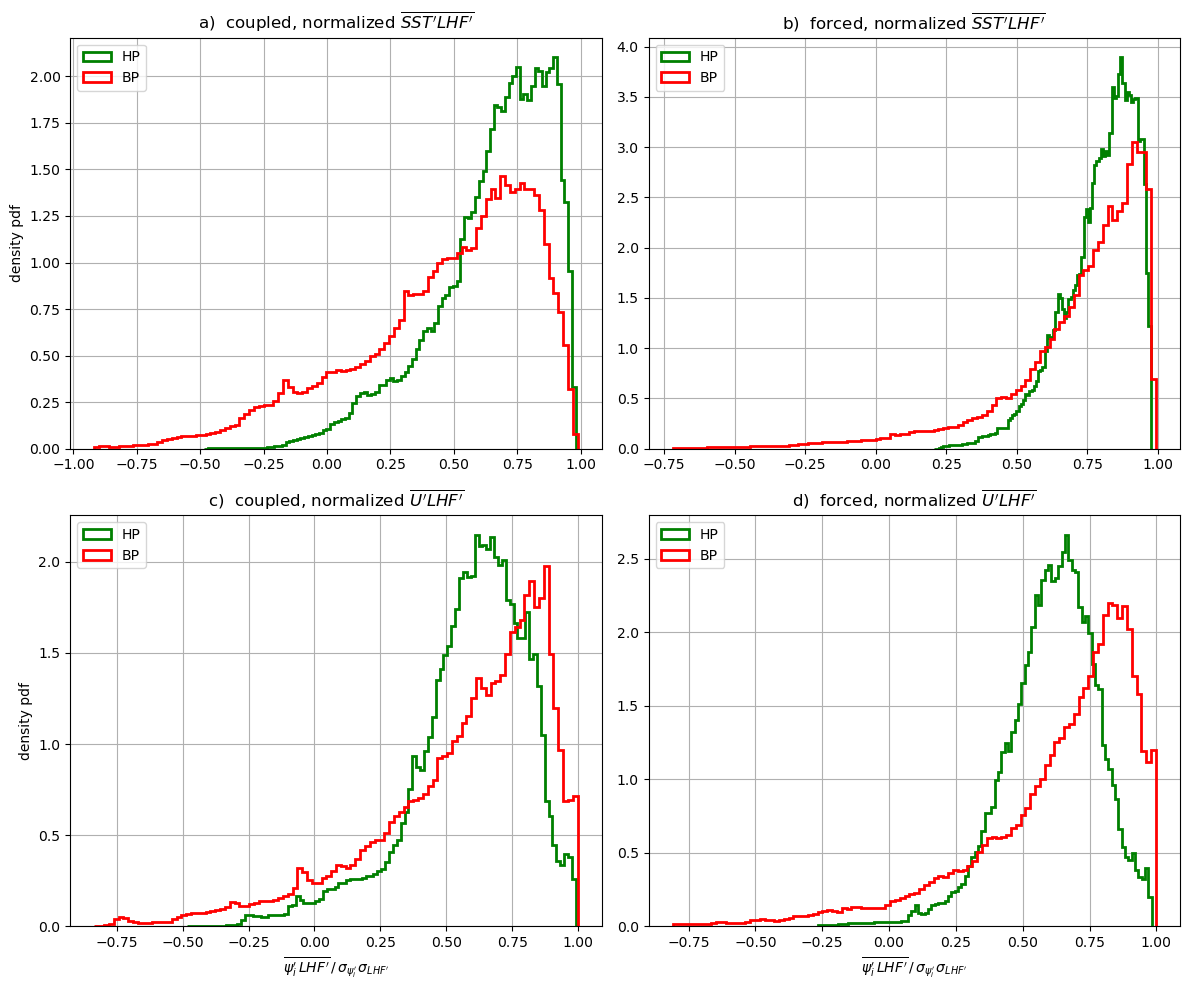

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
bins = 100

base_path = '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/'

# Titles for the subplots
titles = [
    r"a)  coupled, normalized $\overline{SST'LHF'}$",
    r"b)  forced, normalized $\overline{SST'LHF'}$",
    r"c)  coupled, normalized $\overline{U'LHF'}$",
    r"d)  forced, normalized $\overline{U'LHF'}$"
]

fname_cou_hp, fname_cou_bp = 'NEW_ALE_passalto_lhfDIR_dailyMeans_all.nc', 'NEW_ALE_band-pass_lhfDIR_dailyMeans_all.nc'

ds_hp = xr.open_dataset(base_path+fname_cou_hp)
ds_bp = xr.open_dataset(base_path+fname_cou_bp)

lhf_lhf_hp = ds_hp['var_lhf'].values
lhf_lhf_bp = ds_bp['var_lhf'].values


#######################   COUPLED   ##############################

axs[0, 0].set_title(titles[0])
sst_sst_hp = ds_hp['var_sst'].values
sst_sst_bp = ds_bp['var_sst'].values
    
norm_covar_lhf_sst_hp = ds_hp['covar_lhf_sst'].values/(np.sqrt(sst_sst_hp*lhf_lhf_hp))
norm_covar_lhf_sst_bp = ds_bp['covar_lhf_sst'].values/(np.sqrt(sst_sst_bp*lhf_lhf_bp))

axs[0, 0].hist((norm_covar_lhf_sst_hp).flatten(),bins=bins,histtype=u'step',density=True, label='HP', color='green', linewidth=2 )
axs[0, 0].hist((norm_covar_lhf_sst_bp).flatten(),bins=bins,histtype=u'step',density=True, label='BP', color='red', linewidth=2)
axs[0, 0].grid();   axs[0, 0].legend(); 
axs[0,0].set_ylabel('density pdf')
print(f'a) HP 0 is the {find_percentile((norm_covar_lhf_sst_hp[~np.isnan(norm_covar_lhf_sst_hp)]).flatten(), 0.)}  percentile')
print(f'a) BP 0 is the {find_percentile((norm_covar_lhf_sst_bp[~np.isnan(norm_covar_lhf_sst_bp)]).flatten(), 0.)}  percentile\n')

# Second row, first column
axs[1, 0].set_title(titles[2])
u_u_hp = ds_hp['var_U'].values
u_u_bp = ds_bp['var_U'].values
    
norm_covar_lhf_u_hp = ds_hp['covar_U_lhf'].values/(np.sqrt(u_u_hp*lhf_lhf_hp))
norm_covar_lhf_u_bp = ds_bp['covar_U_lhf'].values/(np.sqrt(u_u_bp*lhf_lhf_bp))

axs[1, 0].hist((norm_covar_lhf_u_hp).flatten(),bins=bins,histtype=u'step',density=True, label='HP', color='green', linewidth=2)
axs[1, 0].hist((norm_covar_lhf_u_bp).flatten(),bins=bins,histtype=u'step',density=True, label='BP', color='red', linewidth=2)
axs[1, 0].grid();   axs[1, 0].legend(); 
axs[1,0].set_xlabel(r"$ \overline{\psi_i'\,LHF'}\,/\,\sigma_{\psi_i'}\,\sigma_{LHF'}$")
axs[1,0].set_ylabel('density pdf')
print(f'c) HP 0 is the {find_percentile((norm_covar_lhf_u_hp[~np.isnan(norm_covar_lhf_u_hp)]).flatten(), 0.)}  percentile')
print(f'c) BP 0 is the {find_percentile((norm_covar_lhf_u_bp[~np.isnan(norm_covar_lhf_u_bp)]).flatten(), 0.)}  percentile\n')

#####################  END OF COUPLED  ########################





fname_for_hp, fname_for_bp = 'NEW_MATTE_passalto_lhfDIR_dailyMeans_all.nc', 'NEW_MATTE_band-pass_lhfDIR_dailyMeans_all.nc'

ds_hp = xr.open_dataset(base_path+fname_for_hp)
ds_bp = xr.open_dataset(base_path+fname_for_bp)

lhf_lhf_hp = ds_hp['var_lhf'].values
lhf_lhf_bp = ds_bp['var_lhf'].values



####################### FORCED  #############à#########à

axs[0, 1].set_title(titles[1])
sst_sst_hp = ds_hp['var_sst'].values
sst_sst_bp = ds_bp['var_sst'].values
    
norm_covar_lhf_sst_hp = ds_hp['covar_lhf_sst'].values/(np.sqrt(sst_sst_hp*lhf_lhf_hp))
norm_covar_lhf_sst_bp = ds_bp['covar_lhf_sst'].values/(np.sqrt(sst_sst_bp*lhf_lhf_bp))

axs[0, 1].hist((norm_covar_lhf_sst_hp).flatten(),bins=bins,histtype=u'step',density=True, label='HP', color='green', linewidth=2)
axs[0, 1].hist((norm_covar_lhf_sst_bp).flatten(),bins=bins,histtype=u'step',density=True, label='BP', color='red', linewidth=2)
axs[0, 1].grid();   axs[0, 1].legend(); 
print(f'b) HP 0 is the {find_percentile((norm_covar_lhf_sst_hp[~np.isnan(norm_covar_lhf_sst_hp)]).flatten(), 0.)}  percentile')
print(f'b) BP 0 is the {find_percentile((norm_covar_lhf_sst_bp[~np.isnan(norm_covar_lhf_sst_bp)]).flatten(), 0.)}  percentile\n')


axs[1, 1].set_title(titles[3])
u_u_hp = ds_hp['var_U'].values
u_u_bp = ds_bp['var_U'].values
    
norm_covar_lhf_u_hp = ds_hp['covar_U_lhf'].values/(np.sqrt(u_u_hp*lhf_lhf_hp))
norm_covar_lhf_u_bp = ds_bp['covar_U_lhf'].values/(np.sqrt(u_u_bp*lhf_lhf_bp))

axs[1, 1].hist((norm_covar_lhf_u_hp).flatten(),bins=bins,histtype=u'step',density=True, label='HP', color='green', linewidth=2)
axs[1, 1].hist((norm_covar_lhf_u_bp).flatten(),bins=bins,histtype=u'step',density=True, label='BP', color='red', linewidth=2)
axs[1, 1].grid();   axs[1, 1].legend(); 
axs[1,1].set_xlabel(r"$ \overline{\psi_i'\,LHF'}\,/\,\sigma_{\psi_i'}\,\sigma_{LHF'}$")
print(f'd) HP 0 is the {find_percentile((norm_covar_lhf_u_hp[~np.isnan(norm_covar_lhf_u_hp)]).flatten(), 0.)}  percentile')
print(f'd) BP 0 is the {find_percentile((norm_covar_lhf_u_bp[~np.isnan(norm_covar_lhf_u_bp)]).flatten(), 0.)}  percentile\n')

################## END OF FORCED  #######################


# Adjust layout for better spacing
plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/ULHF_vs_SSTLHF_HPvsBP_daily.png')



rh_sst and ta_sst are 0
-0.0013524691504471775
q_sst is 0
0.01218585606960687
rh_sst and ta_sst are 0
-3.642328179987942
q_sst is 0
-3.7659459201012737


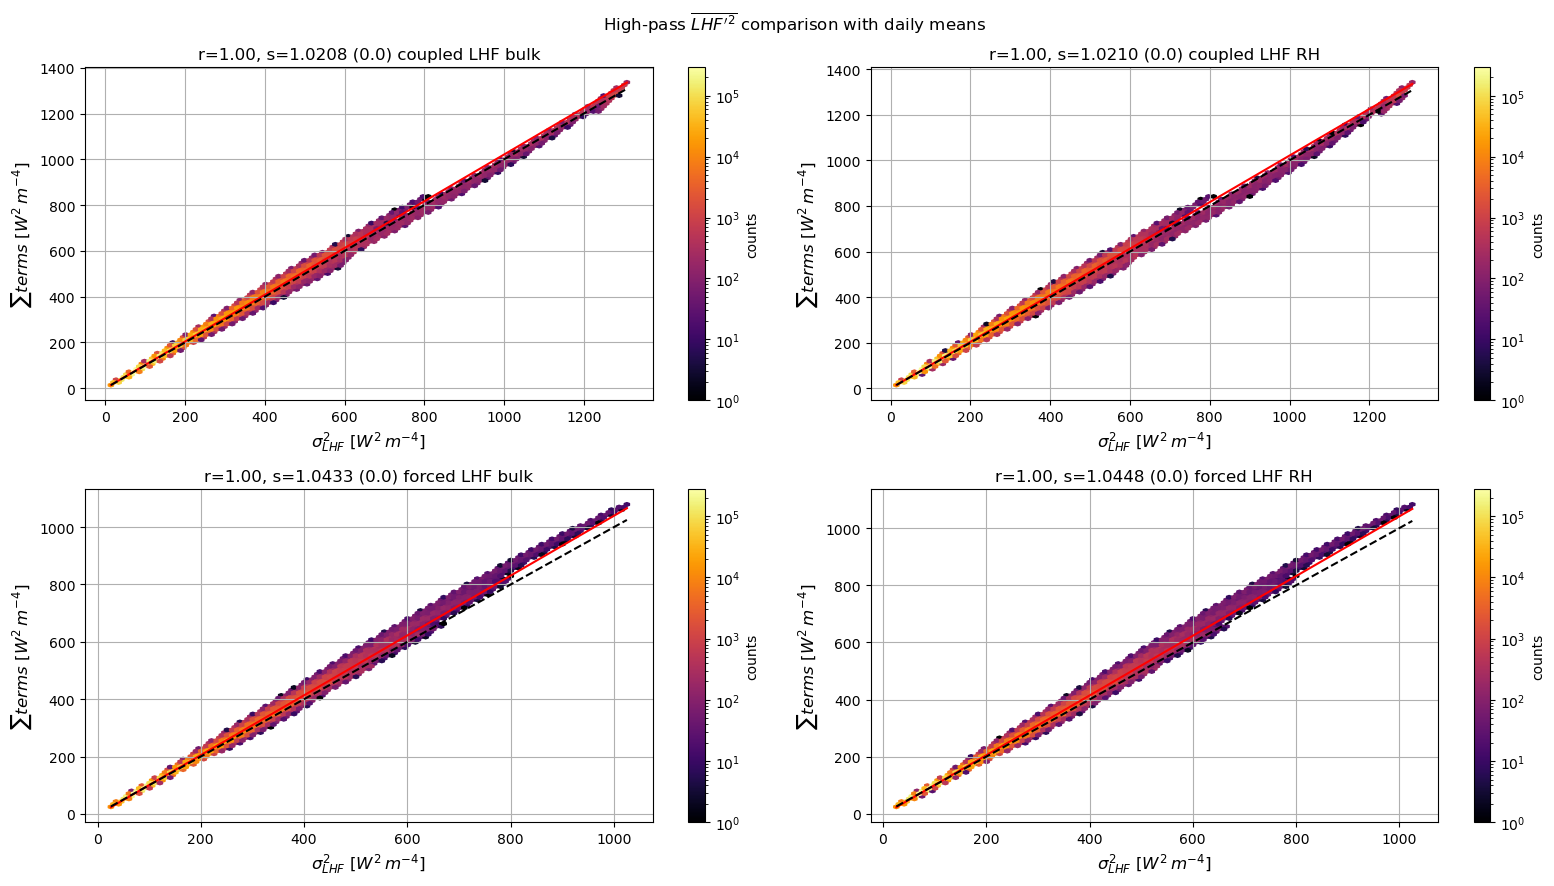

In [47]:
bins = 50

passalto_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*passalto*')
passalto_files = sorted(passalto_files)

fig, ax =  plt.subplots(2,2, figsize=(16,9))
fig.suptitle(r"High-pass $\overline{LHF'^2}$ comparison with daily means")


for i in range(len(passalto_files)):
    ds = xr.open_dataset(passalto_files[i])
    
    lambda_U = ds['lambda_U'].values
    lambda_sst = ds['lambda_sst'].values
    lambda_q = ds['lambda_q'].values
    lambda_ta = ds['lambda_ta'].values
    lambda_RH = ds['lambda_RH'].values
    
    var_lhf = ds['var_lhf'].values
    var_qa = ds['var_qa'].values 
    var_U = ds['var_U'].values 
    var_ta = ds['var_ta'].values 
    var_RH = ds['var_RH'].values 
    covar_U_ta = ds['covar_U_ta'].values 
    covar_U_RH = ds['covar_U_RH'].values 
    covar_ta_RH = ds['covar_ta_RH'].values 
    covar_U_q = ds['covar_U_q'].values 
    
    # sst terms
    var_sst = ds['var_sst'].values 
    covar_ta_sst = ds['covar_ta_sst'].values 
    covar_U_sst = ds['covar_U_sst'].values
    covar_RH_sst = ds['covar_RH_sst'].values
    covar_q_sst = ds['covar_q_sst'].values
    
    
    if np.all(lambda_RH[~np.isnan(lambda_RH)]==0.) and np.all(lambda_ta[~np.isnan(lambda_ta)]==0.):
        print('rh_sst and ta_sst are 0')
        del lambda_RH, lambda_ta, var_ta, var_RH, covar_U_ta, covar_U_RH, covar_ta_RH
        
        sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst + lambda_q*covar_q_sst))
        non_sst_terms = (lambda_U**2*var_U + lambda_q**2*var_qa + 2*lambda_q*lambda_U*covar_U_q)
        var_lhf_sum = sst_terms + non_sst_terms
    
    elif np.all(lambda_q[~np.isnan(lambda_q)]==0.):
        print('q_sst is 0')
        del lambda_q, covar_U_q, covar_q_sst, var_qa
        
        sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst))
        non_sst_terms = (lambda_U**2*var_U + lambda_ta**2*var_ta + lambda_RH**2*var_RH + 
                         2*lambda_U*lambda_ta*covar_U_ta + 2*lambda_U*lambda_RH*covar_U_RH + 2*lambda_ta*lambda_RH*covar_ta_RH)
        var_lhf_sum = sst_terms + non_sst_terms
        
    
    #covar_lhf_sst = ds['covar_lhf_sst'].values
    
    
    j,k = divmod(i,2)
    RH = True if 'lhfRH' in passalto_files[i].split('/')[-1] else False
    RH = ' LHF RH' if RH else ' LHF bulk'
    
    coupled = True if 'ALE' in passalto_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    density_scatter_ax(ax=ax[j,k], x=var_lhf, y=var_lhf_sum, \
                       xlabel='$\\sigma_{LHF}^2$ [$W^2\,m^{-4}$]', ylabel='$\\sum terms$ [$W^2\,m^{-4}$]',\
                       minititle=coupled+RH, cmap='inferno')

plt.tight_layout()





# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/VarLHF_passalto_daily.png')



####### coupled only
# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/coupled_only/VarLHF_passalto_daily_coupled.png')



# RH high pass

In [81]:
ds_cou = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/ALE_passalto_150_lhfRH_dailyMeans_all.nc')
ds_for = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_passalto_lhfRH_dailyMeans_all.nc')


lambda_U_for = ds_for['lambda_U'].values
lambda_sst_for = ds_for['lambda_sst'].values
lambda_q_for = ds_for['lambda_q'].values
lambda_ta_for = ds_for['lambda_ta'].values
lambda_RH_for = ds_for['lambda_RH'].values

var_lhf_for = ds_for['var_lhf'].values
var_qa_for = ds_for['var_qa'].values
var_U_for = ds_for['var_U'].values
var_ta_for = ds_for['var_ta'].values
var_RH_for = ds_for['var_RH'].values
covar_U_ta_for = ds_for['covar_U_ta'].values
covar_U_RH_for = ds_for['covar_U_RH'].values
covar_ta_RH_for = ds_for['covar_ta_RH'].values
covar_U_q_for = ds_for['covar_U_q'].values

# sst terms
var_sst_for = ds_for['var_sst'].values
covar_ta_sst_for = ds_for['covar_ta_sst'].values
covar_U_sst_for = ds_for['covar_U_sst'].values
covar_RH_sst_for = ds_for['covar_RH_sst'].values
covar_q_sst_for = ds_for['covar_q_sst'].values


sst_terms_for = (lambda_sst_for**2*var_sst_for + 2*lambda_sst_for*(lambda_U_for*covar_U_sst_for + \
                                                                   lambda_ta_for*covar_ta_sst_for + \
                                                                   lambda_RH_for*covar_RH_sst_for ))
non_sst_terms_for = (lambda_U_for**2*var_U_for + lambda_ta_for**2*var_ta_for + lambda_RH_for**2*var_RH_for + 
                     2*lambda_U_for*lambda_ta_for*covar_U_ta_for + 2*lambda_U_for*lambda_RH_for*covar_U_RH_for + \
                     2*lambda_ta_for*lambda_RH_for*covar_ta_RH_for)
var_lhf_sum_for = sst_terms_for + non_sst_terms_for





# Variables for ds_cou
lambda_U_cou = ds_cou['lambda_U'].values
lambda_sst_cou = ds_cou['lambda_sst'].values
lambda_q_cou = ds_cou['lambda_q'].values
lambda_ta_cou = ds_cou['lambda_ta'].values
lambda_RH_cou = ds_cou['lambda_RH'].values

var_lhf_cou = ds_cou['var_lhf'].values
var_qa_cou = ds_cou['var_qa'].values
var_U_cou = ds_cou['var_U'].values
var_ta_cou = ds_cou['var_ta'].values
var_RH_cou = ds_cou['var_RH'].values
covar_U_ta_cou = ds_cou['covar_U_ta'].values
covar_U_RH_cou = ds_cou['covar_U_RH'].values
covar_ta_RH_cou = ds_cou['covar_ta_RH'].values
covar_U_q_cou = ds_cou['covar_U_q'].values

# sst terms
var_sst_cou = ds_cou['var_sst'].values
covar_ta_sst_cou = ds_cou['covar_ta_sst'].values
covar_U_sst_cou = ds_cou['covar_U_sst'].values
covar_RH_sst_cou = ds_cou['covar_RH_sst'].values
covar_q_sst_cou = ds_cou['covar_q_sst'].values


# sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou +\
#                                                                    lambda_q_cou*covar_q_sst_cou ))
# non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_q_cou**2*var_qa_cou + 2*lambda_q_cou*lambda_U_cou*covar_U_q_cou)
# var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou




sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou + \
                                                                   lambda_ta_cou*covar_ta_sst_cou + \
                                                                   lambda_RH_cou*covar_RH_sst_cou ))
non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_ta_cou**2*var_ta_cou + lambda_RH_cou**2*var_RH_cou + 
                     2*lambda_U_cou*lambda_ta_cou*covar_U_ta_cou + 2*lambda_U_cou*lambda_RH_cou*covar_U_RH_cou + \
                     2*lambda_ta_cou*lambda_RH_cou*covar_ta_RH_cou)
var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou




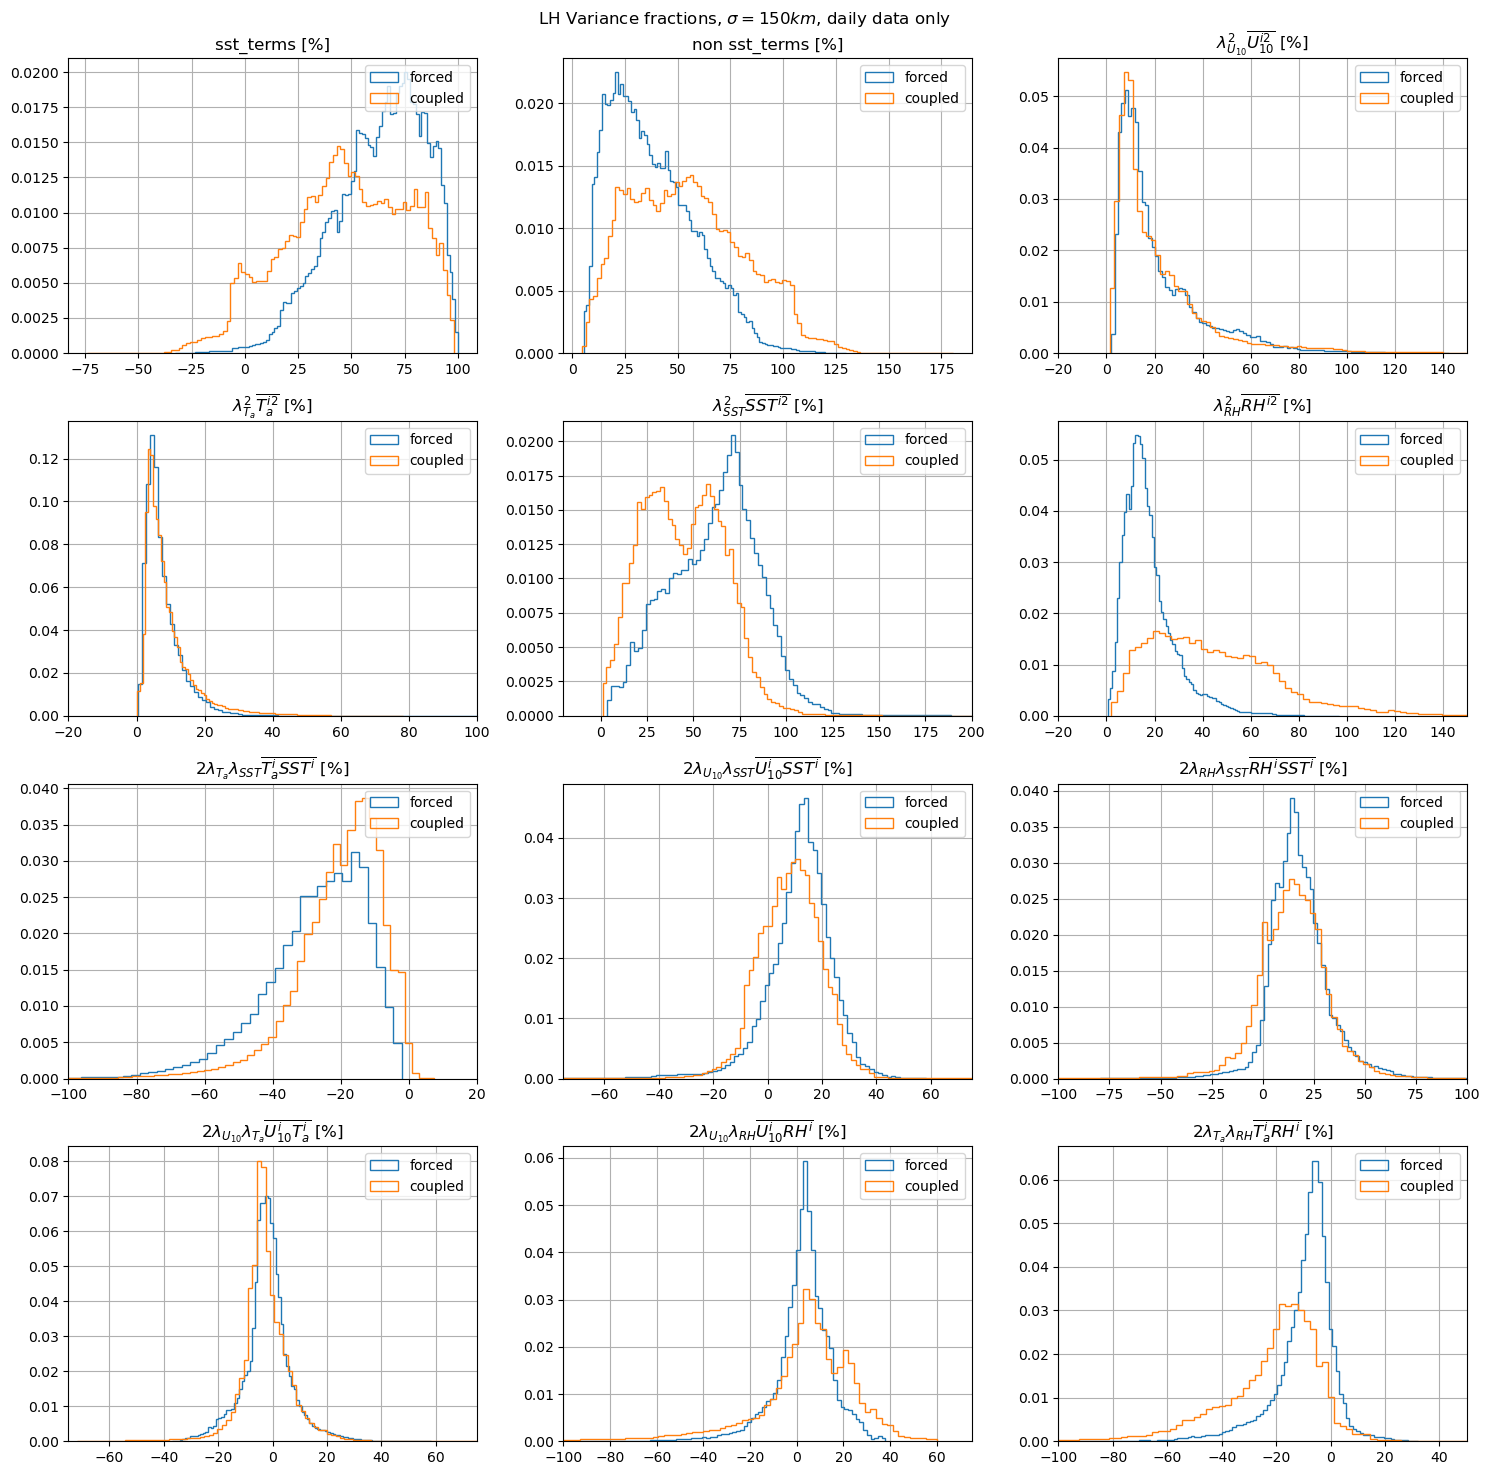

In [82]:

    
import matplotlib.pyplot as plt
import xarray as xr

xperc = 150
bins = 50*2
factor = 2


leg = ['forced', 'coupled']

fig, axs = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle(r'LH Variance fractions, $ \sigma = 150km $, daily data only')
axs = axs.flatten()

ax = axs[0]
ax.hist((sst_terms_for*100. / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((sst_terms_cou*100. / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
# ax.set_xlim(-50, 150)
ax.set_title('sst_terms [%]')
ax.legend(leg)

ax = axs[1]
ax.hist((non_sst_terms_for*100. / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((non_sst_terms_cou*100. / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
# ax.set_xlim(-20, 150)
ax.set_title('non sst_terms [%]')
ax.legend(leg)

ax = axs[2]
ax.hist((lambda_U_for**2 * var_U_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou**2 * var_U_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-20, 150)
ax.set_title('$\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')
ax.legend(leg)

ax = axs[3]
ax.hist((lambda_ta_for**2 * var_ta_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou**2 * var_ta_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-20, 100)
ax.set_title('$\\lambda_{T_a}^2 \\overline{T_{a}^{i2}}$ [%]')
ax.legend(leg)

ax = axs[4]
ax.hist((lambda_sst_for**2 *var_sst_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_sst_cou**2 * var_sst_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('$\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')
ax.legend(leg)

ax = axs[5]
ax.hist((lambda_RH_for**2 * var_RH_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_RH_cou**2 * var_RH_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-20, 150)
ax.set_title('$\\lambda_{RH}^2 \\overline{RH^{i2}}$ [%]')
ax.legend(leg)

ax = axs[6]
ax.hist((lambda_ta_for * lambda_sst_for * covar_ta_sst_for*100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou * lambda_sst_cou * covar_ta_sst_cou*100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-100, 20)
title = r"$\\lambda_{T_a}\\lambda_{SST} \\overline{T_{a}^{i}SST^i}$ [%]" if (factor==1) else r"$2 \lambda_{T_a} \lambda_{SST} \overline{T_{a}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[7]
ax.hist((lambda_U_for * lambda_sst_for * covar_U_sst_for*100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_sst_cou * covar_U_sst_cou*100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-75, 75)
title = r"$\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]" if (factor==1) else r"$2 \lambda_{U_{10}} \lambda_{SST} \overline{U_{10}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[8]
ax.hist((lambda_RH_for * lambda_sst_for * covar_RH_sst_for*100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_RH_cou * lambda_sst_cou * covar_RH_sst_cou*100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-100, 100)
title = r"$\\lambda_{RH}\\lambda_{SST} \\overline{RH^{i}SST^i}$ [%]" if (factor==1) else  r"$2 \lambda_{RH} \lambda_{SST} \overline{RH^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[9]
ax.hist((lambda_U_for * lambda_ta_for * covar_U_ta_for *100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_ta_cou * covar_U_ta_cou *100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-75, 75)
title = r"$\\lambda_{U_{10}}\\lambda_{T_a} \\overline{U_{10}^{i}T_a^i}$ [%]" if (factor==1) else r"$2 \lambda_{U_{10}} \lambda_{T_a} \overline{U_{10}^{i}T_a^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[10]
ax.hist((lambda_U_for * lambda_RH_for * covar_U_RH_for *100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_RH_cou * covar_U_RH_cou *100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-100, 75)
title = r"$\\lambda_{U_{10}}\\lambda_{RH} \\overline{U_{10}^{i}RH^i}$ [%]" if (factor==1) else r"$2 \lambda_{U_{10}} \lambda_{RH} \overline{U_{10}^{i}RH^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax = axs[11]
ax.hist((lambda_ta_for * lambda_RH_for * covar_ta_RH_for *100*factor / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou * lambda_RH_cou * covar_ta_RH_cou *100*factor / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou')
ax.grid()
ax.set_xlim(-100, 50)
title = r"$\\lambda_{T_a}\\lambda_{RH} \\overline{T_a^{i}RH^i}$ [%]" if (factor==1) else r"$2 \lambda_{T_a} \lambda_{RH} \overline{T_a^{i}RH^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    

plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/VarLHF_SingleTerms_lhfRH_passalto_daily.png')


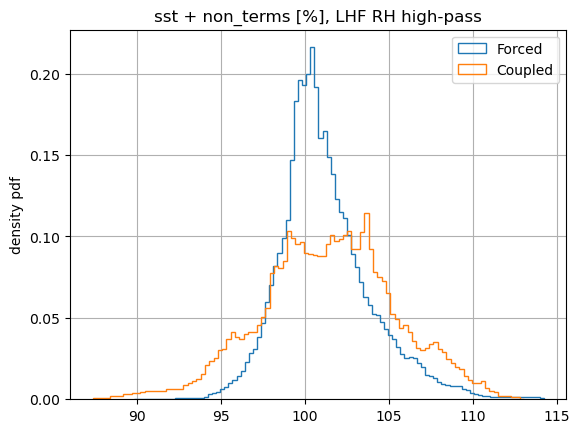

In [83]:
### missing plot among these above

plt.hist( (var_lhf_sum_for*100/var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='Forced')
plt.hist( (var_lhf_sum_cou*100/var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Coupled')
plt.title(r"sst + non_terms [%], LHF RH high-pass")
plt.legend(); plt.grid()
plt.ylabel('density pdf')

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/VarLHF_TOT_lhfRH_passalto_daily.png')

plt.show()


# DIR high pass

In [24]:
ds_cou = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/lambda_vars/ALE_passalto_150_dailyMeans_lhfDir.nc')
ds_for = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/lambda_vars/MATTE_passalto_150_dailyMeans_lhfDir.nc')


lambda_U_for = ds_for['lambda_U'].values
lambda_sst_for = ds_for['lambda_sst'].values
lambda_q_for = ds_for['lambda_q'].values
lambda_ta_for = ds_for['lambda_ta'].values
lambda_RH_for = ds_for['lambda_RH'].values

var_lhf_for = ds_for['var_lhf'].values
var_qa_for = ds_for['var_qa'].values
var_U_for = ds_for['var_U'].values
var_ta_for = ds_for['var_ta'].values
var_RH_for = ds_for['var_RH'].values
covar_U_ta_for = ds_for['covar_U_ta'].values
covar_U_RH_for = ds_for['covar_U_RH'].values
covar_ta_RH_for = ds_for['covar_ta_RH'].values
covar_U_q_for = ds_for['covar_U_q'].values

# sst terms
var_sst_for = ds_for['var_sst'].values
covar_ta_sst_for = ds_for['covar_ta_sst'].values
covar_U_sst_for = ds_for['covar_U_sst'].values
covar_RH_sst_for = ds_for['covar_RH_sst'].values
covar_q_sst_for = ds_for['covar_q_sst'].values


# sst_terms_for = (lambda_sst_for**2*var_sst_for + 2*lambda_sst_for*(lambda_U_for*covar_U_sst_for + \
#                                                                    lambda_ta_for*covar_ta_sst_for + \
#                                                                    lambda_RH_for*covar_RH_sst_for ))
# non_sst_terms_for = (lambda_U_for**2*var_U_for + lambda_ta_for**2*var_ta_for + lambda_RH_for**2*var_RH_for + 
#                      lambda_U_for*lambda_ta_for*covar_U_ta_for + lambda_U_for*lambda_RH_for*covar_U_RH_for + \
#                      lambda_ta_for*lambda_RH_for*covar_ta_RH_for)
# var_lhf_sum_for = sst_terms_for + non_sst_terms_for



sst_terms_for = (lambda_sst_for**2*var_sst_for + 2*lambda_sst_for*(lambda_U_for*covar_U_sst_for +\
                                                                   lambda_q_for*covar_q_sst_for ))
non_sst_terms_for = (lambda_U_for**2*var_U_for + lambda_q_for**2*var_qa_for + 2*lambda_q_for*lambda_U_for*covar_U_q_for)
var_lhf_sum_for = sst_terms_for + non_sst_terms_for




# Variables for ds_cou
lambda_U_cou = ds_cou['lambda_U'].values
lambda_sst_cou = ds_cou['lambda_sst'].values
lambda_q_cou = ds_cou['lambda_q'].values
lambda_ta_cou = ds_cou['lambda_ta'].values
lambda_RH_cou = ds_cou['lambda_RH'].values

var_lhf_cou = ds_cou['var_lhf'].values
var_qa_cou = ds_cou['var_qa'].values
var_U_cou = ds_cou['var_U'].values
var_ta_cou = ds_cou['var_ta'].values
var_RH_cou = ds_cou['var_RH'].values
covar_U_ta_cou = ds_cou['covar_U_ta'].values
covar_U_RH_cou = ds_cou['covar_U_RH'].values
covar_ta_RH_cou = ds_cou['covar_ta_RH'].values
covar_U_q_cou = ds_cou['covar_U_q'].values

# sst terms
var_sst_cou = ds_cou['var_sst'].values
covar_ta_sst_cou = ds_cou['covar_ta_sst'].values
covar_U_sst_cou = ds_cou['covar_U_sst'].values
covar_RH_sst_cou = ds_cou['covar_RH_sst'].values
covar_q_sst_cou = ds_cou['covar_q_sst'].values


sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou +\
                                                                   lambda_q_cou*covar_q_sst_cou ))
non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_q_cou**2*var_qa_cou + 2*lambda_q_cou*lambda_U_cou*covar_U_q_cou)
var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou


In [40]:
np.nanpercentile(lambda_sst_cou**2*var_sst_cou*100/var_lhf_cou, 60)

51.502505338738644

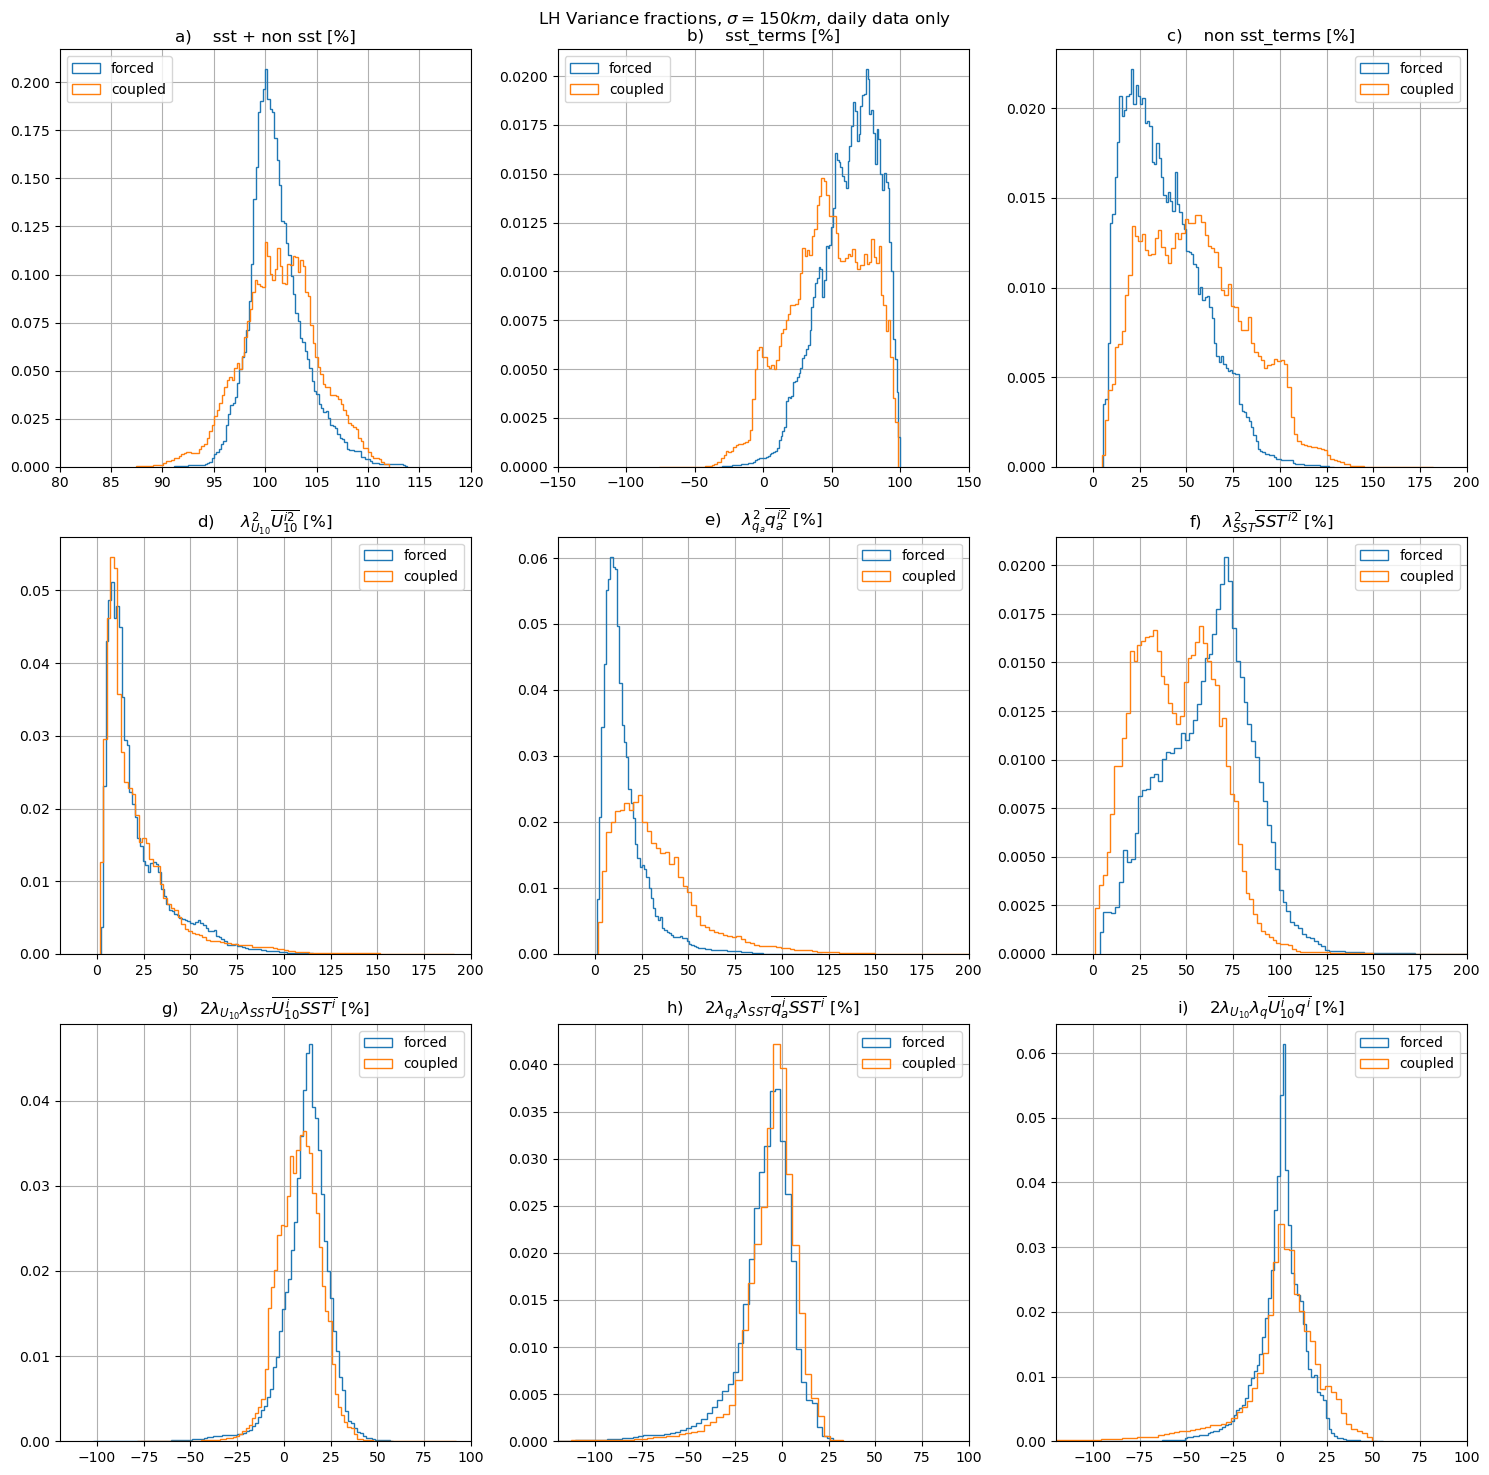

In [86]:

xperc=150
bins=100
factor = 2

leg = ['forced', 'coupled']

fig, axs = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(r'LH Variance fractions, $ \sigma = 150km $, daily data only')
axs = axs.flatten()

ax=axs[0]
ax.hist((var_lhf_sum_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((var_lhf_sum_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(80,120)
ax.set_title('a)    sst + non sst [%]')
ax.legend(leg)

ax=axs[1]
ax.hist((sst_terms_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((sst_terms_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-150,150)
ax.set_title('b)    sst_terms [%]')
ax.legend(leg)

ax=axs[2]
ax.hist((non_sst_terms_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((non_sst_terms_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-20,200)
ax.set_title('c)    non sst_terms [%]')
ax.legend(leg)

ax=axs[3]
ax.hist((lambda_U_for**2*var_U_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou**2*var_U_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-20,200)
ax.set_title('d)     $\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')
ax.legend(leg)

ax=axs[4]
ax.hist((lambda_q_for**2*var_qa_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_q_cou**2*var_qa_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-20,200)
ax.set_title('e)    $\\lambda_{q_a}^2 \\overline{q_{a}^{i2}}$ [%]')
ax.legend(leg)

ax=axs[5]
ax.hist((lambda_sst_for**2*var_sst_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_sst_cou**2*var_sst_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-20,200)
ax.set_title('f)    $\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')
ax.legend(leg)

ax=axs[6]
ax.hist((lambda_U_for*lambda_sst_for*covar_U_sst_for*100*factor/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou*lambda_sst_cou*covar_U_sst_cou*100*factor/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-120,100)
title = r"g)    $\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]" if (factor==1) else r"g)    $2 \lambda_{U_{10}} \lambda_{SST} \overline{U_{10}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax=axs[7]
ax.hist((lambda_q_for*lambda_sst_for*covar_q_sst_for*100*factor/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_q_cou*lambda_sst_cou*covar_q_sst_cou*100*factor/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-120,100)
title = r"h)    $\\lambda_{q_{a}}\\lambda_{SST} \\overline{q_{a}^{i}SST^i}$ [%]" if (factor==1) else r"h)    $2 \lambda_{q_{a}} \lambda_{SST} \overline{q_{a}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

ax=axs[8]
ax.hist((lambda_U_for*lambda_q_for*covar_U_q_for*100*factor/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou*lambda_q_cou*covar_U_q_cou*100*factor/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-120,100)
title=r"i)    $\\lambda_{U_{10}}\\lambda_{q} \\overline{U_{10}^{i}q^i}$ [%]" if (factor==1) else r"i)    $2 \lambda_{U_{10}} \lambda_{q} \overline{U_{10}^{i}q^i}$ [%]"
ax.set_title(title)
ax.legend(leg)

plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/VarLHF_SingleTerms_lhfDIR_passalto_daily.png')



# PUT HIGH + BAND PASS BULK ALL IN ONE

In [5]:
########### BANDPASSS BULK


ds_cou_bp = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/ALE_band-pass_lhfDIR_dailyMeans_all.nc')
ds_for_bp = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_band-pass_lhfDIR_dailyMeans_all.nc')


lambda_U_for_bp = ds_for_bp['lambda_U'].values
lambda_sst_for_bp = ds_for_bp['lambda_sst'].values
lambda_q_for_bp = ds_for_bp['lambda_q'].values
lambda_ta_for_bp = ds_for_bp['lambda_ta'].values
lambda_RH_for_bp = ds_for_bp['lambda_RH'].values

var_lhf_for_bp = ds_for_bp['var_lhf'].values
var_qa_for_bp = ds_for_bp['var_qa'].values
var_U_for_bp = ds_for_bp['var_U'].values
var_ta_for_bp = ds_for_bp['var_ta'].values
var_RH_for_bp = ds_for_bp['var_RH'].values
covar_U_ta_for_bp = ds_for_bp['covar_U_ta'].values
covar_U_RH_for_bp = ds_for_bp['covar_U_RH'].values
covar_ta_RH_for_bp = ds_for_bp['covar_ta_RH'].values
covar_U_q_for_bp = ds_for_bp['covar_U_q'].values

# sst terms
var_sst_for_bp = ds_for_bp['var_sst'].values
covar_ta_sst_for_bp = ds_for_bp['covar_ta_sst'].values
covar_U_sst_for_bp = ds_for_bp['covar_U_sst'].values
covar_RH_sst_for_bp = ds_for_bp['covar_RH_sst'].values
covar_q_sst_for_bp = ds_for_bp['covar_q_sst'].values



sst_terms_for_bp = (lambda_sst_for_bp**2*var_sst_for_bp + 2*lambda_sst_for_bp*(lambda_U_for_bp*covar_U_sst_for_bp + lambda_q_for_bp*covar_q_sst_for_bp ))
non_sst_terms_for_bp = (lambda_U_for_bp**2*var_U_for_bp + lambda_q_for_bp**2*var_qa_for_bp + 2*lambda_q_for_bp*lambda_U_for_bp*covar_U_q_for_bp)
var_lhf_sum_for_bp = sst_terms_for_bp + non_sst_terms_for_bp




# Variables for ds_cou_bp
lambda_U_cou_bp = ds_cou_bp['lambda_U'].values
lambda_sst_cou_bp = ds_cou_bp['lambda_sst'].values
lambda_q_cou_bp = ds_cou_bp['lambda_q'].values
lambda_ta_cou_bp = ds_cou_bp['lambda_ta'].values
lambda_RH_cou_bp = ds_cou_bp['lambda_RH'].values

var_lhf_cou_bp = ds_cou_bp['var_lhf'].values
var_qa_cou_bp = ds_cou_bp['var_qa'].values
var_U_cou_bp = ds_cou_bp['var_U'].values
var_ta_cou_bp = ds_cou_bp['var_ta'].values
var_RH_cou_bp = ds_cou_bp['var_RH'].values
covar_U_ta_cou_bp = ds_cou_bp['covar_U_ta'].values
covar_U_RH_cou_bp = ds_cou_bp['covar_U_RH'].values
covar_ta_RH_cou_bp = ds_cou_bp['covar_ta_RH'].values
covar_U_q_cou_bp = ds_cou_bp['covar_U_q'].values

# sst terms
var_sst_cou_bp = ds_cou_bp['var_sst'].values
covar_ta_sst_cou_bp = ds_cou_bp['covar_ta_sst'].values
covar_U_sst_cou_bp = ds_cou_bp['covar_U_sst'].values
covar_RH_sst_cou_bp = ds_cou_bp['covar_RH_sst'].values
covar_q_sst_cou_bp = ds_cou_bp['covar_q_sst'].values


sst_terms_cou_bp = (lambda_sst_cou_bp**2*var_sst_cou_bp + 2*lambda_sst_cou_bp*(lambda_U_cou_bp*covar_U_sst_cou_bp + lambda_q_cou_bp*covar_q_sst_cou_bp ))
non_sst_terms_cou_bp = (lambda_U_cou_bp**2*var_U_cou_bp + lambda_q_cou_bp**2*var_qa_cou_bp + 2*lambda_q_cou_bp*lambda_U_cou_bp*covar_U_q_cou_bp)
var_lhf_sum_cou_bp = sst_terms_cou_bp + non_sst_terms_cou_bp


########### END OF BANDPASSS BULK




########## HIGHPASS BULK

ds_cou_hp = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/lambda_vars/ALE_passalto_150_dailyMeans_lhfDir.nc')
ds_for_hp = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/lambda_vars/MATTE_passalto_150_dailyMeans_lhfDir.nc')


lambda_U_for_hp = ds_for_hp['lambda_U'].values
lambda_sst_for_hp = ds_for_hp['lambda_sst'].values
lambda_q_for_hp = ds_for_hp['lambda_q'].values
lambda_ta_for_hp = ds_for_hp['lambda_ta'].values
lambda_RH_for_hp = ds_for_hp['lambda_RH'].values

var_lhf_for_hp = ds_for_hp['var_lhf'].values
var_qa_for_hp = ds_for_hp['var_qa'].values
var_U_for_hp = ds_for_hp['var_U'].values
var_ta_for_hp = ds_for_hp['var_ta'].values
var_RH_for_hp = ds_for_hp['var_RH'].values
covar_U_ta_for_hp = ds_for_hp['covar_U_ta'].values
covar_U_RH_for_hp = ds_for_hp['covar_U_RH'].values
covar_ta_RH_for_hp = ds_for_hp['covar_ta_RH'].values
covar_U_q_for_hp = ds_for_hp['covar_U_q'].values

# sst terms
var_sst_for_hp = ds_for_hp['var_sst'].values
covar_ta_sst_for_hp = ds_for_hp['covar_ta_sst'].values
covar_U_sst_for_hp = ds_for_hp['covar_U_sst'].values
covar_RH_sst_for_hp = ds_for_hp['covar_RH_sst'].values
covar_q_sst_for_hp = ds_for_hp['covar_q_sst'].values


# sst_terms_for_hp = (lambda_sst_for_hp**2*var_sst_for_hp + 2*lambda_sst_for_hp*(lambda_U_for_hp*covar_U_sst_for_hp + \
#                                                                    lambda_ta_for_hp*covar_ta_sst_for_hp + \
#                                                                    lambda_RH_for_hp*covar_RH_sst_for_hp ))
# non_sst_terms_for_hp = (lambda_U_for_hp**2*var_U_for_hp + lambda_ta_for_hp**2*var_ta_for_hp + lambda_RH_for_hp**2*var_RH_for_hp + 
#                      lambda_U_for_hp*lambda_ta_for_hp*covar_U_ta_for_hp + lambda_U_for_hp*lambda_RH_for_hp*covar_U_RH_for_hp + \
#                      lambda_ta_for_hp*lambda_RH_for_hp*covar_ta_RH_for_hp)
# var_lhf_sum_for_hp = sst_terms_for_hp + non_sst_terms_for_hp



sst_terms_for_hp = (lambda_sst_for_hp**2*var_sst_for_hp + 2*lambda_sst_for_hp*(lambda_U_for_hp*covar_U_sst_for_hp +\
                                                                   lambda_q_for_hp*covar_q_sst_for_hp ))
non_sst_terms_for_hp = (lambda_U_for_hp**2*var_U_for_hp + lambda_q_for_hp**2*var_qa_for_hp + 2*lambda_q_for_hp*lambda_U_for_hp*covar_U_q_for_hp)
var_lhf_sum_for_hp = sst_terms_for_hp + non_sst_terms_for_hp




# Variables for ds_cou_hp
lambda_U_cou_hp = ds_cou_hp['lambda_U'].values
lambda_sst_cou_hp = ds_cou_hp['lambda_sst'].values
lambda_q_cou_hp = ds_cou_hp['lambda_q'].values
lambda_ta_cou_hp = ds_cou_hp['lambda_ta'].values
lambda_RH_cou_hp = ds_cou_hp['lambda_RH'].values

var_lhf_cou_hp = ds_cou_hp['var_lhf'].values
var_qa_cou_hp = ds_cou_hp['var_qa'].values
var_U_cou_hp = ds_cou_hp['var_U'].values
var_ta_cou_hp = ds_cou_hp['var_ta'].values
var_RH_cou_hp = ds_cou_hp['var_RH'].values
covar_U_ta_cou_hp = ds_cou_hp['covar_U_ta'].values
covar_U_RH_cou_hp = ds_cou_hp['covar_U_RH'].values
covar_ta_RH_cou_hp = ds_cou_hp['covar_ta_RH'].values
covar_U_q_cou_hp = ds_cou_hp['covar_U_q'].values

# sst terms
var_sst_cou_hp = ds_cou_hp['var_sst'].values
covar_ta_sst_cou_hp = ds_cou_hp['covar_ta_sst'].values
covar_U_sst_cou_hp = ds_cou_hp['covar_U_sst'].values
covar_RH_sst_cou_hp = ds_cou_hp['covar_RH_sst'].values
covar_q_sst_cou_hp = ds_cou_hp['covar_q_sst'].values


sst_terms_cou_hp = (lambda_sst_cou_hp**2*var_sst_cou_hp + 2*lambda_sst_cou_hp*(lambda_U_cou_hp*covar_U_sst_cou_hp +\
                                                                   lambda_q_cou_hp*covar_q_sst_cou_hp ))
non_sst_terms_cou_hp = (lambda_U_cou_hp**2*var_U_cou_hp + lambda_q_cou_hp**2*var_qa_cou_hp + 2*lambda_q_cou_hp*lambda_U_cou_hp*covar_U_q_cou_hp)
var_lhf_sum_cou_hp = sst_terms_cou_hp + non_sst_terms_cou_hp


####### END OF HIGHPASS BULK


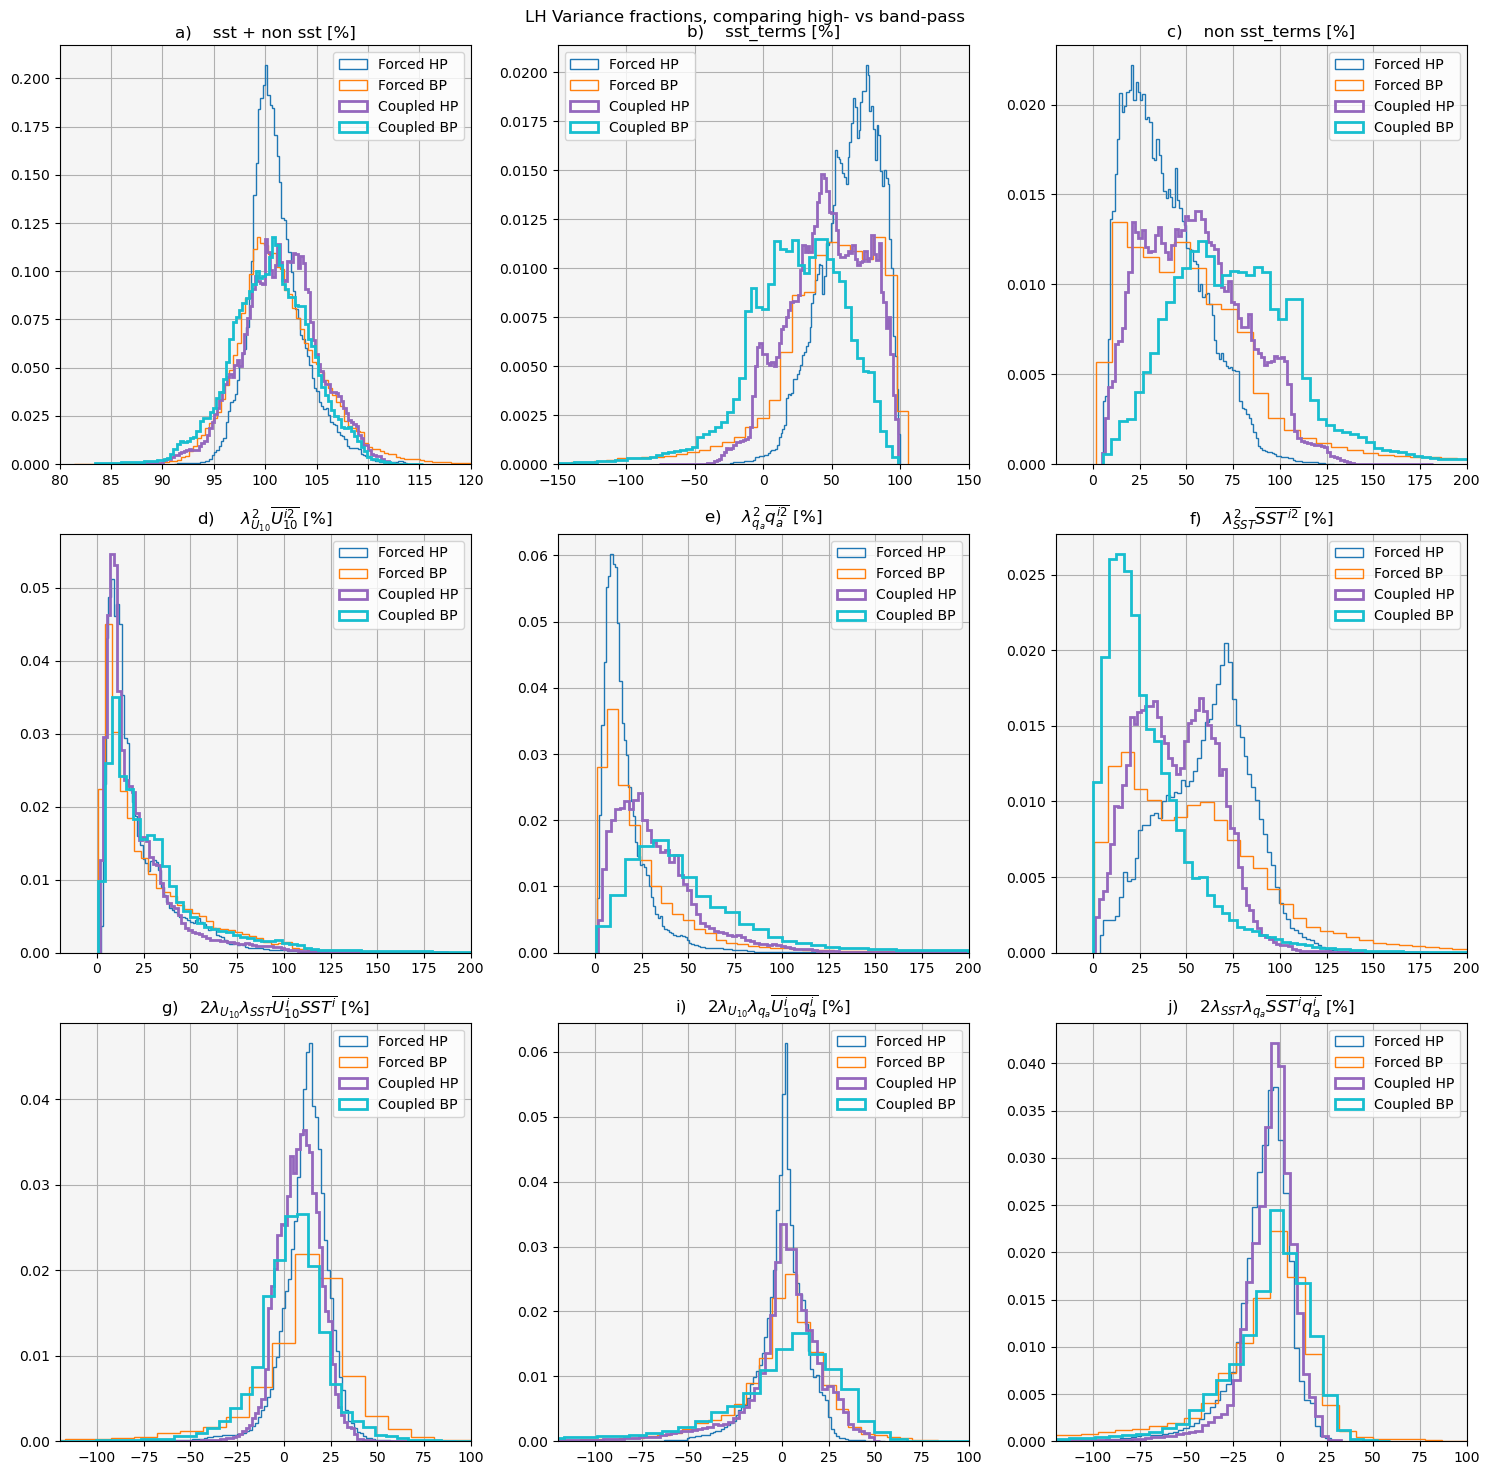

In [22]:

xperc=150
bins=100
factor = 2

fig, axs = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(r'LH Variance fractions, comparing high- vs band-pass')

axs = axs.flatten()
bg_color = '#f5f5f5' #'lightgray'


colors = {
    'Forced HP': '#1f77b4',    # Blue
    'Forced BP': '#ff7f0e',    # Orange
    'Coupled HP': '#9467bd',   # Purple
    'Coupled BP': '#17becf',   # Cyan
}


ax = axs[0]
ax.hist((var_lhf_sum_for_hp*100./var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((var_lhf_sum_for_bp*100./var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((var_lhf_sum_cou_hp*100./var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((var_lhf_sum_cou_bp*100./var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(80, 120)
ax.set_title('a)    sst + non sst [%]')
ax.legend()
ax.set_facecolor(bg_color)

ax = axs[1]
ax.hist((sst_terms_for_hp*100./var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((sst_terms_for_bp*100./var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((sst_terms_cou_hp*100./var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((sst_terms_cou_bp*100./var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(-150, 150)
ax.set_title('b)    sst_terms [%]')
ax.legend()
ax.set_facecolor(bg_color)

ax = axs[2]
ax.hist((non_sst_terms_for_hp*100./var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((non_sst_terms_for_bp*100./var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((non_sst_terms_cou_hp*100./var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((non_sst_terms_cou_bp*100./var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('c)    non sst_terms [%]')
ax.legend()
ax.set_facecolor(bg_color)

ax = axs[3]
ax.hist((lambda_U_for_hp**2*var_U_for_hp*100/var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((lambda_U_for_bp**2*var_U_for_bp*100/var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((lambda_U_cou_hp**2*var_U_cou_hp*100/var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((lambda_U_cou_bp**2*var_U_cou_bp*100/var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('d)     $\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')
ax.legend()
ax.set_facecolor(bg_color)

ax = axs[4]
ax.hist((lambda_q_for_hp**2*var_qa_for_hp*100/var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((lambda_q_for_bp**2*var_qa_for_bp*100/var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((lambda_q_cou_hp**2*var_qa_cou_hp*100/var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((lambda_q_cou_bp**2*var_qa_cou_bp*100/var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('e)    $\\lambda_{q_a}^2 \\overline{q_{a}^{i2}}$ [%]')
ax.legend()
ax.set_facecolor(bg_color)

ax = axs[5]
ax.hist((lambda_sst_for_hp**2*var_sst_for_hp*100/var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((lambda_sst_for_bp**2*var_sst_for_bp*100/var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((lambda_sst_cou_hp**2*var_sst_cou_hp*100/var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((lambda_sst_cou_bp**2*var_sst_cou_bp*100/var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('f)    $\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')
ax.legend()
ax.set_facecolor(bg_color)

ax = axs[6]
ax.hist((lambda_U_for_hp*lambda_sst_for_hp*covar_U_sst_for_hp*100*factor/var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((lambda_U_for_bp*lambda_sst_for_bp*covar_U_sst_for_bp*100*factor/var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((lambda_U_cou_hp*lambda_sst_cou_hp*covar_U_sst_cou_hp*100*factor/var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((lambda_U_cou_bp*lambda_sst_cou_bp*covar_U_sst_cou_bp*100*factor/var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(-120, 100)
title = r"g)    $\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]" if (factor == 1) else r"g)    $2 \lambda_{U_{10}} \lambda_{SST} \overline{U_{10}^{i}SST^i}$ [%]"
ax.set_title(title)
ax.legend()
ax.set_facecolor(bg_color)

ax = axs[7]
ax.hist((lambda_U_for_hp*lambda_q_for_hp*covar_U_q_for_hp*100*factor/var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((lambda_U_for_bp*lambda_q_for_bp*covar_U_q_for_bp*100*factor/var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((lambda_U_cou_hp*lambda_q_cou_hp*covar_U_q_cou_hp*100*factor/var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((lambda_U_cou_bp*lambda_q_cou_bp*covar_U_q_cou_bp*100*factor/var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(-120, 100)
title = r"i)    $\\lambda_{U_{10}}\\lambda_{q_a} \\overline{U_{10}^{i}q_{a}^{i}}$ [%]" if (factor == 1) else r"i)    $2 \lambda_{U_{10}} \lambda_{q_a} \overline{U_{10}^{i}q_{a}^{i}}$ [%]"
ax.set_title(title)
ax.legend()
ax.set_facecolor(bg_color)

ax = axs[8]
ax.hist((lambda_sst_for_hp*lambda_q_for_hp*covar_q_sst_for_hp*100*factor/var_lhf_for_hp).flatten(), bins=bins, histtype='step', density=True, label='Forced HP', color=colors['Forced HP'])
ax.hist((lambda_sst_for_bp*lambda_q_for_bp*covar_q_sst_for_bp*100*factor/var_lhf_for_bp).flatten(), bins=bins, histtype='step', density=True, label='Forced BP', color=colors['Forced BP'])
ax.hist((lambda_sst_cou_hp*lambda_q_cou_hp*covar_q_sst_cou_hp*100*factor/var_lhf_cou_hp).flatten(), bins=bins, histtype='step', density=True, label='Coupled HP', linewidth=2, color=colors['Coupled HP'])
ax.hist((lambda_sst_cou_bp*lambda_q_cou_bp*covar_q_sst_cou_bp*100*factor/var_lhf_cou_bp).flatten(), bins=bins, histtype='step', density=True, label='Coupled BP', linewidth=2, color=colors['Coupled BP'])
ax.grid()
ax.set_xlim(-120, 100)
title = r"j)    $\\lambda_{SST}\\lambda_{q_a} \\overline{SST^{i}q_{a}^{i}}$ [%]" if (factor == 1) else r"j)    $2 \lambda_{SST} \lambda_{q_a} \overline{SST^{i}q_{a}^{i}}$ [%]"
ax.set_title(title)
ax.legend()
ax.set_facecolor(bg_color)



plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/VarLHF_HPBP_SingleTerms_lhfDIR_daily_COLORBLIND.png')



# END OF putting high and band pass bulk together

# SIGMA-INF , smaller domain

rh_sst and ta_sst are 0
0.015809224464670812
q_sst is 0
0.009681114257240608
rh_sst and ta_sst are 0
0.006601667558880697
q_sst is 0
0.006624973686814806


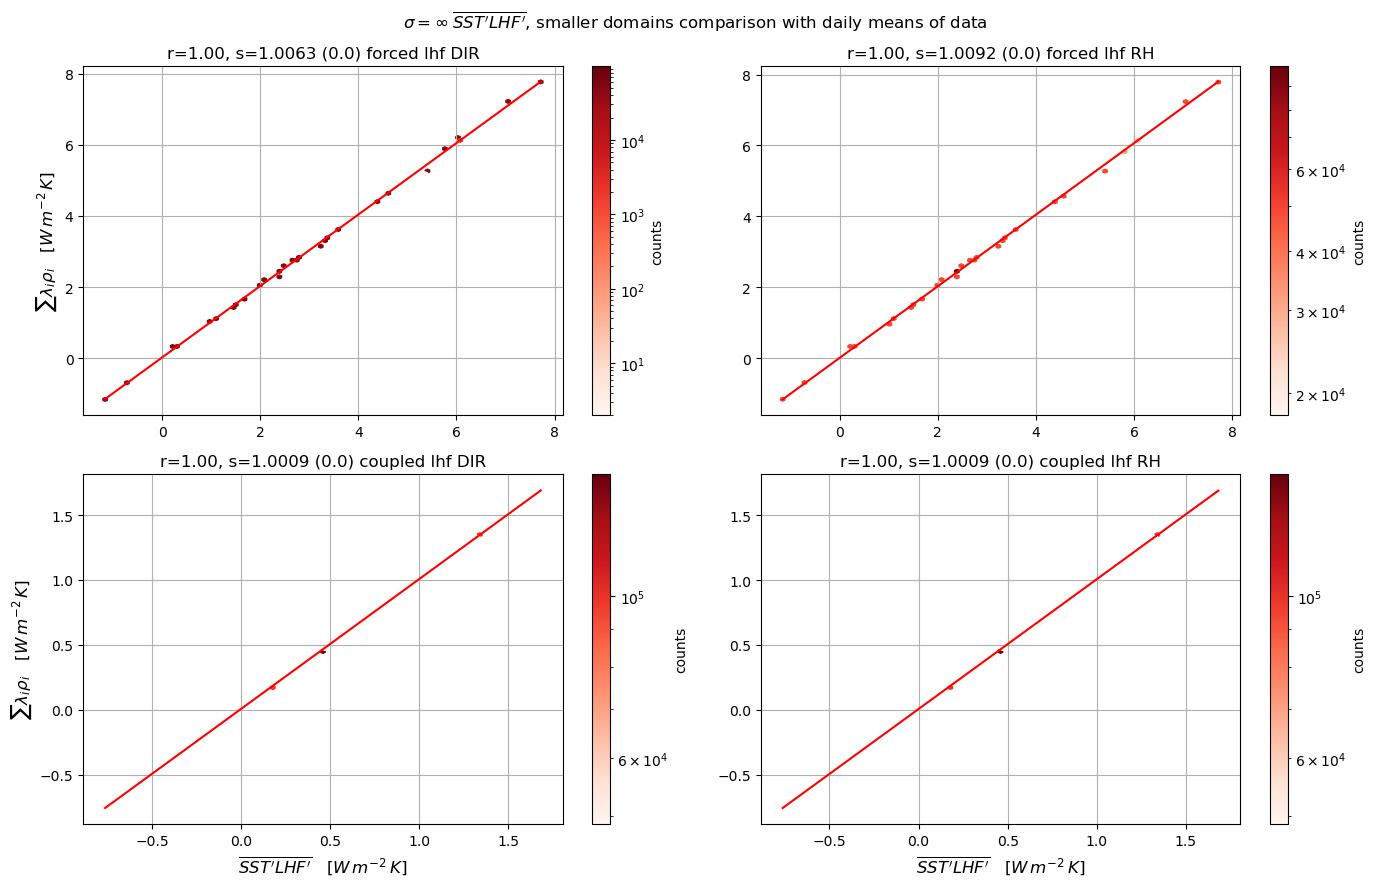

In [29]:
bins = 50

inf_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*SmallerDomain*')

fig, ax =  plt.subplots(2,2, figsize=(14,9))



for i in range(len(inf_files)):
    ds = xr.open_dataset(inf_files[i])
    
    u_sst = ds['lambda_U'].values*ds['covar_U_sst'].values
    sst_sst = ds['lambda_sst'].values*ds['var_sst'].values 
    q_sst = ds['lambda_q'].values*ds['covar_q_sst'].values
    ta_sst = ds['lambda_ta'].values*ds['covar_ta_sst'].values 
    rh_sst = ds['lambda_RH'].values*ds['covar_RH_sst'].values
    
    if np.all(rh_sst[~np.isnan(rh_sst)]==0.) and np.all(ta_sst[~np.isnan(ta_sst)]==0.):
        print('rh_sst and ta_sst are 0')
        del rh_sst, ta_sst
        covar_sum = sst_sst + u_sst + q_sst
    elif np.all(q_sst[~np.isnan(q_sst)]==0.):
        print('q_sst is 0')
        del q_sst
        covar_sum = u_sst + sst_sst + ta_sst + rh_sst
        
    
    covar_lhf_sst = ds['covar_lhf_sst'].values
    
    
    j,k = divmod(i,2)
    xlab = r"$\overline{SST' LHF'}$   [$W \, m^{-2} \, K$]" if j==1 else ''
    ylab = '$\\sum \\lambda_i \\rho_i$   [$W \, m^{-2} \, K$]' if k==0 else ''
    
    RH = True if 'lhfRH' in inf_files[i].split('/')[-1] else False
    RH = ' lhf RH' if RH else ' lhf DIR'
    
    coupled = True if 'ALE' in inf_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    density_scatter_ax(ax=ax[j,k], x=covar_lhf_sst, y=covar_sum, \
                       xlabel=xlab, ylabel=ylab, minititle=coupled+RH, cmap='Reds')
    
fig.suptitle(r"$ \sigma = \infty \; \overline{SST'LHF'}$, smaller domains comparison with daily means of data")
plt.tight_layout()




# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/sigma-inf/SSTLHF_covariance_bandpass_daily_SmallerDomain.png')

rh_sst and ta_sst are 0
q_sst is 0
rh_sst and ta_sst are 0
q_sst is 0


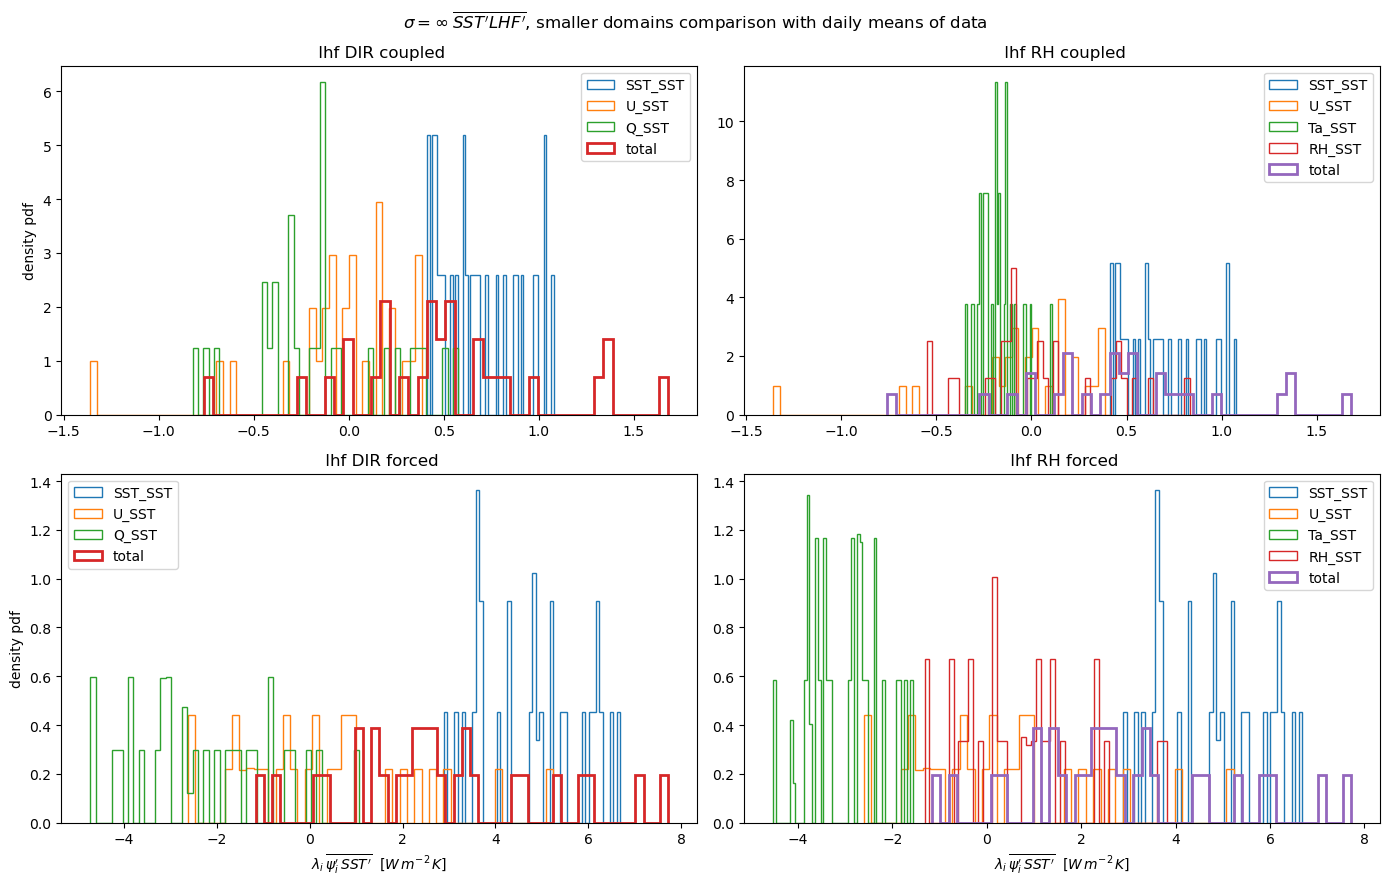

In [32]:
inf_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*SmallerDomain*')
inf_files = sorted(inf_files)

fig, ax =  plt.subplots(2,2, figsize=(14,9))
fig.suptitle(r"$ \sigma = \infty \; \overline{SST'LHF'}$, smaller domains comparison with daily means of data")


def histogram_local(ax,bins, variabs, labels, title, axlabs):
    for i in range(len(variabs)):
        lnwd = 1
        if i+1 == len(variabs):
            lnwd = 2
        ax.hist((variabs[i]).flatten(),bins=bins,histtype=u'step',density=True, linewidth=lnwd)
        ax.legend(labs)
        #ax.set_xlim(-1,3)
        ax.set_title(title)
        ax.set_xlabel(axlabs[0]); ax.set_ylabel(axlabs[1])


for i in range(len(inf_files)):
    ds = xr.open_dataset(inf_files[i])
    
    u_sst = ds['lambda_U'].values*ds['covar_U_sst'].values
    sst_sst = ds['lambda_sst'].values*ds['var_sst'].values 
    q_sst = ds['lambda_q'].values*ds['covar_q_sst'].values
    ta_sst = ds['lambda_ta'].values*ds['covar_ta_sst'].values 
    rh_sst = ds['lambda_RH'].values*ds['covar_RH_sst'].values
    covar_lhf_sst = ds['covar_lhf_sst'].values
    
    if np.all(rh_sst[~np.isnan(rh_sst)]==0.) and np.all(ta_sst[~np.isnan(ta_sst)]==0.):
        print('rh_sst and ta_sst are 0')
        del rh_sst, ta_sst
        var_list = [sst_sst, u_sst, q_sst, covar_lhf_sst]
        labs = ['SST_SST', 'U_SST', 'Q_SST', 'total']
        
    elif np.all(q_sst[~np.isnan(q_sst)]==0.):
        print('q_sst is 0')
        del q_sst
        var_list = [sst_sst, u_sst, ta_sst, rh_sst, covar_lhf_sst]        
        labs = ['SST_SST', 'U_SST', 'Ta_SST', 'RH_SST', 'total']
    
    
    
    j,k = divmod(i,2)
    xlab = r"$\lambda_i \, \overline{\psi_i' \, SST'}$  [$W \, m^{-2} \, K$]" if j==1 else ''
    ylab = 'density pdf' if k==0 else ''
    
    
    RH = True if 'lhfRH' in inf_files[i].split('/')[-1] else False
    RH = ' lhf RH' if RH else ' lhf DIR'
    
    coupled = True if 'ALE' in inf_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    histogram_local(ax = ax[j,k], bins=50, variabs=var_list, labels=labs, title=RH+coupled, axlabs = [xlab,ylab])
    
    
plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/SSTLHF_SingleTerms_covariance_passalto_daily.png')

rh_sst and ta_sst are 0
-0.7789485199599255
q_sst is 0
48.53314410686019
rh_sst and ta_sst are 0
-0.10588149648060607
q_sst is 0
-4.944433161961626


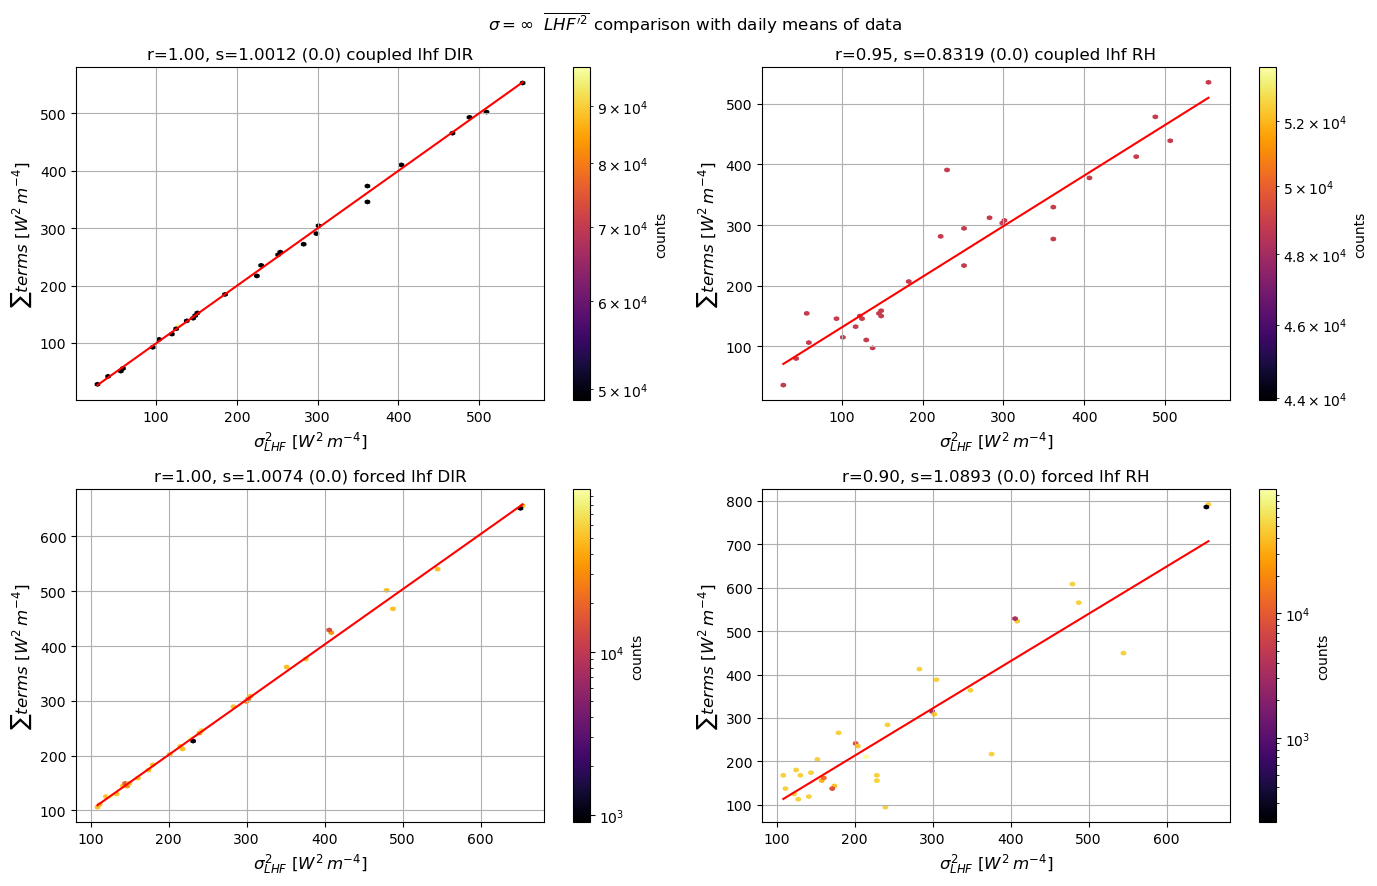

In [35]:
bins = 50

inf_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*SmallerDomain*')
inf_files = sorted(inf_files)

fig, ax =  plt.subplots(2,2, figsize=(14,9))



for i in range(len(inf_files)):
    ds = xr.open_dataset(inf_files[i])
    
    lambda_U = ds['lambda_U'].values
    lambda_sst = ds['lambda_sst'].values
    lambda_q = ds['lambda_q'].values
    lambda_ta = ds['lambda_ta'].values
    lambda_RH = ds['lambda_RH'].values
    
    var_lhf = ds['var_lhf'].values
    var_qa = ds['var_qa'].values 
    var_U = ds['var_U'].values 
    var_ta = ds['var_ta'].values 
    var_RH = ds['var_RH'].values 
    covar_U_ta = ds['covar_U_ta'].values 
    covar_U_RH = ds['covar_U_RH'].values 
    covar_ta_RH = ds['covar_ta_RH'].values 
    covar_U_q = ds['covar_U_q'].values 
    
    # sst terms
    var_sst = ds['var_sst'].values 
    covar_ta_sst = ds['covar_ta_sst'].values 
    covar_U_sst = ds['covar_U_sst'].values
    covar_RH_sst = ds['covar_RH_sst'].values
    covar_q_sst = ds['covar_q_sst'].values
    
    
    if np.all(lambda_RH[~np.isnan(lambda_RH)]==0.) and np.all(lambda_ta[~np.isnan(lambda_ta)]==0.):
        print('rh_sst and ta_sst are 0')
        del lambda_RH, lambda_ta, var_ta, var_RH, covar_U_ta, covar_U_RH, covar_ta_RH
        
        sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst + lambda_q*covar_q_sst))
        non_sst_terms = (lambda_U**2*var_U + lambda_q**2*var_qa + 2*lambda_q*lambda_U*covar_U_q)
        var_lhf_sum = sst_terms + non_sst_terms
    
    elif np.all(lambda_q[~np.isnan(lambda_q)]==0.):
        print('q_sst is 0')
        del lambda_q, covar_U_q, covar_q_sst, var_qa
        
        sst_terms = (lambda_sst**2*var_sst + 
                 2*lambda_sst*(lambda_U*covar_U_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst))
        non_sst_terms = (lambda_U**2*var_U + lambda_ta**2*var_ta + lambda_RH**2*var_RH + 
                         lambda_U*lambda_ta*covar_U_ta + lambda_U*lambda_RH*covar_U_RH + lambda_ta*lambda_RH*covar_ta_RH)
        var_lhf_sum = sst_terms + non_sst_terms
        
    
    #covar_lhf_sst = ds['covar_lhf_sst'].values
    
    
    j,k = divmod(i,2)
    RH = True if 'lhfRH' in inf_files[i].split('/')[-1] else False
    RH = ' lhf RH' if RH else ' lhf DIR'
    
    coupled = True if 'ALE' in inf_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    density_scatter_ax(ax=ax[j,k], x=var_lhf, y=var_lhf_sum, \
                       xlabel='$\\sigma_{LHF}^2$ [$W^2\,m^{-4}$]', ylabel='$\\sum terms$ [$W^2\,m^{-4}$]',\
                       minititle=coupled+RH, cmap='inferno')

    
    
fig.suptitle(r"$\sigma = \infty$  $\overline{LHF'^2}$ smaller domains comparison with daily means of data")
plt.tight_layout()





# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/passalto/VarLHF_passalto_daily.png')


## smaller domain, RH formulation

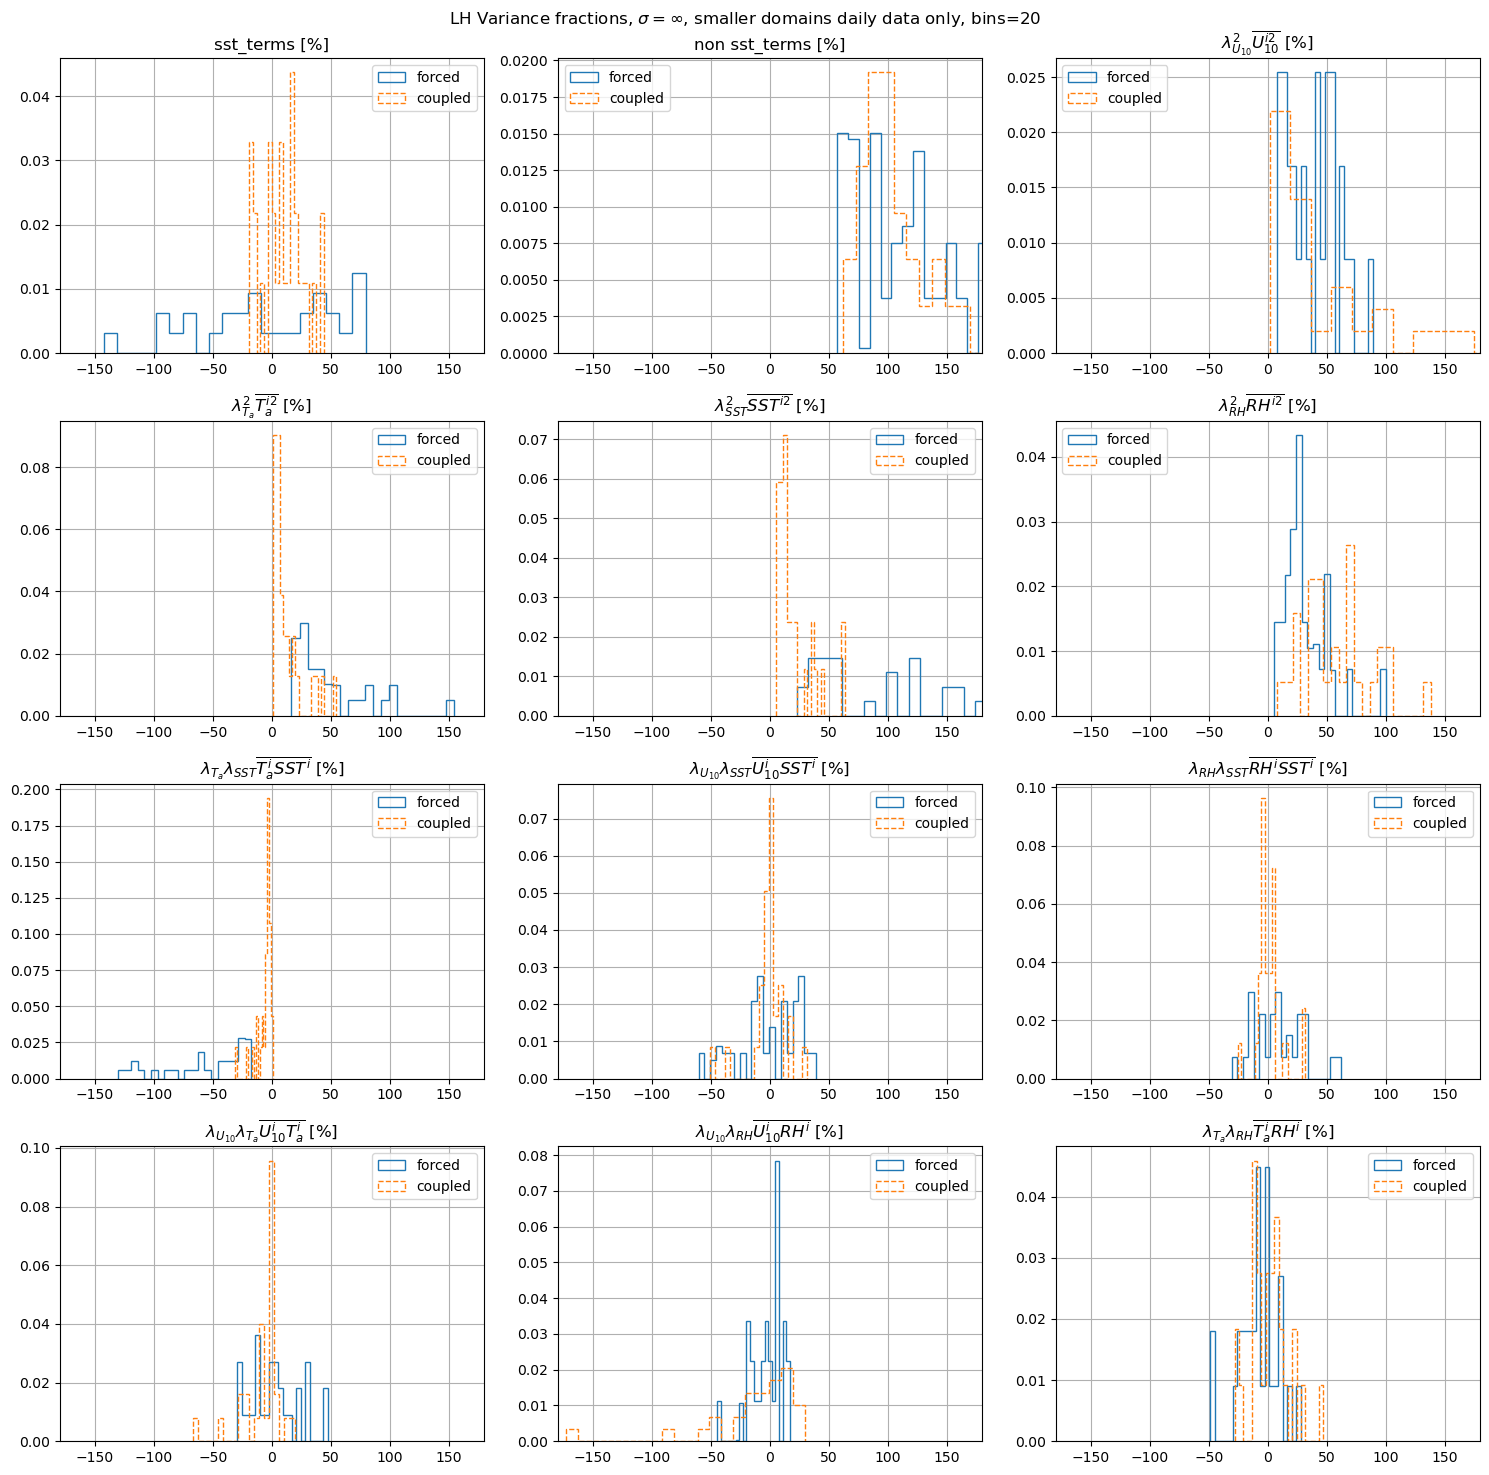

In [39]:

ds_cou = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/ALE_sigma-inf_lhfRH_dailyMeans_SmallerDomain.nc')
ds_for = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_sigma-inf_lhfRH_dailyMeans_SmallerDomain.nc')


lambda_U_for = ds_for['lambda_U'].values
lambda_sst_for = ds_for['lambda_sst'].values
lambda_q_for = ds_for['lambda_q'].values
lambda_ta_for = ds_for['lambda_ta'].values
lambda_RH_for = ds_for['lambda_RH'].values

var_lhf_for = ds_for['var_lhf'].values
var_qa_for = ds_for['var_qa'].values
var_U_for = ds_for['var_U'].values
var_ta_for = ds_for['var_ta'].values
var_RH_for = ds_for['var_RH'].values
covar_U_ta_for = ds_for['covar_U_ta'].values
covar_U_RH_for = ds_for['covar_U_RH'].values
covar_ta_RH_for = ds_for['covar_ta_RH'].values
covar_U_q_for = ds_for['covar_U_q'].values

# sst terms
var_sst_for = ds_for['var_sst'].values
covar_ta_sst_for = ds_for['covar_ta_sst'].values
covar_U_sst_for = ds_for['covar_U_sst'].values
covar_RH_sst_for = ds_for['covar_RH_sst'].values
covar_q_sst_for = ds_for['covar_q_sst'].values


sst_terms_for = (lambda_sst_for**2*var_sst_for + 2*lambda_sst_for*(lambda_U_for*covar_U_sst_for + \
                                                                   lambda_ta_for*covar_ta_sst_for + \
                                                                   lambda_RH_for*covar_RH_sst_for ))
non_sst_terms_for = (lambda_U_for**2*var_U_for + lambda_ta_for**2*var_ta_for + lambda_RH_for**2*var_RH_for + 
                     lambda_U_for*lambda_ta_for*covar_U_ta_for + lambda_U_for*lambda_RH_for*covar_U_RH_for + \
                     lambda_ta_for*lambda_RH_for*covar_ta_RH_for)
var_lhf_sum_for = sst_terms_for + non_sst_terms_for





# Variables for ds_cou
lambda_U_cou = ds_cou['lambda_U'].values
lambda_sst_cou = ds_cou['lambda_sst'].values
lambda_q_cou = ds_cou['lambda_q'].values
lambda_ta_cou = ds_cou['lambda_ta'].values
lambda_RH_cou = ds_cou['lambda_RH'].values

var_lhf_cou = ds_cou['var_lhf'].values
var_qa_cou = ds_cou['var_qa'].values
var_U_cou = ds_cou['var_U'].values
var_ta_cou = ds_cou['var_ta'].values
var_RH_cou = ds_cou['var_RH'].values
covar_U_ta_cou = ds_cou['covar_U_ta'].values
covar_U_RH_cou = ds_cou['covar_U_RH'].values
covar_ta_RH_cou = ds_cou['covar_ta_RH'].values
covar_U_q_cou = ds_cou['covar_U_q'].values

# sst terms
var_sst_cou = ds_cou['var_sst'].values
covar_ta_sst_cou = ds_cou['covar_ta_sst'].values
covar_U_sst_cou = ds_cou['covar_U_sst'].values
covar_RH_sst_cou = ds_cou['covar_RH_sst'].values
covar_q_sst_cou = ds_cou['covar_q_sst'].values


# sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou +\
#                                                                    lambda_q_cou*covar_q_sst_cou ))
# non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_q_cou**2*var_qa_cou + 2*lambda_q_cou*lambda_U_cou*covar_U_q_cou)
# var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou




sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou + \
                                                                   lambda_ta_cou*covar_ta_sst_cou + \
                                                                   lambda_RH_cou*covar_RH_sst_cou ))
non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_ta_cou**2*var_ta_cou + lambda_RH_cou**2*var_RH_cou + 
                     lambda_U_cou*lambda_ta_cou*covar_U_ta_cou + lambda_U_cou*lambda_RH_cou*covar_U_RH_cou + \
                     lambda_ta_cou*lambda_RH_cou*covar_ta_RH_cou)
var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou



    
    
    
    
    
   
    
    
    
    
import matplotlib.pyplot as plt
import xarray as xr

xperc = 180
bins = 20

leg = ['forced', 'coupled']

fig, axs = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle(r'LH Variance fractions, $\sigma = \infty $, smaller domains daily data only, bins='+str(bins))
axs = axs.flatten()

ax = axs[0]
ax.hist((sst_terms_for*100. / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((sst_terms_cou*100. / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('sst_terms [%]')
ax.legend(leg)

ax = axs[1]
ax.hist((non_sst_terms_for*100. / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((non_sst_terms_cou*100. / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('non sst_terms [%]')
ax.legend(leg)

ax = axs[2]
ax.hist((lambda_U_for**2 * var_U_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou**2 * var_U_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')
ax.legend(leg)

ax = axs[3]
ax.hist((lambda_ta_for**2 * var_ta_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou**2 * var_ta_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{T_a}^2 \\overline{T_{a}^{i2}}$ [%]')
ax.legend(leg)

ax = axs[4]
ax.hist((lambda_sst_for**2 *var_sst_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_sst_cou**2 * var_sst_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')
ax.legend(leg)

ax = axs[5]
ax.hist((lambda_RH_for**2 * var_RH_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_RH_cou**2 * var_RH_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{RH}^2 \\overline{RH^{i2}}$ [%]')
ax.legend(leg)

ax = axs[6]
ax.hist((lambda_ta_for * lambda_sst_for * covar_ta_sst_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou * lambda_sst_cou * covar_ta_sst_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{T_a}\\lambda_{SST} \\overline{T_{a}^{i}SST^i}$ [%]')
ax.legend(leg)

ax = axs[7]
ax.hist((lambda_U_for * lambda_sst_for * covar_U_sst_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_sst_cou * covar_U_sst_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]')
ax.legend(leg)

ax = axs[8]
ax.hist((lambda_RH_for * lambda_sst_for * covar_RH_sst_for*100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_RH_cou * lambda_sst_cou * covar_RH_sst_cou*100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{RH}\\lambda_{SST} \\overline{RH^{i}SST^i}$ [%]')
ax.legend(leg)

ax = axs[9]
ax.hist((lambda_U_for * lambda_ta_for * covar_U_ta_for *100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_ta_cou * covar_U_ta_cou *100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{T_a} \\overline{U_{10}^{i}T_a^i}$ [%]')
ax.legend(leg)

ax = axs[10]
ax.hist((lambda_U_for * lambda_RH_for * covar_U_RH_for *100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_U_cou * lambda_RH_cou * covar_U_RH_cou *100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{RH} \\overline{U_{10}^{i}RH^i}$ [%]')
ax.legend(leg)

ax = axs[11]
ax.hist((lambda_ta_for * lambda_RH_for * covar_ta_RH_for *100 / var_lhf_for).flatten(), bins=bins, histtype=u'step', density=True, label='For')
ax.hist((lambda_ta_cou * lambda_RH_cou * covar_ta_RH_cou *100 / var_lhf_cou).flatten(), bins=bins, histtype=u'step', density=True, label='Cou', linestyle='dashed')
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('$\\lambda_{T_a}\\lambda_{RH} \\overline{T_a^{i}RH^i}$ [%]')
ax.legend(leg)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    

plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/sigma-inf/VarLHF_SingleTerms_lhfRH_sigma-inf_daily_SmallerDomain.png')


## smaller domain, direct formulation

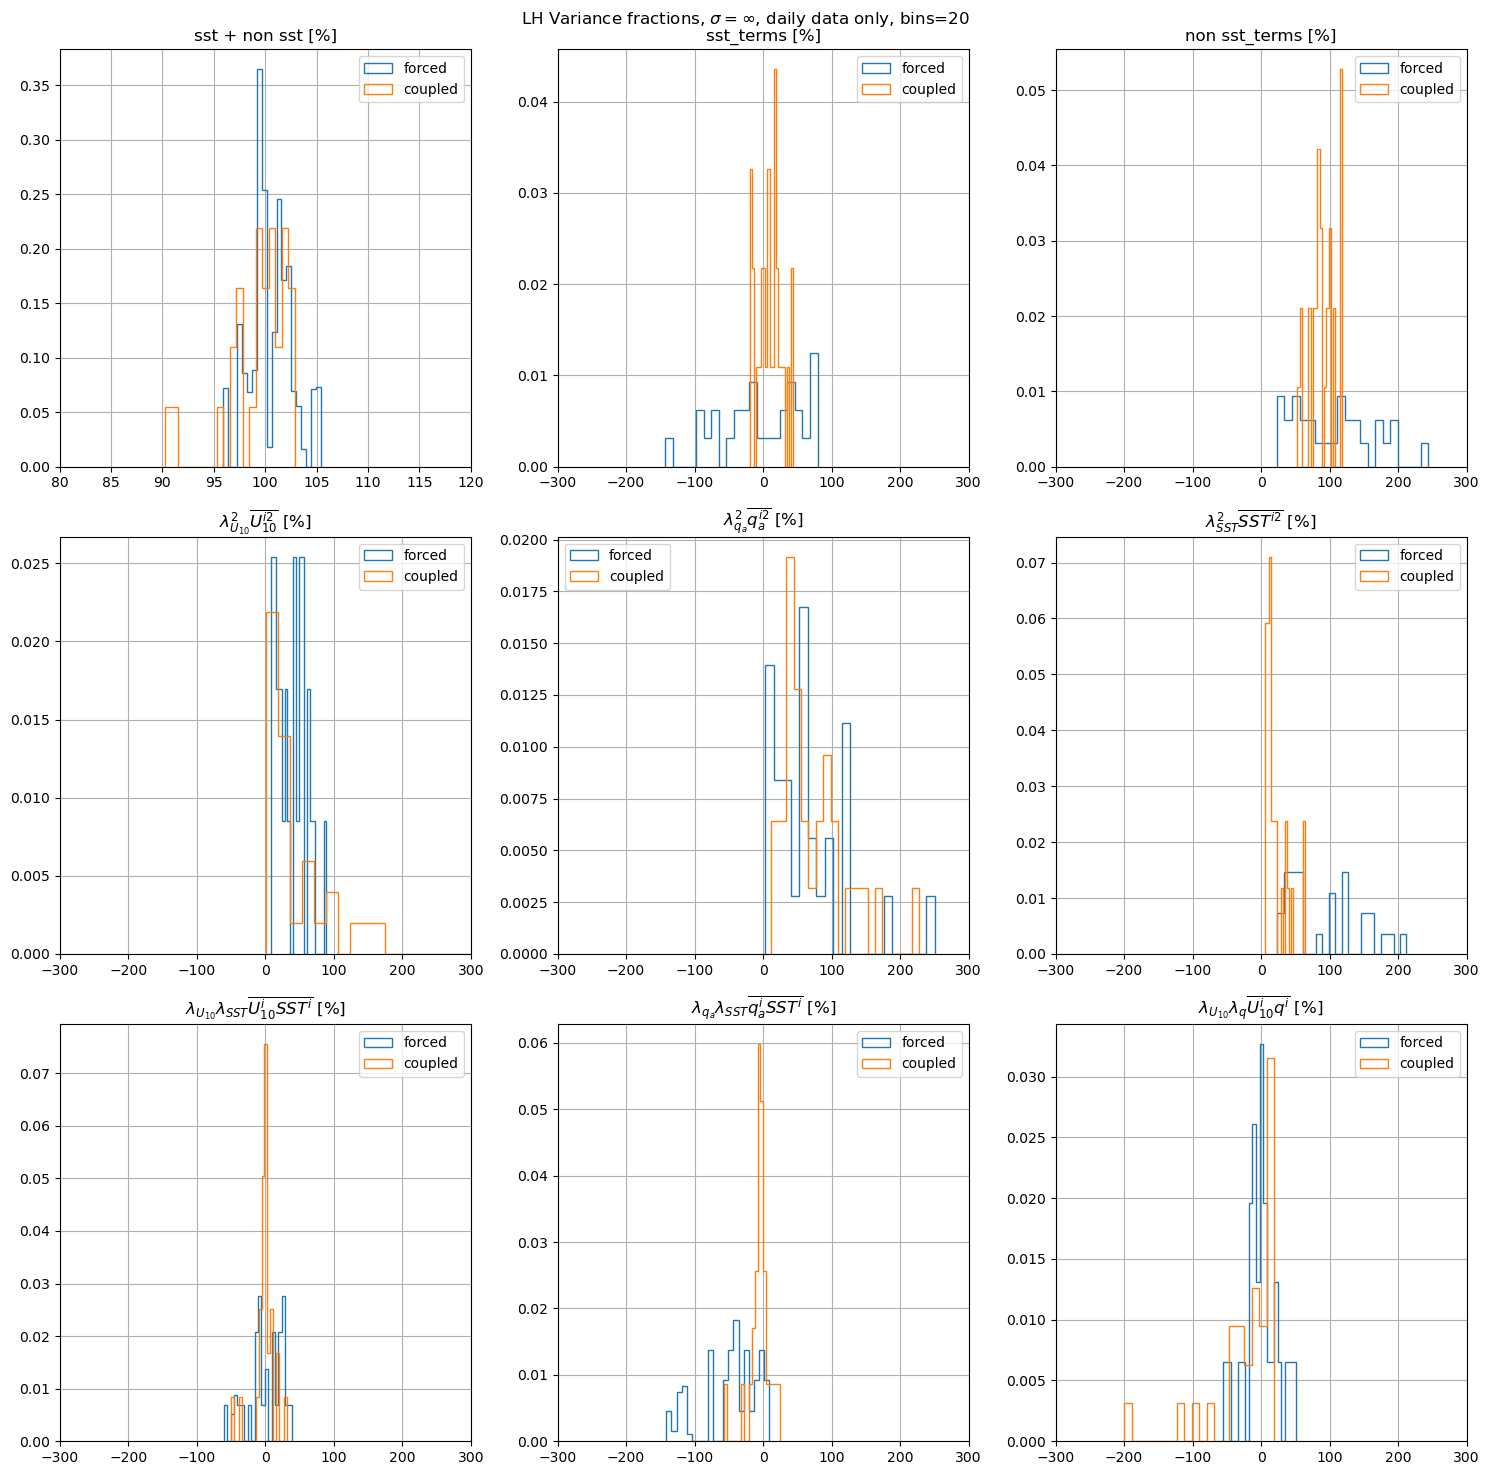

In [41]:
ds_cou = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/ALE_sigma-inf_lhfDIR_dailyMeans_SmallerDomain.nc')
ds_for = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_sigma-inf_lhfDIR_dailyMeans_SmallerDomain.nc')


lambda_U_for = ds_for['lambda_U'].values
lambda_sst_for = ds_for['lambda_sst'].values
lambda_q_for = ds_for['lambda_q'].values
lambda_ta_for = ds_for['lambda_ta'].values
lambda_RH_for = ds_for['lambda_RH'].values

var_lhf_for = ds_for['var_lhf'].values
var_qa_for = ds_for['var_qa'].values
var_U_for = ds_for['var_U'].values
var_ta_for = ds_for['var_ta'].values
var_RH_for = ds_for['var_RH'].values
covar_U_ta_for = ds_for['covar_U_ta'].values
covar_U_RH_for = ds_for['covar_U_RH'].values
covar_ta_RH_for = ds_for['covar_ta_RH'].values
covar_U_q_for = ds_for['covar_U_q'].values

# sst terms
var_sst_for = ds_for['var_sst'].values
covar_ta_sst_for = ds_for['covar_ta_sst'].values
covar_U_sst_for = ds_for['covar_U_sst'].values
covar_RH_sst_for = ds_for['covar_RH_sst'].values
covar_q_sst_for = ds_for['covar_q_sst'].values


# sst_terms_for = (lambda_sst_for**2*var_sst_for + 2*lambda_sst_for*(lambda_U_for*covar_U_sst_for + \
#                                                                    lambda_ta_for*covar_ta_sst_for + \
#                                                                    lambda_RH_for*covar_RH_sst_for ))
# non_sst_terms_for = (lambda_U_for**2*var_U_for + lambda_ta_for**2*var_ta_for + lambda_RH_for**2*var_RH_for + 
#                      lambda_U_for*lambda_ta_for*covar_U_ta_for + lambda_U_for*lambda_RH_for*covar_U_RH_for + \
#                      lambda_ta_for*lambda_RH_for*covar_ta_RH_for)
# var_lhf_sum_for = sst_terms_for + non_sst_terms_for



sst_terms_for = (lambda_sst_for**2*var_sst_for + 2*lambda_sst_for*(lambda_U_for*covar_U_sst_for +\
                                                                   lambda_q_for*covar_q_sst_for ))
non_sst_terms_for = (lambda_U_for**2*var_U_for + lambda_q_for**2*var_qa_for + 2*lambda_q_for*lambda_U_for*covar_U_q_for)
var_lhf_sum_for = sst_terms_for + non_sst_terms_for




# Variables for ds_cou
lambda_U_cou = ds_cou['lambda_U'].values
lambda_sst_cou = ds_cou['lambda_sst'].values
lambda_q_cou = ds_cou['lambda_q'].values
lambda_ta_cou = ds_cou['lambda_ta'].values
lambda_RH_cou = ds_cou['lambda_RH'].values

var_lhf_cou = ds_cou['var_lhf'].values
var_qa_cou = ds_cou['var_qa'].values
var_U_cou = ds_cou['var_U'].values
var_ta_cou = ds_cou['var_ta'].values
var_RH_cou = ds_cou['var_RH'].values
covar_U_ta_cou = ds_cou['covar_U_ta'].values
covar_U_RH_cou = ds_cou['covar_U_RH'].values
covar_ta_RH_cou = ds_cou['covar_ta_RH'].values
covar_U_q_cou = ds_cou['covar_U_q'].values

# sst terms
var_sst_cou = ds_cou['var_sst'].values
covar_ta_sst_cou = ds_cou['covar_ta_sst'].values
covar_U_sst_cou = ds_cou['covar_U_sst'].values
covar_RH_sst_cou = ds_cou['covar_RH_sst'].values
covar_q_sst_cou = ds_cou['covar_q_sst'].values


sst_terms_cou = (lambda_sst_cou**2*var_sst_cou + 2*lambda_sst_cou*(lambda_U_cou*covar_U_sst_cou +\
                                                                   lambda_q_cou*covar_q_sst_cou ))
non_sst_terms_cou = (lambda_U_cou**2*var_U_cou + lambda_q_cou**2*var_qa_cou + 2*lambda_q_cou*lambda_U_cou*covar_U_q_cou)
var_lhf_sum_cou = sst_terms_cou + non_sst_terms_cou







xperc=300
bins=20

leg = ['forced', 'coupled']

fig, axs = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(r'LH Variance fractions, $\sigma = \infty $, daily data only, bins='+str(bins))
axs = axs.flatten()

ax=axs[0]
ax.hist((var_lhf_sum_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((var_lhf_sum_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(80,120)
ax.set_title('sst + non sst [%]')
ax.legend(leg)

ax=axs[1]
ax.hist((sst_terms_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((sst_terms_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('sst_terms [%]')
ax.legend(leg)

ax=axs[2]
ax.hist((non_sst_terms_for*100./var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((non_sst_terms_cou*100./var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('non sst_terms [%]')
ax.legend(leg)

ax=axs[3]
ax.hist((lambda_U_for**2*var_U_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou**2*var_U_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')
ax.legend(leg)

ax=axs[4]
ax.hist((lambda_q_for**2*var_qa_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_q_cou**2*var_qa_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{q_a}^2 \\overline{q_{a}^{i2}}$ [%]')
ax.legend(leg)

ax=axs[5]
ax.hist((lambda_sst_for**2*var_sst_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_sst_cou**2*var_sst_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')
ax.legend(leg)

ax=axs[6]
ax.hist((lambda_U_for*lambda_sst_for*covar_U_sst_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou*lambda_sst_cou*covar_U_sst_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]')
ax.legend(leg)

ax=axs[7]
ax.hist((lambda_q_for*lambda_sst_for*covar_q_sst_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_q_cou*lambda_sst_cou*covar_q_sst_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{q_{a}}\\lambda_{SST} \\overline{q_{a}^{i}SST^i}$ [%]')
ax.legend(leg)

ax=axs[8]
ax.hist((lambda_U_for*lambda_q_for*covar_U_q_for*100/var_lhf_for).flatten(),bins=bins,histtype=u'step',density=True, label='for')
ax.hist((lambda_U_cou*lambda_q_cou*covar_U_q_cou*100/var_lhf_cou).flatten(),bins=bins,histtype=u'step',density=True, label='cou')
ax.grid();  ax.set_xlim(-xperc,xperc)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{q} \\overline{U_{10}^{i}q^i}$ [%]')
ax.legend(leg)

plt.tight_layout()


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/sigma-inf/VarLHF_SingleTerms_lhfDIR_sigma-inf_daily_SmallerDomain.png')



# compare only sigma-inf smaller vs full domains with lhfDIR

In [43]:
inf_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*sigma-inf_lhfDIR*')
inf_files = sorted(inf_files)
inf_files

['/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/ALE_sigma-inf_lhfDIR_dailyMeans.nc',
 '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/ALE_sigma-inf_lhfDIR_dailyMeans_SmallerDomain.nc',
 '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_sigma-inf_lhfDIR_dailyMeans.nc',
 '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_sigma-inf_lhfDIR_dailyMeans_SmallerDomain.nc']

rh_sst and ta_sst are 0
0.0605881232296861
rh_sst and ta_sst are 0
0.006601667558880697
rh_sst and ta_sst are 0
0.09016806443348324
rh_sst and ta_sst are 0
0.015809224464670812


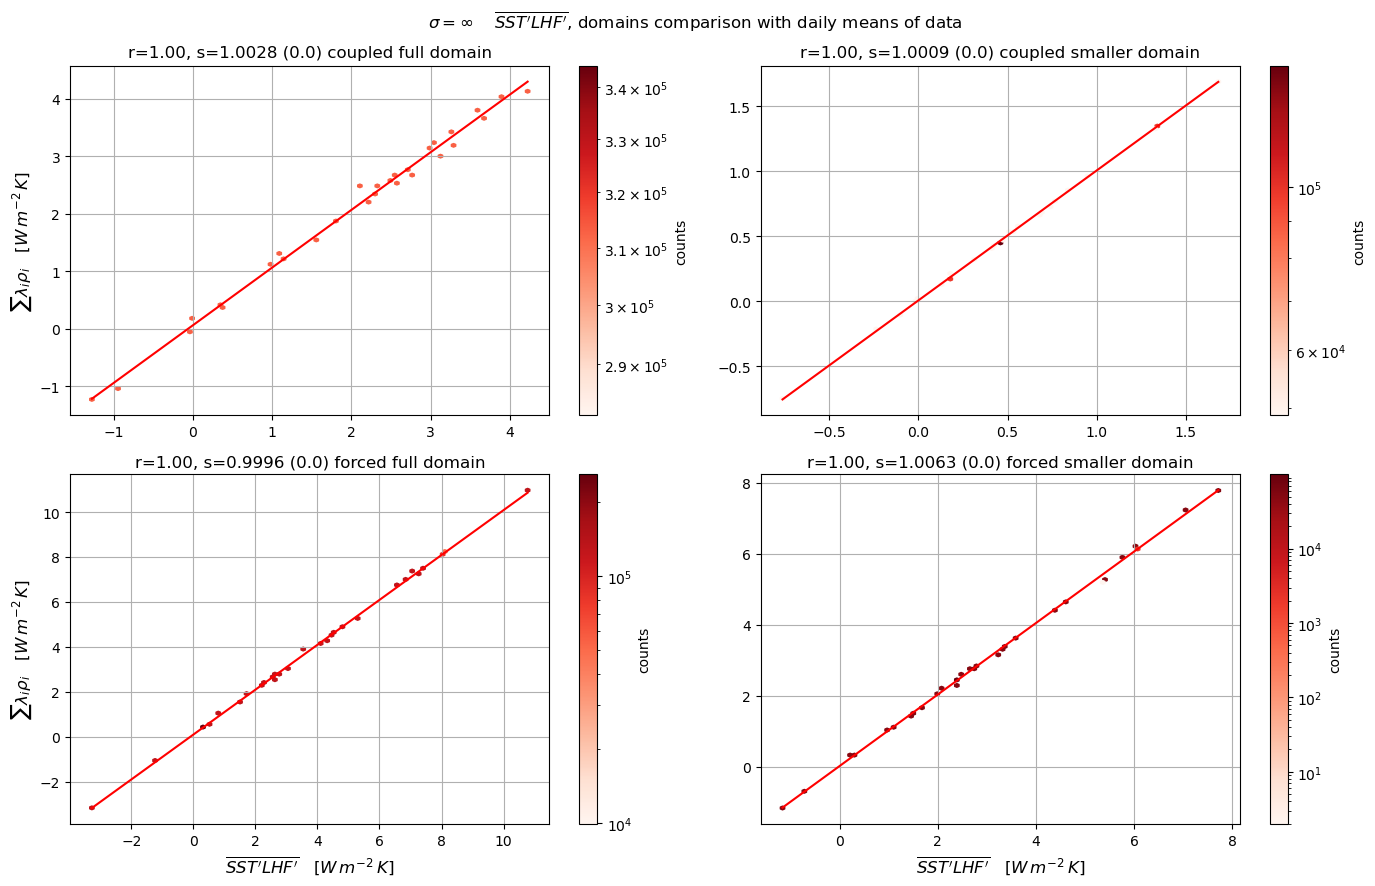

In [50]:
bins = 50

inf_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*sigma-inf_lhfDIR*')
inf_files = sorted(inf_files)
fig, ax =  plt.subplots(2,2, figsize=(14,9))



for i in range(len(inf_files)):
    ds = xr.open_dataset(inf_files[i])
    
    u_sst = ds['lambda_U'].values*ds['covar_U_sst'].values
    sst_sst = ds['lambda_sst'].values*ds['var_sst'].values 
    q_sst = ds['lambda_q'].values*ds['covar_q_sst'].values
    ta_sst = ds['lambda_ta'].values*ds['covar_ta_sst'].values 
    rh_sst = ds['lambda_RH'].values*ds['covar_RH_sst'].values
    
    if np.all(rh_sst[~np.isnan(rh_sst)]==0.) and np.all(ta_sst[~np.isnan(ta_sst)]==0.):
        print('rh_sst and ta_sst are 0')
        del rh_sst, ta_sst
        covar_sum = sst_sst + u_sst + q_sst
    elif np.all(q_sst[~np.isnan(q_sst)]==0.):
        print('q_sst is 0')
        del q_sst
        covar_sum = u_sst + sst_sst + ta_sst + rh_sst
        
    
    covar_lhf_sst = ds['covar_lhf_sst'].values
    
    
    j,k = divmod(i,2)
    xlab = r"$\overline{SST' LHF'}$   [$W \, m^{-2} \, K$]" if j==1 else ''
    ylab = '$\\sum \\lambda_i \\rho_i$   [$W \, m^{-2} \, K$]' if k==0 else ''
    
    small = True if 'SmallerDomain' in inf_files[i].split('/')[-1] else False
    small = ' smaller domain' if small else ' full domain'
    
    coupled = True if 'ALE' in inf_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    density_scatter_ax(ax=ax[j,k], x=covar_lhf_sst, y=covar_sum, \
                       xlabel=xlab, ylabel=ylab, minititle=coupled+small, cmap='Reds')
    
fig.suptitle(r"$ \sigma = \infty$    $\overline{SST'LHF'}$, domains comparison with daily means of data")
plt.tight_layout()




# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/sigma-inf/SSTLHF_covariance_bandpass_daily_Small-vs-Full.png')

rh_sst and ta_sst are 0
-16.46098012197183
rh_sst and ta_sst are 0
-0.7789485199599255
rh_sst and ta_sst are 0
-13.819119654593635
rh_sst and ta_sst are 0
-0.10588149648060607


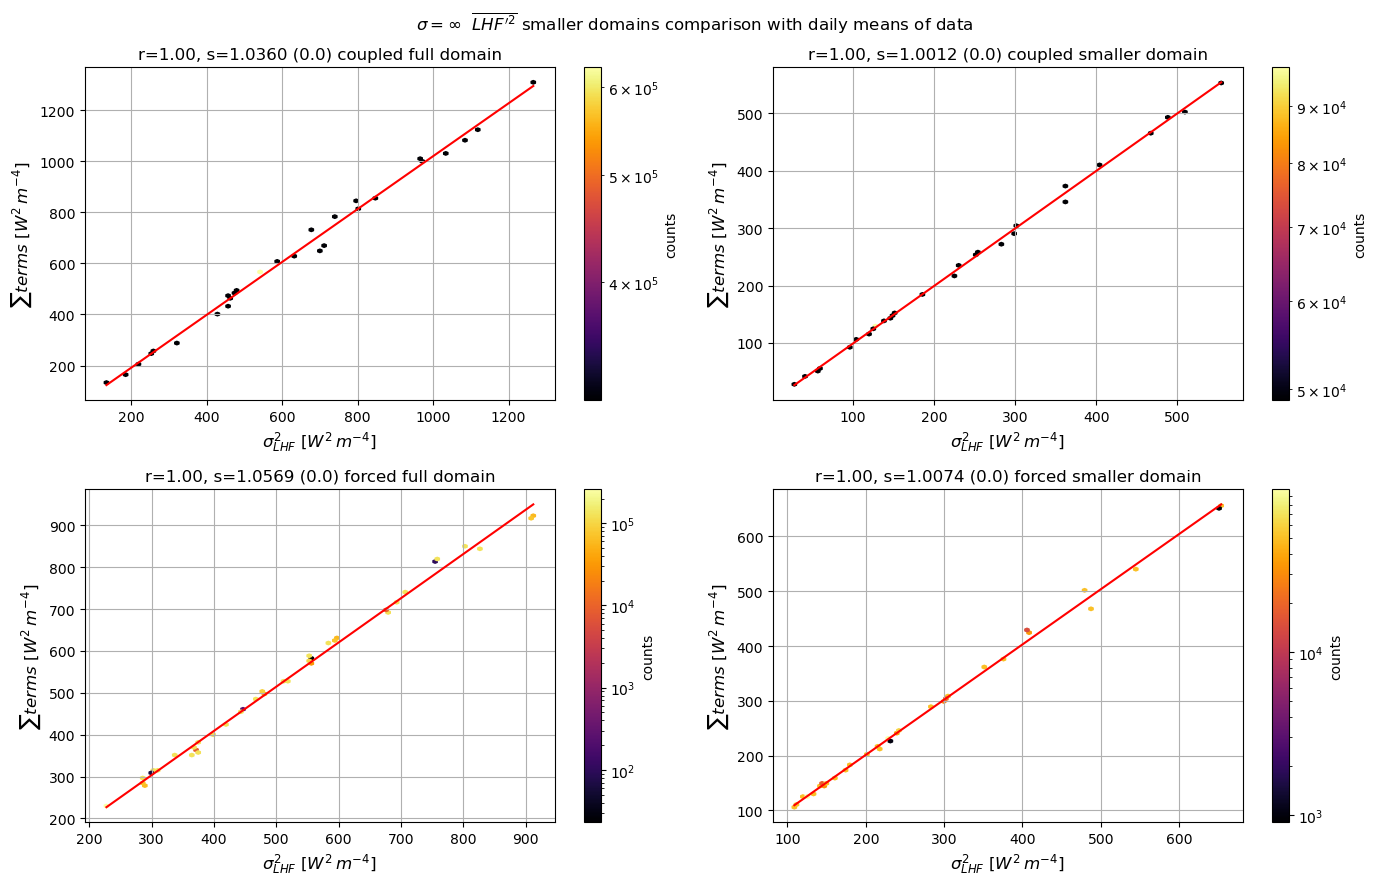

In [49]:
bins = 50

inf_files = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/*sigma-inf_lhfDIR*')
inf_files = sorted(inf_files)

fig, ax =  plt.subplots(2,2, figsize=(14,9))



for i in range(len(inf_files)):
    ds = xr.open_dataset(inf_files[i])
    
    lambda_U = ds['lambda_U'].values
    lambda_sst = ds['lambda_sst'].values
    lambda_q = ds['lambda_q'].values
    lambda_ta = ds['lambda_ta'].values
    lambda_RH = ds['lambda_RH'].values
    
    var_lhf = ds['var_lhf'].values
    var_qa = ds['var_qa'].values 
    var_U = ds['var_U'].values 
    var_ta = ds['var_ta'].values 
    var_RH = ds['var_RH'].values 
    covar_U_ta = ds['covar_U_ta'].values 
    covar_U_RH = ds['covar_U_RH'].values 
    covar_ta_RH = ds['covar_ta_RH'].values 
    covar_U_q = ds['covar_U_q'].values 
    
    # sst terms
    var_sst = ds['var_sst'].values 
    covar_ta_sst = ds['covar_ta_sst'].values 
    covar_U_sst = ds['covar_U_sst'].values
    covar_RH_sst = ds['covar_RH_sst'].values
    covar_q_sst = ds['covar_q_sst'].values
    
    
    if np.all(lambda_RH[~np.isnan(lambda_RH)]==0.) and np.all(lambda_ta[~np.isnan(lambda_ta)]==0.):
        print('rh_sst and ta_sst are 0')
        del lambda_RH, lambda_ta, var_ta, var_RH, covar_U_ta, covar_U_RH, covar_ta_RH
        
        sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst + lambda_q*covar_q_sst))
        non_sst_terms = (lambda_U**2*var_U + lambda_q**2*var_qa + 2*lambda_q*lambda_U*covar_U_q)
        var_lhf_sum = sst_terms + non_sst_terms
    
    elif np.all(lambda_q[~np.isnan(lambda_q)]==0.):
        print('q_sst is 0')
        del lambda_q, covar_U_q, covar_q_sst, var_qa
        
        sst_terms = (lambda_sst**2*var_sst + 
                 2*lambda_sst*(lambda_U*covar_U_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst))
        non_sst_terms = (lambda_U**2*var_U + lambda_ta**2*var_ta + lambda_RH**2*var_RH + 
                         lambda_U*lambda_ta*covar_U_ta + lambda_U*lambda_RH*covar_U_RH + lambda_ta*lambda_RH*covar_ta_RH)
        var_lhf_sum = sst_terms + non_sst_terms
        
    
    #covar_lhf_sst = ds['covar_lhf_sst'].values
    
    
    j,k = divmod(i,2)
    #xlab = r"$\overline{SST' LHF'}$   [$W \, m^{-2} \, K$]" if j==1 else ''
    #ylab = '$\\sum \\lambda_i \\rho_i$   [$W \, m^{-2} \, K$]' if k==0 else ''
    
    small = True if 'SmallerDomain' in inf_files[i].split('/')[-1] else False
    small = ' smaller domain' if small else ' full domain'
    
    coupled = True if 'ALE' in inf_files[i].split('/')[-1] else False
    coupled = ' coupled' if coupled else ' forced'
    
    density_scatter_ax(ax=ax[j,k], x=var_lhf, y=var_lhf_sum, \
                       xlabel='$\\sigma_{LHF}^2$ [$W^2\,m^{-4}$]', ylabel='$\\sum terms$ [$W^2\,m^{-4}$]',\
                       minititle=coupled+small, cmap='inferno')

    
    
fig.suptitle(r"$\sigma = \infty$  $\overline{LHF'^2}$ smaller domains comparison with daily means of data")
plt.tight_layout()





plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/sigma-inf/VarLHF_passalto_daily_lhfDIR_Small-vs-Full.png')


# Differentiate contribution from different approaches

## with coupled model and lhfDIR

In [27]:

path = '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/lambda_vars/'
files = ['ALE_bandpass_150-60_lhfDIR_dailyMeans.nc', 'ALE_passalto_150_dailyMeans_lhfDir.nc', 'ALE_sigma-inf_lhfDIR_dailyMeans.nc']

for i in range(len(files)):
    files[i] = path+files[i]

### data from bandpass

ds = xr.open_dataset(files[0])
    
lambda_U_bandpas = ds['lambda_U'].values
lambda_sst_bandpas = ds['lambda_sst'].values
lambda_q_bandpas = ds['lambda_q'].values
lambda_ta_bandpas = ds['lambda_ta'].values
lambda_RH_bandpas = ds['lambda_RH'].values

var_lhf_bandpas = ds['var_lhf'].values
var_qa_bandpas = ds['var_qa'].values
var_U_bandpas = ds['var_U'].values
var_ta_bandpas = ds['var_ta'].values
var_RH_bandpas = ds['var_RH'].values
covar_U_ta_bandpas = ds['covar_U_ta'].values
covar_U_RH_bandpas = ds['covar_U_RH'].values
covar_ta_RH_bandpas = ds['covar_ta_RH'].values
covar_U_q_bandpas = ds['covar_U_q'].values

# sst terms
var_sst_bandpas = ds['var_sst'].values
covar_ta_sst_bandpas = ds['covar_ta_sst'].values
covar_U_sst_bandpas = ds['covar_U_sst'].values
covar_RH_sst_bandpas = ds['covar_RH_sst'].values
covar_q_sst_bandpas = ds['covar_q_sst'].values
covar_lhf_sst_bandpas = ds['covar_lhf_sst'].values


sst_terms_bandpas = (lambda_sst_bandpas**2*var_sst_bandpas + 2*lambda_sst_bandpas*(lambda_U_bandpas*covar_U_sst_bandpas +\
                                                                           lambda_q_bandpas*covar_q_sst_bandpas))
non_sst_terms_bandpas = (lambda_U_bandpas**2*var_U_bandpas + lambda_q_bandpas**2*var_qa_bandpas + 2*lambda_q_bandpas*lambda_U_bandpas*covar_U_q_bandpas)
var_lhf_sum_bandpas = sst_terms_bandpas + non_sst_terms_bandpas



#### data from passalto

ds = xr.open_dataset(files[1])

lambda_U_highpas = ds['lambda_U'].values
lambda_sst_highpas = ds['lambda_sst'].values
lambda_q_highpas = ds['lambda_q'].values
lambda_ta_highpas = ds['lambda_ta'].values
lambda_RH_highpas = ds['lambda_RH'].values

var_lhf_highpas = ds['var_lhf'].values
var_qa_highpas = ds['var_qa'].values
var_U_highpas = ds['var_U'].values
var_ta_highpas = ds['var_ta'].values
var_RH_highpas = ds['var_RH'].values
covar_U_ta_highpas = ds['covar_U_ta'].values
covar_U_RH_highpas = ds['covar_U_RH'].values
covar_ta_RH_highpas = ds['covar_ta_RH'].values
covar_U_q_highpas = ds['covar_U_q'].values

# sst terms
var_sst_highpas = ds['var_sst'].values
covar_ta_sst_highpas = ds['covar_ta_sst'].values
covar_U_sst_highpas = ds['covar_U_sst'].values
covar_RH_sst_highpas = ds['covar_RH_sst'].values
covar_q_sst_highpas = ds['covar_q_sst'].values
covar_lhf_sst_highpas = ds['covar_lhf_sst'].values


sst_terms_highpas = (lambda_sst_highpas**2*var_sst_highpas + 2*lambda_sst_highpas*(lambda_U_highpas*covar_U_sst_highpas +\
                                                                           lambda_q_highpas*covar_q_sst_highpas))
non_sst_terms_highpas = (lambda_U_highpas**2*var_U_highpas + lambda_q_highpas**2*var_qa_highpas + 2*lambda_q_highpas*lambda_U_highpas*covar_U_q_highpas)
var_lhf_sum_highpas = sst_terms_highpas + non_sst_terms_highpas



#### data from sigma inf

ds = xr.open_dataset(files[2])

lambda_U_inf = ds['lambda_U'].values
lambda_sst_inf = ds['lambda_sst'].values
lambda_q_inf = ds['lambda_q'].values
lambda_ta_inf = ds['lambda_ta'].values
lambda_RH_inf = ds['lambda_RH'].values

var_lhf_inf = ds['var_lhf'].values
var_qa_inf = ds['var_qa'].values
var_U_inf = ds['var_U'].values
var_ta_inf = ds['var_ta'].values
var_RH_inf = ds['var_RH'].values
covar_U_ta_inf = ds['covar_U_ta'].values
covar_U_RH_inf = ds['covar_U_RH'].values
covar_ta_RH_inf = ds['covar_ta_RH'].values
covar_U_q_inf = ds['covar_U_q'].values

# sst terms
var_sst_inf = ds['var_sst'].values
covar_ta_sst_inf = ds['covar_ta_sst'].values
covar_U_sst_inf = ds['covar_U_sst'].values
covar_RH_sst_inf = ds['covar_RH_sst'].values
covar_q_sst_inf = ds['covar_q_sst'].values
covar_lhf_sst_inf = ds['covar_lhf_sst'].values


sst_terms_inf = (lambda_sst_inf**2*var_sst_inf + 2*lambda_sst_inf*(lambda_U_inf*covar_U_sst_inf +\
                                                               lambda_q_inf*covar_q_sst_inf))
non_sst_terms_inf = (lambda_U_inf**2*var_U_inf + lambda_q_inf**2*var_qa_inf + 2*lambda_q_inf*lambda_U_inf*covar_U_q_inf)
var_lhf_sum_inf = sst_terms_inf + non_sst_terms_inf



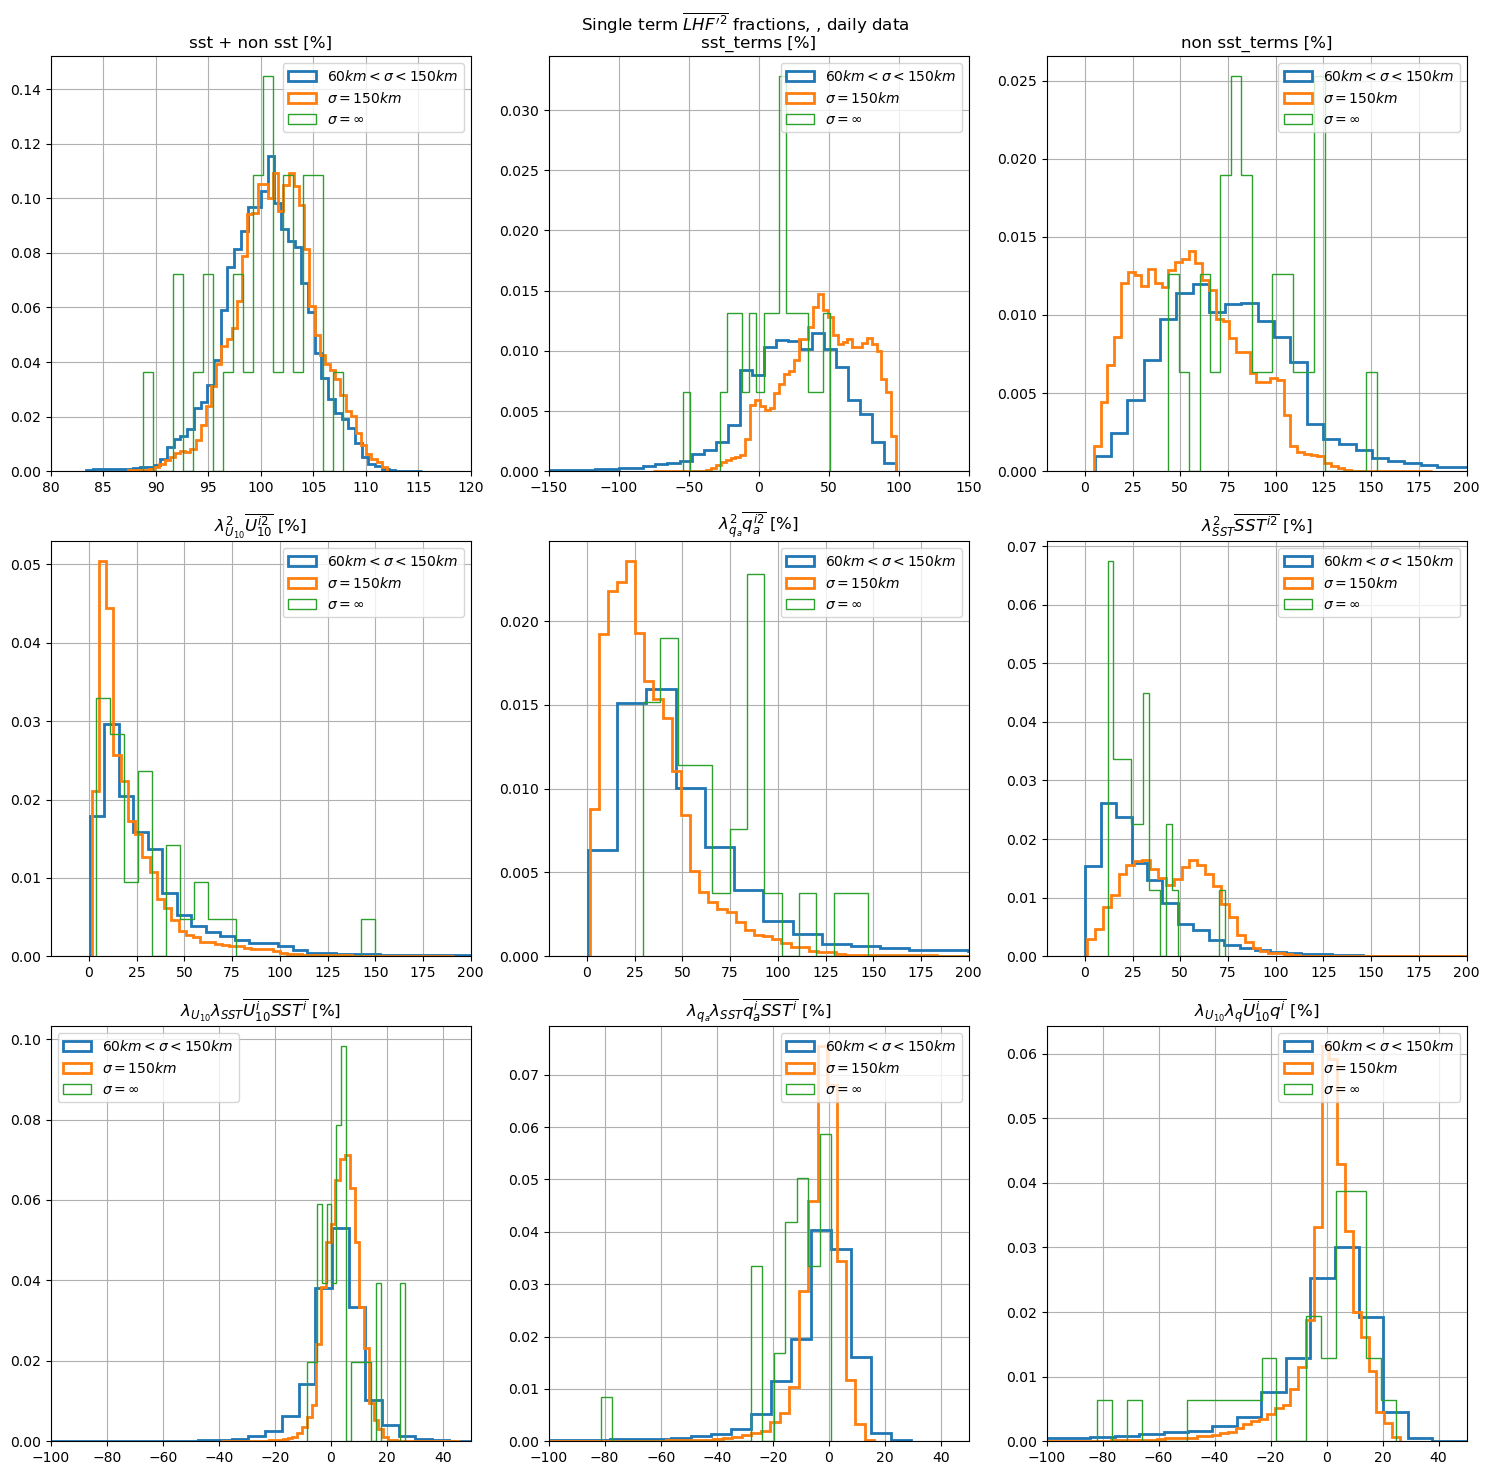

In [30]:
import matplotlib.pyplot as plt

xperc = 150
bins_highband = 50
bins_inf = 20

leg = [r"$60km < \sigma < 150km$", r"$\sigma = 150km$", r'$\sigma = \infty$']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle(r"Single term $\overline{LHF'^2}$ fractions, , daily data")
axs = axs.flatten()

ax = axs[0]
ax.hist((var_lhf_sum_bandpas * 100. / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((var_lhf_sum_highpas * 100. / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((var_lhf_sum_inf * 100. / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(80, 120)
ax.set_title('sst + non sst [%]')
ax.legend(leg)

ax = axs[1]
ax.hist((sst_terms_bandpas * 100. / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((sst_terms_highpas * 100. / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((sst_terms_inf * 100. / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(-xperc, xperc)
ax.set_title('sst_terms [%]')
ax.legend(leg)

ax = axs[2]
ax.hist((non_sst_terms_bandpas * 100. / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((non_sst_terms_highpas * 100. / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((non_sst_terms_inf * 100. / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('non sst_terms [%]')
ax.legend(leg)

ax = axs[3]
ax.hist((lambda_U_bandpas**2 * var_U_bandpas * 100 / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_U_highpas**2 * var_U_highpas * 100 / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_U_inf**2 * var_U_inf * 100 / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('$\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [%]')
ax.legend(leg)

ax = axs[4]
ax.hist((lambda_q_bandpas**2 * var_qa_bandpas * 100 / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_q_highpas**2 * var_qa_highpas * 100 / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_q_inf**2 * var_qa_inf * 100 / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('$\\lambda_{q_a}^2 \\overline{q_{a}^{i2}}$ [%]')
ax.legend(leg)

ax = axs[5]
ax.hist((lambda_sst_bandpas**2 * var_sst_bandpas * 100 / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_sst_highpas**2 * var_sst_highpas * 100 / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_sst_inf**2 * var_sst_inf * 100 / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(-20, 200)
ax.set_title('$\\lambda_{SST}^2 \\overline{SST^{i2}}$ [%]')
ax.legend(leg)

ax = axs[6]
ax.hist((lambda_U_bandpas * lambda_sst_bandpas * covar_U_sst_bandpas * 100 / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_U_highpas * lambda_sst_highpas * covar_U_sst_highpas * 100 / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_U_inf * lambda_sst_inf * covar_U_sst_inf * 100 / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(-100, 50)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [%]')
ax.legend(leg)

ax = axs[7]
ax.hist((lambda_q_bandpas * lambda_sst_bandpas * covar_q_sst_bandpas * 100 / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_q_highpas * lambda_sst_highpas * covar_q_sst_highpas * 100 / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_q_inf * lambda_sst_inf * covar_q_sst_inf * 100 / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(-100, 50)
ax.set_title('$\\lambda_{q_{a}}\\lambda_{SST} \\overline{q_{a}^{i}SST^i}$ [%]')
ax.legend(leg)

ax = axs[8]
ax.hist((lambda_U_bandpas * lambda_q_bandpas * covar_U_q_bandpas * 100 / var_lhf_bandpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_U_highpas * lambda_q_highpas * covar_U_q_highpas * 100 / var_lhf_highpas).flatten(), bins=bins_highband, histtype='step', density=True, linewidth=2)
ax.hist((lambda_U_inf * lambda_q_inf * covar_U_q_inf * 100 / var_lhf_inf).flatten(), bins=bins_inf, histtype='step', density=True)
ax.grid()
ax.set_xlim(-100, 50)
ax.set_title('$\\lambda_{U_{10}}\\lambda_{q} \\overline{U_{10}^{i}q^i}$ [%]')
ax.legend(leg)

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/ForCou_img/VarLHF_SingleTerms_COUPLED_lhfDIR_daily_TechniquesCompar.png')


plt.tight_layout()
plt.show()
